In [124]:
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Set display options
pd.set_option('display.max_rows', 10**4)  # Set the maximum number of displayed rows to 100
pd.set_option('display.max_columns', 10**4)  # Set the maximum number of displayed columns to 50

seed_value = 100  # you can set a seed value of your choice

np.random.seed(seed_value)  # seed for NumPy

random.seed(seed_value)  # seed for Python random module

import warnings
warnings.filterwarnings("ignore")

#### Data Reading

In [125]:
def read_h5_to_df(h5_path, key):
    """
    Load a DataFrame from an h5 (HDF5) file.

    Args:
        h5_path (str): The path to the h5 file.
        key (str): Identifier for the group in the store.

    Returns:
        pandas.DataFrame: The DataFrame that was stored in the h5 file.
    """
    # Load the DataFrame from h5
    return pd.read_hdf(h5_path, key=key)

path = '/home/sayem/Desktop/Lobster/data/LOB3data.h5'
LOB3Data = read_h5_to_df(path, 'data')

In [126]:
LOB3Data.head(30)

,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,BidPrice3,BidSize3
0,2012-06-21 09:30:00.005742728,275200,66,275100,400,275300,1000,275000,100,275400,373,274900,200
1,2012-06-21 09:30:00.006241020,275200,166,275100,400,275300,1000,275000,100,275400,373,274900,200
2,2012-06-21 09:30:00.006461694,275200,166,275100,400,275300,1000,275000,100,275400,373,274900,200
3,2012-06-21 09:30:00.048863815,275200,166,275100,400,275300,1000,274900,200,275400,373,274800,661
4,2012-06-21 09:30:00.048883439,275200,166,275100,300,275300,1000,274900,200,275400,373,274800,661
5,2012-06-21 09:30:00.048989220,275200,166,275100,300,275300,1000,275000,100,275400,373,274900,200
6,2012-06-21 09:30:00.049010886,275200,166,275100,300,275300,1000,275000,100,275400,373,274900,700
7,2012-06-21 09:30:00.049078453,275200,166,275100,300,275300,1000,275000,100,275400,373,274900,700
8,2012-06-21 09:30:00.049110147,275200,166,275100,300,275300,1000,275000,100,275400,373,274900,700
9,2012-06-21 09:30:00.049300503,275200,166,275100,300,275300,1000,275000,300,275400,373,274900,700


#### Feature Generation

In [127]:
def calculate_lob_features(data, num_bins, window_len, delay_steps, lambda_):
    """
    This function calculates the state values and adds them to the provided dataframe.

    Args:
        data (pd.DataFrame): DataFrame with LOB (Limit Order Book) data including time, 
                             bid and ask prices and sizes.
        num_bins (int): The number of bins used to partition smoothed imbalance index for discretization.
        window_len (int): The number of backward ticks used to average imbalance index during smoothing.
        delay_steps (int): The number of forward ticks used to convert the mid prices to discrete delta S.
        lambda_ (float): The weighting parameter used to compute the imbalance index.

    Returns:
        data (pd.DataFrame): DataFrame with added 'rho', 'DS' and other related columns.
    """
    import numpy as np
    import pandas as pd
    from scipy.stats import linregress

    num_bins = int(num_bins)
    window_len = int(window_len)
    delay_steps = int(delay_steps)
    lambda_ = float(lambda_)


    # Copy the data to avoid modifying the original DataFrame
    data = data.copy()

    # Calculate mid price
    data['S'] = (data['BidPrice1'] + data['AskPrice1']) / 2

    # Calculate LOB level 3 imbalance index 
    weights = np.exp(-(lambda_) * np.array([0, 1, 2]))
    VAsk = weights[0]*data['AskSize1'] + weights[1]*data['AskSize2'] + weights[2]*data['AskSize3']
    VBid = weights[0]*data['BidSize1'] + weights[1]*data['BidSize2'] + weights[2]*data['BidSize3']
    data['I'] = (VBid - VAsk) / (VBid + VAsk)

    # Compute smoothed imbalance index and bin it
    sI = data['I'].rolling(window=int(window_len), min_periods=1).mean()
    data['sI'] = sI 
    bin_edges = np.linspace(-1, 1, int(num_bins) + 1)
    rho = np.digitize(sI, bin_edges) - 1  # arrays start at 0 in Python

    # Compute price changes
    DS = np.nan * np.empty_like(data['S'])
    shiftS = data['S'].values[delay_steps:]
    DS[:-delay_steps] = np.sign(shiftS - data['S'].values[:-delay_steps])
    DS[np.isnan(DS)] = 0
    DS = DS.astype(int)

    # Convert the 'Time' column to datetime if it isn't already
    data['t'] = pd.to_datetime(data['Time'])

    # Calculate the difference between successive timestamps
    data['DT'] = data['t'].diff().dt.total_seconds()

    # Add computed columns to the DataFrame
    data['rho'] = rho # discretize imbalance index
    data['DS'] = DS # discretize price movement
    data['DS'] = data['DS'] + 1


    # Calculate additional features
    # Calculate order book slopes
    data['BidSlope'] = data[['BidSize1', 'BidSize2', 'BidSize3']].apply(lambda x: linregress([1, 2, 3], x)[0], axis=1)
    data['AskSlope'] = data[['AskSize1', 'AskSize2', 'AskSize3']].apply(lambda x: linregress([1, 2, 3], x)[0], axis=1)

    # Calculate relative spreads
    data['RelSpread'] = (data['AskPrice1'] - data['BidPrice1']) / data['S']

    # Calculate accumulated bid/ask volumes
    data['AccumBidVol'] = data['BidSize1'] + data['BidSize2'] + data['BidSize3']
    data['AccumAskVol'] = data['AskSize1'] + data['AskSize2'] + data['AskSize3']

    # Calculate Order Flow
    data['OrderFlow'] = (data['BidSize1'] - data['AskSize1']).rolling(window=window_len, min_periods=1).sum()

    # Calculate Liquidity
    data['Liquidity'] = (data['BidSize1'] + data['AskSize1']).rolling(window=window_len, min_periods=1).sum()

    # Calculate order book depth
    data['BookDepth'] = data[['BidSize1', 'BidSize2', 'BidSize3', 'AskSize1', 'AskSize2', 'AskSize3']].sum(axis=1)

    # Calculate Volatility
    data['Volatility'] = data['S'].rolling(window=window_len, min_periods=1).std()

    # Calculate Price Momentum
    data['PriceMomentum'] = data['S'] - data['S'].shift(window_len)

    # Calculate Spread
    data['Spread'] = data['AskPrice1'] - data['BidPrice1']

    # Calculate Price Impact
    data['PriceImpact'] = data['S'].diff() / data['OrderFlow'].shift()

    # Calculate Depth Imbalance
    data['DepthImbalance'] = data[['BidSize1', 'BidSize2', 'BidSize3']].sum(axis=1) \
        - data[['AskSize1', 'AskSize2', 'AskSize3']].sum(axis=1)
    
    # Calculate Quote Count
    data['QuoteCount'] = data['t'].rolling(window=window_len, min_periods=0).count()


    # Select necessary columns and rename
    data = data[['t', 'S', 'I', 'sI', 'DT', 'rho', 'DS', 'BidPrice1', 'AskPrice1', 'BidSlope', \
                 'AskSlope', 'RelSpread', 'AccumBidVol', 'AccumAskVol', 
                 'OrderFlow', 'Liquidity', 'BookDepth', 'Volatility', \
                 'PriceMomentum', 'Spread', 'PriceImpact', 'DepthImbalance', \
                 'QuoteCount']]
    
    data = data.rename(columns={'rho': 'current_imbalance_idx', \
                                'DS': 'current_price_movement', \
                                'BidPrice1': 'MOBid', 'AskPrice1': 'MOAsk'})

    return data

In [128]:
# num_bins = 3 # n = dI = Number of bins for I  Hyperparameter
# window_len = 20 # Window lengths  Hyperparameter
# dS = delay_steps = 20 # Delay steps  Hyperparameter
# lambda_  = 0.5 # Hyperparameter

# data = calculate_lob_features(LOB3Data, num_bins, window_len, delay_steps, lambda_)
# print('Data shape before nan removal: ', data.shape)
# data = data.dropna().reset_index(drop=True)
# print('Data shape after nan removal: ', data.shape)

In [129]:
# LOB3Data.columns

In [130]:
# data.columns

In [131]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import numpy as np

def get_dataloaders(df, feature_columns, categorical_features, batch_size=64, val_data=False, return_raw_test_data=False):

    # Make a copy of the original dataframe
    original_df = df.copy()

    # Generate the new column 'future_price_movement'
    df = df[feature_columns]
    df = df.assign(future_price_movement=df['current_price_movement'].shift(-1))

    # Drop any rows with NaN values in 'future_price_movement' column
    df = df.dropna(subset=['future_price_movement'])

    # Drop columns with NaN values
    df.dropna(axis=1, inplace=True)

    # Convert 'future_price_movement' column to integers
    df['future_price_movement'] = df['future_price_movement'].astype(int)

    # Define continuous features
    continuous_features = [col for col in df.columns if col not in \
        categorical_features + ['future_price_movement']]

    # Split the data into training and testing sets
    train_size = int(len(df) * 0.8)
    train_data = df[:train_size]
    test_data = df[train_size:]

    # Separate the features and the target variable for all sets
    X_train_full = train_data.drop(['future_price_movement'], axis=1)
    y_train_full = train_data['future_price_movement']

    X_test = test_data.drop(['future_price_movement'], axis=1)
    y_test = test_data['future_price_movement']

    # If validation data is requested, split the training data
    if val_data:
        val_size = int(len(X_train_full) * 0.2)
        X_train = X_train_full[:-val_size]
        y_train = y_train_full[:-val_size]
        X_val = X_train_full[-val_size:]
        y_val = y_train_full[-val_size:]
    else:
        X_train = X_train_full
        y_train = y_train_full

    # Handle imbalanced dataset using SMOTE
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Standardize continuous features and one-hot encode categorical features
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse=False)

    X_train_continuous = scaler.fit_transform(X_train[continuous_features])
    X_train_categorical = ohe.fit_transform(X_train[categorical_features])

    X_test_continuous = scaler.transform(X_test[continuous_features])
    X_test_categorical = ohe.transform(X_test[categorical_features])

    if val_data:
        X_val_continuous = scaler.transform(X_val[continuous_features])
        X_val_categorical = ohe.transform(X_val[categorical_features])

    # Join continuous and categorical variables back into one array
    X_train_encoded = np.hstack((X_train_continuous, X_train_categorical))
    X_test_encoded = np.hstack((X_test_continuous, X_test_categorical))

    if val_data:
        X_val_encoded = np.hstack((X_val_continuous, X_val_categorical))

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_encoded, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test_encoded, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) 

    if val_data:
        X_val_tensor = torch.tensor(X_val_encoded, dtype=torch.float)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    if val_data:
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if val_data:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Get the portion of the original dataframe corresponding to the test loader
    if return_raw_test_data:
        raw_test_data = original_df.iloc[train_size:]

    if val_data and return_raw_test_data:
        return train_loader, test_loader, val_loader, raw_test_data
    elif val_data:
        return train_loader, test_loader, val_loader
    elif return_raw_test_data:
        return train_loader, test_loader, raw_test_data
    else:
        return train_loader, test_loader


In [132]:
import torch
import torch.nn as nn  
import torch.nn.functional as F   

from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna import create_study
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score

from torch.utils.data import DataLoader, TensorDataset
from optuna import create_study
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

class Net(nn.Module):
    def __init__(self, n_features, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)  # Input Layer
        self.fc2 = nn.Linear(64, 64)  # Hidden Layer
        self.fc3 = nn.Linear(64, n_classes)  # Output Layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# # get a single batch to extract the number of features and classes
# single_batch = next(iter(train_loader))
# n_features = single_batch[0].shape[1]  # number of features
# n_classes = len(set(single_batch[1].numpy()))  # number of classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device('cpu')

In [133]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, \
    confusion_matrix, classification_report, roc_auc_score

def train_model(model, train_dataloader, device, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_batches = 0
        # Added tqdm around the dataloader to show progress
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        average_loss = total_loss / total_batches
        print(f"Epoch {epoch+1}, Average Loss: {average_loss}")
    # return average_loss


def evaluate_model(model, dataloader, device, test=False):
    from sklearn.metrics import accuracy_score, \
        confusion_matrix, classification_report
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, axis=1)
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    if test:
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        # Compute confusion matrix
        matrix = confusion_matrix(y_true, y_pred)
        return matrix
    
    return f1_score(y_true, y_pred, average='micro')
    

In [134]:
from optuna.pruners import MedianPruner
from torch import optim

def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 15)
    num_bins = trial.suggest_int("num_bins", 2, 10) # n = dI = Number of bins for I  Hyperparameter
    window_len = trial.suggest_int("window_len", 10, 30) # Window lengths  Hyperparameter
    delay_steps = trial.suggest_int("delay_steps", 10, 30) # Delay steps  Hyperparameter
    lambda_  = trial.suggest_float("lambda_", 0.1, 1) # Hyperparameter

    data = calculate_lob_features(LOB3Data, num_bins, window_len, delay_steps, lambda_)

    feature_columns = ['current_imbalance_idx', 'current_price_movement', 'BidSlope', \
                   'AskSlope', 'RelSpread', 'AccumBidVol', 'AccumAskVol', 'OrderFlow', 'Liquidity', \
                   'BookDepth', 'Volatility', 'PriceMomentum', 'Spread', 'DepthImbalance']

    categorical_features = ['current_imbalance_idx', 'current_price_movement']

    # train_loader, _, val_loader = get_dataloaders(data, feature_columns, \
    #                 categorical_features, batch_size=batch_size, val_data=True)
    
    train_loader, _, val_loader = get_dataloaders(data, feature_columns, categorical_features, \
                    batch_size=batch_size, val_data=True, return_raw_test_data=False)
                    

    single_batch = next(iter(train_loader))
    n_features = single_batch[0].shape[1]  # number of features
    n_classes = len(set(single_batch[1].numpy()))  # number of classes

    model = Net(n_features, n_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_model(model, train_loader, device, optimizer, criterion, epochs)
    val_f1_score = evaluate_model(model, val_loader, device)
    return val_f1_score

# # Optimize with early stopping
# pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10)
# study = create_study(direction='maximize', pruner=pruner)
# study.optimize(objective, n_trials=10)


In [135]:
# Optimize with early stopping
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=15)
study = optuna.create_study(study_name='Searching for the optimum Hyperparams for Trade', direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

[I 2023-06-26 13:04:59,154] A new study created in memory with name: Searching for the optimum Hyperparams for Trade
Epoch 1: 100%|██████████| 60013/60013 [00:43<00:00, 1381.53it/s]


Epoch 1, Average Loss: 0.15763845145867325


Epoch 2: 100%|██████████| 60013/60013 [00:40<00:00, 1465.96it/s]


Epoch 2, Average Loss: 0.08802338385490692


Epoch 3: 100%|██████████| 60013/60013 [00:39<00:00, 1508.52it/s]


Epoch 3, Average Loss: 0.08701078315715705


Epoch 4: 100%|██████████| 60013/60013 [00:40<00:00, 1471.71it/s]


Epoch 4, Average Loss: 0.08616856250062319


Epoch 5: 100%|██████████| 60013/60013 [00:39<00:00, 1507.11it/s]


Epoch 5, Average Loss: 0.08543569832704212


Epoch 6: 100%|██████████| 60013/60013 [00:40<00:00, 1469.98it/s]


Epoch 6, Average Loss: 0.08480426564803442


Epoch 7: 100%|██████████| 60013/60013 [00:39<00:00, 1511.23it/s]


Epoch 7, Average Loss: 0.08426454522424084


Epoch 8: 100%|██████████| 60013/60013 [00:41<00:00, 1462.80it/s]


Epoch 8, Average Loss: 0.08377217672106223


Epoch 9: 100%|██████████| 60013/60013 [00:40<00:00, 1480.62it/s]


Epoch 9, Average Loss: 0.08334141304264983


Epoch 10: 100%|██████████| 60013/60013 [00:40<00:00, 1480.03it/s]


Epoch 10, Average Loss: 0.082958308673631


[I 2023-06-26 13:12:23,367] Trial 0 finished with value: 0.9937072415128437 and parameters: {'lr': 1.6252789159483027e-05, 'batch_size': 16, 'epochs': 10, 'num_bins': 5, 'window_len': 19, 'delay_steps': 28, 'lambda_': 0.3836529373798785}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 32888/32888 [00:23<00:00, 1399.06it/s]


Epoch 1, Average Loss: 0.23812290061773694


Epoch 2: 100%|██████████| 32888/32888 [00:23<00:00, 1400.20it/s]


Epoch 2, Average Loss: 0.13794277579331854


Epoch 3: 100%|██████████| 32888/32888 [00:22<00:00, 1459.52it/s]


Epoch 3, Average Loss: 0.1352326520394393


Epoch 4: 100%|██████████| 32888/32888 [00:23<00:00, 1388.29it/s]


Epoch 4, Average Loss: 0.13342687146394333


Epoch 5: 100%|██████████| 32888/32888 [00:23<00:00, 1392.59it/s]


Epoch 5, Average Loss: 0.13203283180303008


Epoch 6: 100%|██████████| 32888/32888 [00:24<00:00, 1367.85it/s]


Epoch 6, Average Loss: 0.1308922615244467


Epoch 7: 100%|██████████| 32888/32888 [00:22<00:00, 1475.56it/s]


Epoch 7, Average Loss: 0.1299309571612393


Epoch 8: 100%|██████████| 32888/32888 [00:23<00:00, 1409.42it/s]


Epoch 8, Average Loss: 0.12911582798977544


Epoch 9: 100%|██████████| 32888/32888 [00:23<00:00, 1400.29it/s]


Epoch 9, Average Loss: 0.12841293915209223


Epoch 10: 100%|██████████| 32888/32888 [00:25<00:00, 1292.67it/s]


Epoch 10, Average Loss: 0.12776103315102164


Epoch 11: 100%|██████████| 32888/32888 [00:25<00:00, 1315.38it/s]


Epoch 11, Average Loss: 0.12709171729154775


Epoch 12: 100%|██████████| 32888/32888 [00:23<00:00, 1382.54it/s]


Epoch 12, Average Loss: 0.12645249376061019


[I 2023-06-26 13:17:43,823] Trial 1 finished with value: 0.9868336130114883 and parameters: {'lr': 1.6832567675090153e-05, 'batch_size': 32, 'epochs': 12, 'num_bins': 7, 'window_len': 18, 'delay_steps': 10, 'lambda_': 0.2693915914189671}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15223/15223 [00:12<00:00, 1217.48it/s]


Epoch 1, Average Loss: 0.09498387470478986


Epoch 2: 100%|██████████| 15223/15223 [00:12<00:00, 1223.68it/s]


Epoch 2, Average Loss: 0.08748908636980539


Epoch 3: 100%|██████████| 15223/15223 [00:12<00:00, 1260.59it/s]


Epoch 3, Average Loss: 0.08540150738656932


Epoch 4: 100%|██████████| 15223/15223 [00:12<00:00, 1248.06it/s]


Epoch 4, Average Loss: 0.08384292784928767


Epoch 5: 100%|██████████| 15223/15223 [00:12<00:00, 1246.42it/s]


Epoch 5, Average Loss: 0.08217528258333294


Epoch 6: 100%|██████████| 15223/15223 [00:11<00:00, 1276.08it/s]


Epoch 6, Average Loss: 0.08047966870646242


Epoch 7: 100%|██████████| 15223/15223 [00:12<00:00, 1265.47it/s]


Epoch 7, Average Loss: 0.07877565146788684


Epoch 8: 100%|██████████| 15223/15223 [00:11<00:00, 1282.66it/s]


Epoch 8, Average Loss: 0.07744116985166836


Epoch 9: 100%|██████████| 15223/15223 [00:12<00:00, 1176.15it/s]


Epoch 9, Average Loss: 0.07600659901684721


Epoch 10: 100%|██████████| 15223/15223 [00:12<00:00, 1246.71it/s]


Epoch 10, Average Loss: 0.07499653931258031


Epoch 11: 100%|██████████| 15223/15223 [00:11<00:00, 1270.53it/s]


Epoch 11, Average Loss: 0.07400196304702708


[I 2023-06-26 13:20:34,260] Trial 2 finished with value: 0.9819930295598296 and parameters: {'lr': 0.0011593356723636895, 'batch_size': 64, 'epochs': 11, 'num_bins': 4, 'window_len': 11, 'delay_steps': 25, 'lambda_': 0.6960419433105023}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14860/14860 [00:12<00:00, 1218.66it/s]


Epoch 1, Average Loss: 0.08602876017811178


Epoch 2: 100%|██████████| 14860/14860 [00:11<00:00, 1262.70it/s]


Epoch 2, Average Loss: 0.08107747125441227


Epoch 3: 100%|██████████| 14860/14860 [00:12<00:00, 1199.98it/s]


Epoch 3, Average Loss: 0.08007819646970064


Epoch 4: 100%|██████████| 14860/14860 [00:11<00:00, 1239.97it/s]


Epoch 4, Average Loss: 0.0795103365667904


Epoch 5: 100%|██████████| 14860/14860 [00:11<00:00, 1241.48it/s]


Epoch 5, Average Loss: 0.07885855214369783


Epoch 6: 100%|██████████| 14860/14860 [00:12<00:00, 1229.83it/s]


Epoch 6, Average Loss: 0.07830039289905934


Epoch 7: 100%|██████████| 14860/14860 [00:12<00:00, 1201.54it/s]


Epoch 7, Average Loss: 0.07823950685347615


[I 2023-06-26 13:22:33,924] Trial 3 finished with value: 0.9936534572522697 and parameters: {'lr': 0.0032555768616035455, 'batch_size': 64, 'epochs': 7, 'num_bins': 2, 'window_len': 14, 'delay_steps': 30, 'lambda_': 0.6747493232304264}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:06<00:00, 1092.24it/s]


Epoch 1, Average Loss: 0.10440191740017413


Epoch 2: 100%|██████████| 7538/7538 [00:06<00:00, 1099.42it/s]


Epoch 2, Average Loss: 0.08462486335645465


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1090.24it/s]


Epoch 3, Average Loss: 0.08301588367279367


Epoch 4: 100%|██████████| 7538/7538 [00:06<00:00, 1086.68it/s]


Epoch 4, Average Loss: 0.08207561636037687


Epoch 5: 100%|██████████| 7538/7538 [00:07<00:00, 1073.05it/s]


Epoch 5, Average Loss: 0.08122481727040069


Epoch 6: 100%|██████████| 7538/7538 [00:07<00:00, 1031.14it/s]


Epoch 6, Average Loss: 0.0806750660092795


Epoch 7: 100%|██████████| 7538/7538 [00:07<00:00, 1072.15it/s]


Epoch 7, Average Loss: 0.07996597778831448


Epoch 8: 100%|██████████| 7538/7538 [00:07<00:00, 1075.00it/s]


Epoch 8, Average Loss: 0.07947805181100448


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1093.77it/s]


Epoch 9, Average Loss: 0.07895267963272036


Epoch 10: 100%|██████████| 7538/7538 [00:07<00:00, 1075.48it/s]


Epoch 10, Average Loss: 0.07855104001618983


Epoch 11: 100%|██████████| 7538/7538 [00:07<00:00, 1049.81it/s]


Epoch 11, Average Loss: 0.07818536854278159


[I 2023-06-26 13:24:26,495] Trial 4 finished with value: 0.9931371283507594 and parameters: {'lr': 0.0003589072071872256, 'batch_size': 128, 'epochs': 11, 'num_bins': 6, 'window_len': 21, 'delay_steps': 27, 'lambda_': 0.9931462836979562}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 31534/31534 [00:24<00:00, 1263.22it/s]


Epoch 1, Average Loss: 0.10565968032132833


Epoch 2: 100%|██████████| 31534/31534 [00:24<00:00, 1304.06it/s]


Epoch 2, Average Loss: 0.10098844551703667


Epoch 3: 100%|██████████| 31534/31534 [00:23<00:00, 1320.66it/s]


Epoch 3, Average Loss: 0.10020865521125859


Epoch 4: 100%|██████████| 31534/31534 [00:25<00:00, 1224.90it/s]


Epoch 4, Average Loss: 0.09975698110647425


Epoch 5: 100%|██████████| 31534/31534 [00:22<00:00, 1381.25it/s]


Epoch 5, Average Loss: 0.0991484372172245


Epoch 6: 100%|██████████| 31534/31534 [00:24<00:00, 1304.52it/s]


Epoch 6, Average Loss: 0.09900869307297727


Epoch 7: 100%|██████████| 31534/31534 [00:23<00:00, 1356.91it/s]


Epoch 7, Average Loss: 0.09812189256251938


Epoch 8: 100%|██████████| 31534/31534 [00:23<00:00, 1342.08it/s]


Epoch 8, Average Loss: 0.09854878208323414


Epoch 9: 100%|██████████| 31534/31534 [00:23<00:00, 1352.66it/s]


Epoch 9, Average Loss: 0.09778618867840777


Epoch 10: 100%|██████████| 31534/31534 [00:23<00:00, 1314.40it/s]


Epoch 10, Average Loss: 0.09805439032509666


Epoch 11: 100%|██████████| 31534/31534 [00:23<00:00, 1334.86it/s]


Epoch 11, Average Loss: 0.09759693253209858


Epoch 12: 100%|██████████| 31534/31534 [00:23<00:00, 1339.79it/s]


Epoch 12, Average Loss: 0.09731690379290775


[I 2023-06-26 13:29:49,050] Trial 5 finished with value: 0.9933952928015146 and parameters: {'lr': 0.004864263266866625, 'batch_size': 32, 'epochs': 12, 'num_bins': 8, 'window_len': 12, 'delay_steps': 18, 'lambda_': 0.24657006861752484}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7764/7764 [00:07<00:00, 1057.90it/s]


Epoch 1, Average Loss: 0.1112018728169091


Epoch 2: 100%|██████████| 7764/7764 [00:07<00:00, 1052.21it/s]


Epoch 2, Average Loss: 0.09381273732422757


Epoch 3: 100%|██████████| 7764/7764 [00:07<00:00, 1032.96it/s]


Epoch 3, Average Loss: 0.09126796756174352


Epoch 4: 100%|██████████| 7764/7764 [00:07<00:00, 1004.30it/s]


Epoch 4, Average Loss: 0.08970781179619516


Epoch 5: 100%|██████████| 7764/7764 [00:07<00:00, 1026.81it/s]


Epoch 5, Average Loss: 0.08859804274678894


Epoch 6: 100%|██████████| 7764/7764 [00:07<00:00, 1049.53it/s]


Epoch 6, Average Loss: 0.08758309967974215


Epoch 7: 100%|██████████| 7764/7764 [00:07<00:00, 1015.91it/s]


Epoch 7, Average Loss: 0.08668207691474743


Epoch 8: 100%|██████████| 7764/7764 [00:07<00:00, 981.22it/s] 


Epoch 8, Average Loss: 0.08614213526870773


[I 2023-06-26 13:31:24,831] Trial 6 finished with value: 0.9846822425885289 and parameters: {'lr': 0.0004378218962423177, 'batch_size': 128, 'epochs': 8, 'num_bins': 9, 'window_len': 22, 'delay_steps': 21, 'lambda_': 0.19843913885555947}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15687/15687 [00:12<00:00, 1250.74it/s]


Epoch 1, Average Loss: 0.1050367515593591


Epoch 2: 100%|██████████| 15687/15687 [00:12<00:00, 1237.08it/s]


Epoch 2, Average Loss: 0.10021403679663264


Epoch 3: 100%|██████████| 15687/15687 [00:12<00:00, 1226.11it/s]


Epoch 3, Average Loss: 0.09935209631206304


Epoch 4: 100%|██████████| 15687/15687 [00:12<00:00, 1226.13it/s]


Epoch 4, Average Loss: 0.09939286228952796


Epoch 5: 100%|██████████| 15687/15687 [00:13<00:00, 1189.87it/s]


Epoch 5, Average Loss: 0.09876818169628386


Epoch 6: 100%|██████████| 15687/15687 [00:12<00:00, 1215.74it/s]


Epoch 6, Average Loss: 0.09849805429264596


Epoch 7: 100%|██████████| 15687/15687 [00:13<00:00, 1183.60it/s]


Epoch 7, Average Loss: 0.098755069581088


Epoch 8: 100%|██████████| 15687/15687 [00:12<00:00, 1236.25it/s]


Epoch 8, Average Loss: 0.09871103060634524


Epoch 9: 100%|██████████| 15687/15687 [00:13<00:00, 1184.75it/s]


Epoch 9, Average Loss: 0.0988147580487244


Epoch 10: 100%|██████████| 15687/15687 [00:12<00:00, 1221.82it/s]


Epoch 10, Average Loss: 0.09931943284684513


Epoch 11: 100%|██████████| 15687/15687 [00:12<00:00, 1230.02it/s]


Epoch 11, Average Loss: 0.09910044834047912


[I 2023-06-26 13:34:21,901] Trial 7 finished with value: 0.9927498816746267 and parameters: {'lr': 0.01059655644658955, 'batch_size': 64, 'epochs': 11, 'num_bins': 2, 'window_len': 22, 'delay_steps': 19, 'lambda_': 0.914563820382079}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1257.13it/s]


Epoch 1, Average Loss: 0.08632452518651146


Epoch 2: 100%|██████████| 15004/15004 [00:13<00:00, 1107.45it/s]


Epoch 2, Average Loss: 0.08059759378616711


Epoch 3: 100%|██████████| 15004/15004 [00:13<00:00, 1097.63it/s]


Epoch 3, Average Loss: 0.07920523097727947


Epoch 4: 100%|██████████| 15004/15004 [00:12<00:00, 1193.38it/s]


Epoch 4, Average Loss: 0.07844609875625268


Epoch 5: 100%|██████████| 15004/15004 [00:12<00:00, 1177.18it/s]


Epoch 5, Average Loss: 0.07776014708524798


Epoch 6: 100%|██████████| 15004/15004 [00:12<00:00, 1186.92it/s]


Epoch 6, Average Loss: 0.07748956035457835


Epoch 7: 100%|██████████| 15004/15004 [00:12<00:00, 1202.99it/s]


Epoch 7, Average Loss: 0.07691695203824514


Epoch 8: 100%|██████████| 15004/15004 [00:12<00:00, 1213.75it/s]


Epoch 8, Average Loss: 0.07667677453902191


Epoch 9: 100%|██████████| 15004/15004 [00:12<00:00, 1239.45it/s]


Epoch 9, Average Loss: 0.07683545641483273


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1264.56it/s]


Epoch 10, Average Loss: 0.07650795463757885


Epoch 11: 100%|██████████| 15004/15004 [00:11<00:00, 1254.11it/s]


Epoch 11, Average Loss: 0.07608059040876239


Epoch 12: 100%|██████████| 15004/15004 [00:12<00:00, 1230.29it/s]


Epoch 12, Average Loss: 0.07611470892737696


Epoch 13: 100%|██████████| 15004/15004 [00:12<00:00, 1240.14it/s]


Epoch 13, Average Loss: 0.07577406685963602


Epoch 14: 100%|██████████| 15004/15004 [00:11<00:00, 1276.72it/s]


Epoch 14, Average Loss: 0.07576465302743356


[I 2023-06-26 13:37:51,296] Trial 8 finished with value: 0.9937072415128437 and parameters: {'lr': 0.003919575818350674, 'batch_size': 64, 'epochs': 14, 'num_bins': 5, 'window_len': 30, 'delay_steps': 28, 'lambda_': 0.12739173257450345}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:22<00:00, 1341.73it/s]


Epoch 1, Average Loss: 0.09315968439573967


Epoch 2: 100%|██████████| 30007/30007 [00:22<00:00, 1312.77it/s]


Epoch 2, Average Loss: 0.0831337262582475


Epoch 3: 100%|██████████| 30007/30007 [00:21<00:00, 1383.07it/s]


Epoch 3, Average Loss: 0.0814202706736014


Epoch 4: 100%|██████████| 30007/30007 [00:22<00:00, 1363.16it/s]


Epoch 4, Average Loss: 0.08015807948852584


Epoch 5: 100%|██████████| 30007/30007 [00:22<00:00, 1351.77it/s]


Epoch 5, Average Loss: 0.07912111022239707


Epoch 6: 100%|██████████| 30007/30007 [00:22<00:00, 1356.29it/s]


Epoch 6, Average Loss: 0.07828887848393756


[I 2023-06-26 13:40:40,756] Trial 9 finished with value: 0.9937072415128437 and parameters: {'lr': 0.00028031465748774365, 'batch_size': 32, 'epochs': 6, 'num_bins': 7, 'window_len': 16, 'delay_steps': 28, 'lambda_': 0.14847865171644267}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 61497/61497 [00:43<00:00, 1413.39it/s]


Epoch 1, Average Loss: 1.0954533921178273


Epoch 2: 100%|██████████| 61497/61497 [00:42<00:00, 1459.20it/s]


Epoch 2, Average Loss: 1.1066694848362635


Epoch 3: 100%|██████████| 61497/61497 [00:42<00:00, 1448.24it/s]


Epoch 3, Average Loss: 1.1069114413106647


Epoch 4: 100%|██████████| 61497/61497 [00:42<00:00, 1460.66it/s]


Epoch 4, Average Loss: 1.1067689423918006


Epoch 5: 100%|██████████| 61497/61497 [00:40<00:00, 1514.85it/s]


Epoch 5, Average Loss: 1.106572624130757


Epoch 6: 100%|██████████| 61497/61497 [00:41<00:00, 1471.65it/s]


Epoch 6, Average Loss: 1.1068629252349818


Epoch 7: 100%|██████████| 61497/61497 [00:42<00:00, 1447.82it/s]


Epoch 7, Average Loss: 1.1066372512100107


Epoch 8: 100%|██████████| 61497/61497 [00:42<00:00, 1448.48it/s]


Epoch 8, Average Loss: 1.106756028751882


Epoch 9: 100%|██████████| 61497/61497 [00:44<00:00, 1387.57it/s]


Epoch 9, Average Loss: 1.1067774816650893


[I 2023-06-26 13:47:38,683] Trial 10 finished with value: 0.03348608063336345 and parameters: {'lr': 0.0963020609681253, 'batch_size': 16, 'epochs': 9, 'num_bins': 10, 'window_len': 26, 'delay_steps': 23, 'lambda_': 0.4415398233731996}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 59439/59439 [00:41<00:00, 1435.04it/s]


Epoch 1, Average Loss: 0.13013673893346775


Epoch 2: 100%|██████████| 59439/59439 [00:42<00:00, 1405.80it/s]


Epoch 2, Average Loss: 0.08345601461785387


Epoch 3: 100%|██████████| 59439/59439 [00:42<00:00, 1402.40it/s]


Epoch 3, Average Loss: 0.08226071256381014


Epoch 4: 100%|██████████| 59439/59439 [00:42<00:00, 1387.78it/s]


Epoch 4, Average Loss: 0.08136279046720286


Epoch 5: 100%|██████████| 59439/59439 [00:41<00:00, 1438.60it/s]


Epoch 5, Average Loss: 0.08058069528668532


Epoch 6: 100%|██████████| 59439/59439 [00:41<00:00, 1440.92it/s]


Epoch 6, Average Loss: 0.07990103614178022


Epoch 7: 100%|██████████| 59439/59439 [00:40<00:00, 1455.94it/s]


Epoch 7, Average Loss: 0.0793171852682091


Epoch 8: 100%|██████████| 59439/59439 [00:40<00:00, 1470.99it/s]


Epoch 8, Average Loss: 0.07877270626798563


Epoch 9: 100%|██████████| 59439/59439 [00:40<00:00, 1464.34it/s]


Epoch 9, Average Loss: 0.07827743742443163


Epoch 10: 100%|██████████| 59439/59439 [00:40<00:00, 1455.71it/s]


Epoch 10, Average Loss: 0.07782211424425864


Epoch 11: 100%|██████████| 59439/59439 [00:41<00:00, 1444.50it/s]


Epoch 11, Average Loss: 0.07749204853939261


Epoch 12: 100%|██████████| 59439/59439 [00:40<00:00, 1455.46it/s]


Epoch 12, Average Loss: 0.07716321351740613


Epoch 13: 100%|██████████| 59439/59439 [00:40<00:00, 1460.50it/s]


Epoch 13, Average Loss: 0.07687313027323962


Epoch 14: 100%|██████████| 59439/59439 [00:41<00:00, 1442.02it/s]


Epoch 14, Average Loss: 0.07659161639322722


Epoch 15: 100%|██████████| 59439/59439 [00:41<00:00, 1437.19it/s]


Epoch 15, Average Loss: 0.07633098748421735


[I 2023-06-26 13:58:33,978] Trial 11 finished with value: 0.9936319435480401 and parameters: {'lr': 2.2183787704819216e-05, 'batch_size': 16, 'epochs': 15, 'num_bins': 5, 'window_len': 30, 'delay_steps': 30, 'lambda_': 0.39777189990183504}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 63723/63723 [00:44<00:00, 1427.90it/s]


Epoch 1, Average Loss: 0.12335632558180666


Epoch 2: 100%|██████████| 63723/63723 [00:43<00:00, 1466.60it/s]


Epoch 2, Average Loss: 0.10659431240180998


Epoch 3: 100%|██████████| 63723/63723 [00:43<00:00, 1472.35it/s]


Epoch 3, Average Loss: 0.10386601593181786


Epoch 4: 100%|██████████| 63723/63723 [00:43<00:00, 1470.76it/s]


Epoch 4, Average Loss: 0.10186394614345685


Epoch 5: 100%|██████████| 63723/63723 [00:46<00:00, 1376.98it/s]


Epoch 5, Average Loss: 0.10036333895385431


Epoch 6: 100%|██████████| 63723/63723 [00:46<00:00, 1382.96it/s]


Epoch 6, Average Loss: 0.09909636414295192


Epoch 7: 100%|██████████| 63723/63723 [00:45<00:00, 1394.35it/s]


Epoch 7, Average Loss: 0.09800242464309489


Epoch 8: 100%|██████████| 63723/63723 [00:45<00:00, 1391.66it/s]


Epoch 8, Average Loss: 0.09711136727696343


Epoch 9: 100%|██████████| 63723/63723 [00:46<00:00, 1356.72it/s]


Epoch 9, Average Loss: 0.09636057326607093


Epoch 10: 100%|██████████| 63723/63723 [00:44<00:00, 1434.28it/s]


Epoch 10, Average Loss: 0.09564637554013626


Epoch 11: 100%|██████████| 63723/63723 [00:44<00:00, 1427.01it/s]


Epoch 11, Average Loss: 0.09506304966389308


Epoch 12: 100%|██████████| 63723/63723 [00:44<00:00, 1431.51it/s]


Epoch 12, Average Loss: 0.09453102413021142


Epoch 13: 100%|██████████| 63723/63723 [00:44<00:00, 1432.77it/s]


Epoch 13, Average Loss: 0.09409202629896336


Epoch 14: 100%|██████████| 63723/63723 [00:44<00:00, 1441.29it/s]


Epoch 14, Average Loss: 0.09362208953507238


Epoch 15: 100%|██████████| 63723/63723 [00:46<00:00, 1365.85it/s]


Epoch 15, Average Loss: 0.09320240368250894


[I 2023-06-26 14:10:24,851] Trial 12 finished with value: 0.9922658233294609 and parameters: {'lr': 7.551839701647676e-05, 'batch_size': 16, 'epochs': 15, 'num_bins': 4, 'window_len': 30, 'delay_steps': 16, 'lambda_': 0.10343426556700018}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60892/60892 [00:41<00:00, 1464.13it/s]


Epoch 1, Average Loss: 0.10687170269405122


Epoch 2: 100%|██████████| 60892/60892 [00:42<00:00, 1445.01it/s]


Epoch 2, Average Loss: 0.08992155772594895


Epoch 3: 100%|██████████| 60892/60892 [00:43<00:00, 1384.96it/s]


Epoch 3, Average Loss: 0.0877069056285823


Epoch 4: 100%|██████████| 60892/60892 [00:43<00:00, 1400.37it/s]


Epoch 4, Average Loss: 0.0863357800371674


Epoch 5: 100%|██████████| 60892/60892 [00:42<00:00, 1446.53it/s]


Epoch 5, Average Loss: 0.08544893182070587


Epoch 6: 100%|██████████| 60892/60892 [00:42<00:00, 1439.42it/s]


Epoch 6, Average Loss: 0.08475274867895288


Epoch 7: 100%|██████████| 60892/60892 [00:44<00:00, 1375.53it/s]


Epoch 7, Average Loss: 0.08409813211351726


Epoch 8: 100%|██████████| 60892/60892 [00:43<00:00, 1412.62it/s]


Epoch 8, Average Loss: 0.08355085297904317


Epoch 9: 100%|██████████| 60892/60892 [00:42<00:00, 1424.70it/s]


Epoch 9, Average Loss: 0.08303176444455884


Epoch 10: 100%|██████████| 60892/60892 [00:42<00:00, 1427.30it/s]


Epoch 10, Average Loss: 0.08261034297134053


Epoch 11: 100%|██████████| 60892/60892 [00:43<00:00, 1389.47it/s]


Epoch 11, Average Loss: 0.08218451484334693


Epoch 12: 100%|██████████| 60892/60892 [00:42<00:00, 1421.22it/s]


Epoch 12, Average Loss: 0.08183486579240483


Epoch 13: 100%|██████████| 60892/60892 [00:43<00:00, 1393.39it/s]


Epoch 13, Average Loss: 0.08141061059866243


[I 2023-06-26 14:20:19,877] Trial 13 finished with value: 0.9933845359493998 and parameters: {'lr': 6.849436929888071e-05, 'batch_size': 16, 'epochs': 13, 'num_bins': 4, 'window_len': 25, 'delay_steps': 25, 'lambda_': 0.3711647873459145}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15076/15076 [00:12<00:00, 1171.59it/s]


Epoch 1, Average Loss: 0.12699382096146247


Epoch 2: 100%|██████████| 15076/15076 [00:12<00:00, 1163.55it/s]


Epoch 2, Average Loss: 0.08637010602572817


Epoch 3: 100%|██████████| 15076/15076 [00:12<00:00, 1213.42it/s]


Epoch 3, Average Loss: 0.08474884242297274


Epoch 4: 100%|██████████| 15076/15076 [00:12<00:00, 1184.84it/s]


Epoch 4, Average Loss: 0.08352127721242589


Epoch 5: 100%|██████████| 15076/15076 [00:13<00:00, 1137.44it/s]


Epoch 5, Average Loss: 0.08260125782181756


Epoch 6: 100%|██████████| 15076/15076 [00:13<00:00, 1140.96it/s]


Epoch 6, Average Loss: 0.08190436730094963


Epoch 7: 100%|██████████| 15076/15076 [00:13<00:00, 1148.08it/s]


Epoch 7, Average Loss: 0.08129932139586889


Epoch 8: 100%|██████████| 15076/15076 [00:12<00:00, 1179.24it/s]


Epoch 8, Average Loss: 0.08081316670149483


Epoch 9: 100%|██████████| 15076/15076 [00:13<00:00, 1131.66it/s]


Epoch 9, Average Loss: 0.08032940219128151


[I 2023-06-26 14:22:52,288] Trial 14 finished with value: 0.9935889161395809 and parameters: {'lr': 7.70543997283876e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 5, 'window_len': 26, 'delay_steps': 27, 'lambda_': 0.2972071586192936}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 64390/64390 [00:44<00:00, 1436.26it/s]


Epoch 1, Average Loss: 0.21168702928015118


Epoch 2: 100%|██████████| 64390/64390 [00:45<00:00, 1423.06it/s]


Epoch 2, Average Loss: 0.1217428548677863


Epoch 3: 100%|██████████| 64390/64390 [00:42<00:00, 1508.69it/s]


Epoch 3, Average Loss: 0.12036281096615435


Epoch 4: 100%|██████████| 64390/64390 [00:42<00:00, 1509.71it/s]


Epoch 4, Average Loss: 0.11946198328844086


Epoch 5: 100%|██████████| 64390/64390 [00:43<00:00, 1483.83it/s]


Epoch 5, Average Loss: 0.11871212355380739


Epoch 6: 100%|██████████| 64390/64390 [00:43<00:00, 1481.55it/s]


Epoch 6, Average Loss: 0.1180362259223363


Epoch 7: 100%|██████████| 64390/64390 [00:43<00:00, 1469.77it/s]


Epoch 7, Average Loss: 0.1174513541430317


Epoch 8: 100%|██████████| 64390/64390 [00:46<00:00, 1388.13it/s]


Epoch 8, Average Loss: 0.11686511792415803


Epoch 9: 100%|██████████| 64390/64390 [00:42<00:00, 1499.88it/s]


Epoch 9, Average Loss: 0.1162831126458315


Epoch 10: 100%|██████████| 64390/64390 [00:42<00:00, 1501.59it/s]


Epoch 10, Average Loss: 0.11577615897688062


Epoch 11: 100%|██████████| 64390/64390 [00:43<00:00, 1496.80it/s]


Epoch 11, Average Loss: 0.11526251775388682


Epoch 12: 100%|██████████| 64390/64390 [00:43<00:00, 1496.78it/s]


Epoch 12, Average Loss: 0.11476413911328705


Epoch 13: 100%|██████████| 64390/64390 [00:42<00:00, 1507.23it/s]


Epoch 13, Average Loss: 0.11426823095056267


Epoch 14: 100%|██████████| 64390/64390 [00:42<00:00, 1505.13it/s]


Epoch 14, Average Loss: 0.11380732794897797


[I 2023-06-26 14:33:37,541] Trial 15 finished with value: 0.9901467234628458 and parameters: {'lr': 1.0327025105357212e-05, 'batch_size': 16, 'epochs': 14, 'num_bins': 3, 'window_len': 18, 'delay_steps': 14, 'lambda_': 0.49541038113534164}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15375/15375 [00:12<00:00, 1260.49it/s]


Epoch 1, Average Loss: 0.09560795770688513


Epoch 2: 100%|██████████| 15375/15375 [00:12<00:00, 1281.24it/s]


Epoch 2, Average Loss: 0.08703177654924917


Epoch 3: 100%|██████████| 15375/15375 [00:11<00:00, 1283.97it/s]


Epoch 3, Average Loss: 0.08439108135221086


Epoch 4: 100%|██████████| 15375/15375 [00:12<00:00, 1279.07it/s]


Epoch 4, Average Loss: 0.08217381116463159


Epoch 5: 100%|██████████| 15375/15375 [00:12<00:00, 1260.38it/s]


Epoch 5, Average Loss: 0.08043043554195664


Epoch 6: 100%|██████████| 15375/15375 [00:12<00:00, 1254.83it/s]


Epoch 6, Average Loss: 0.07887840272957171


Epoch 7: 100%|██████████| 15375/15375 [00:12<00:00, 1257.60it/s]


Epoch 7, Average Loss: 0.07751160204243975


Epoch 8: 100%|██████████| 15375/15375 [00:12<00:00, 1254.18it/s]


Epoch 8, Average Loss: 0.07620978280698987


Epoch 9: 100%|██████████| 15375/15375 [00:12<00:00, 1260.35it/s]


Epoch 9, Average Loss: 0.07503238049774938


Epoch 10: 100%|██████████| 15375/15375 [00:12<00:00, 1261.27it/s]


Epoch 10, Average Loss: 0.0739460210986284


[I 2023-06-26 14:36:15,315] Trial 16 finished with value: 0.9827352523557507 and parameters: {'lr': 0.0011100056769693784, 'batch_size': 64, 'epochs': 10, 'num_bins': 6, 'window_len': 24, 'delay_steps': 23, 'lambda_': 0.11987377788058695}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7650/7650 [00:07<00:00, 1089.14it/s]


Epoch 1, Average Loss: 0.09744988302012382


Epoch 2: 100%|██████████| 7650/7650 [00:07<00:00, 1074.23it/s]


Epoch 2, Average Loss: 0.09217111957947316


Epoch 3: 100%|██████████| 7650/7650 [00:07<00:00, 1049.39it/s]


Epoch 3, Average Loss: 0.09072788523516186


Epoch 4: 100%|██████████| 7650/7650 [00:07<00:00, 1079.23it/s]


Epoch 4, Average Loss: 0.09062087725872307


Epoch 5: 100%|██████████| 7650/7650 [00:07<00:00, 1079.56it/s]


Epoch 5, Average Loss: 0.09064574400431726


[I 2023-06-26 14:37:26,824] Trial 17 finished with value: 0.9935136181747773 and parameters: {'lr': 0.017028676144139443, 'batch_size': 128, 'epochs': 5, 'num_bins': 5, 'window_len': 19, 'delay_steps': 24, 'lambda_': 0.29799845325810215}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 62112/62112 [00:43<00:00, 1415.90it/s]


Epoch 1, Average Loss: 0.12519133473176217


Epoch 2: 100%|██████████| 62112/62112 [00:41<00:00, 1492.03it/s]


Epoch 2, Average Loss: 0.09621580926087817


Epoch 3: 100%|██████████| 62112/62112 [00:42<00:00, 1459.79it/s]


Epoch 3, Average Loss: 0.09393518847654664


Epoch 4: 100%|██████████| 62112/62112 [00:42<00:00, 1448.94it/s]


Epoch 4, Average Loss: 0.09239564792409977


Epoch 5: 100%|██████████| 62112/62112 [00:42<00:00, 1475.20it/s]


Epoch 5, Average Loss: 0.09119518986743637


Epoch 6: 100%|██████████| 62112/62112 [00:42<00:00, 1449.83it/s]


Epoch 6, Average Loss: 0.09024957128659161


Epoch 7: 100%|██████████| 62112/62112 [00:43<00:00, 1424.86it/s]


Epoch 7, Average Loss: 0.08950297122130411


Epoch 8: 100%|██████████| 62112/62112 [00:46<00:00, 1339.93it/s]


Epoch 8, Average Loss: 0.08888565775510276


Epoch 9: 100%|██████████| 62112/62112 [00:44<00:00, 1394.71it/s]


Epoch 9, Average Loss: 0.08828524971937536


Epoch 10: 100%|██████████| 62112/62112 [00:41<00:00, 1507.87it/s]


Epoch 10, Average Loss: 0.08778454110939907


Epoch 11: 100%|██████████| 62112/62112 [00:40<00:00, 1517.60it/s]


Epoch 11, Average Loss: 0.0872913597311011


Epoch 12: 100%|██████████| 62112/62112 [00:40<00:00, 1522.23it/s]


Epoch 12, Average Loss: 0.0867853380891933


Epoch 13: 100%|██████████| 62112/62112 [00:40<00:00, 1532.59it/s]


Epoch 13, Average Loss: 0.08643319814696723


[I 2023-06-26 14:47:17,359] Trial 18 finished with value: 0.9923088507379201 and parameters: {'lr': 3.862961189193313e-05, 'batch_size': 16, 'epochs': 13, 'num_bins': 7, 'window_len': 28, 'delay_steps': 21, 'lambda_': 0.5715617861973465}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1285.54it/s]


Epoch 1, Average Loss: 0.10896063278026613


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1285.21it/s]


Epoch 2, Average Loss: 0.08494711295772697


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1286.33it/s]


Epoch 3, Average Loss: 0.08337111336700044


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1285.33it/s]


Epoch 4, Average Loss: 0.08214891656723754


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1285.87it/s]


Epoch 5, Average Loss: 0.08122493779997834


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1284.60it/s]


Epoch 6, Average Loss: 0.08044969246262683


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1284.74it/s]


Epoch 7, Average Loss: 0.07989227033646788


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1348.37it/s]


Epoch 8, Average Loss: 0.07949301831371972


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1339.54it/s]


Epoch 9, Average Loss: 0.07896195675147848


[I 2023-06-26 14:49:37,155] Trial 19 finished with value: 0.9933522653930553 and parameters: {'lr': 0.00014480804393888079, 'batch_size': 64, 'epochs': 9, 'num_bins': 3, 'window_len': 16, 'delay_steps': 28, 'lambda_': 0.18329517433968873}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14860/14860 [00:11<00:00, 1270.59it/s]


Epoch 1, Average Loss: 0.40703273626059433


Epoch 2: 100%|██████████| 14860/14860 [00:11<00:00, 1284.10it/s]


Epoch 2, Average Loss: 0.08717913388360472


Epoch 3: 100%|██████████| 14860/14860 [00:11<00:00, 1286.53it/s]


Epoch 3, Average Loss: 0.08539841342651602


Epoch 4: 100%|██████████| 14860/14860 [00:11<00:00, 1285.50it/s]


Epoch 4, Average Loss: 0.08478365131205105


Epoch 5: 100%|██████████| 14860/14860 [00:11<00:00, 1269.90it/s]


Epoch 5, Average Loss: 0.08434920705683169


Epoch 6: 100%|██████████| 14860/14860 [00:11<00:00, 1240.30it/s]


Epoch 6, Average Loss: 0.08401286095420894


Epoch 7: 100%|██████████| 14860/14860 [00:11<00:00, 1309.03it/s]


Epoch 7, Average Loss: 0.08372388680485575


Epoch 8: 100%|██████████| 14860/14860 [00:11<00:00, 1319.39it/s]


Epoch 8, Average Loss: 0.08346521503127194


Epoch 9: 100%|██████████| 14860/14860 [00:11<00:00, 1328.14it/s]


Epoch 9, Average Loss: 0.08323844953065344


Epoch 10: 100%|██████████| 14860/14860 [00:11<00:00, 1333.34it/s]


Epoch 10, Average Loss: 0.0830326355622096


Epoch 11: 100%|██████████| 14860/14860 [00:11<00:00, 1322.72it/s]


Epoch 11, Average Loss: 0.08283882052101782


Epoch 12: 100%|██████████| 14860/14860 [00:11<00:00, 1310.90it/s]


Epoch 12, Average Loss: 0.08265667522888917


Epoch 13: 100%|██████████| 14860/14860 [00:11<00:00, 1326.83it/s]


Epoch 13, Average Loss: 0.08248587991584162


[I 2023-06-26 14:52:42,572] Trial 20 finished with value: 0.9936534572522697 and parameters: {'lr': 1.0107693144059883e-05, 'batch_size': 64, 'epochs': 13, 'num_bins': 6, 'window_len': 15, 'delay_steps': 30, 'lambda_': 0.3661819194437034}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:20<00:00, 1479.55it/s]


Epoch 1, Average Loss: 0.09329530493468859


Epoch 2: 100%|██████████| 30007/30007 [00:20<00:00, 1496.71it/s]


Epoch 2, Average Loss: 0.08344828662598536


Epoch 3: 100%|██████████| 30007/30007 [00:20<00:00, 1488.33it/s]


Epoch 3, Average Loss: 0.08132580344643704


Epoch 4: 100%|██████████| 30007/30007 [00:20<00:00, 1489.92it/s]


Epoch 4, Average Loss: 0.0799881993832849


Epoch 5: 100%|██████████| 30007/30007 [00:20<00:00, 1488.43it/s]


Epoch 5, Average Loss: 0.07893646336116994


[I 2023-06-26 14:54:59,143] Trial 21 finished with value: 0.9912116518222107 and parameters: {'lr': 0.0002937519318960637, 'batch_size': 32, 'epochs': 5, 'num_bins': 7, 'window_len': 17, 'delay_steps': 28, 'lambda_': 0.17101892273422675}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30298/30298 [00:20<00:00, 1486.52it/s]


Epoch 1, Average Loss: 0.14183324425915536


Epoch 2: 100%|██████████| 30298/30298 [00:20<00:00, 1480.53it/s]


Epoch 2, Average Loss: 0.09069374670104785


Epoch 3: 100%|██████████| 30298/30298 [00:19<00:00, 1526.99it/s]


Epoch 3, Average Loss: 0.08963578728179676


Epoch 4: 100%|██████████| 30298/30298 [00:19<00:00, 1526.01it/s]


Epoch 4, Average Loss: 0.08883884326359552


Epoch 5: 100%|██████████| 30298/30298 [00:20<00:00, 1480.02it/s]


Epoch 5, Average Loss: 0.08815321468407905


Epoch 6: 100%|██████████| 30298/30298 [00:20<00:00, 1469.30it/s]


Epoch 6, Average Loss: 0.08752751180712649


Epoch 7: 100%|██████████| 30298/30298 [00:20<00:00, 1468.92it/s]


Epoch 7, Average Loss: 0.08694800663402023


[I 2023-06-26 14:57:57,255] Trial 22 finished with value: 0.9936104298438105 and parameters: {'lr': 3.4396124005298496e-05, 'batch_size': 32, 'epochs': 7, 'num_bins': 8, 'window_len': 13, 'delay_steps': 26, 'lambda_': 0.19611808333751612}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:20<00:00, 1490.91it/s]


Epoch 1, Average Loss: 0.09852916830794348


Epoch 2: 100%|██████████| 30007/30007 [00:20<00:00, 1459.36it/s]


Epoch 2, Average Loss: 0.08341770343906055


Epoch 3: 100%|██████████| 30007/30007 [00:20<00:00, 1433.50it/s]


Epoch 3, Average Loss: 0.08189242760901809


Epoch 4: 100%|██████████| 30007/30007 [00:20<00:00, 1447.75it/s]


Epoch 4, Average Loss: 0.08079131638332682


Epoch 5: 100%|██████████| 30007/30007 [00:20<00:00, 1434.69it/s]


Epoch 5, Average Loss: 0.079998515101013


Epoch 6: 100%|██████████| 30007/30007 [00:20<00:00, 1440.01it/s]


Epoch 6, Average Loss: 0.07939772375996317


[I 2023-06-26 15:00:37,610] Trial 23 finished with value: 0.9936749709564993 and parameters: {'lr': 0.0001457624639560187, 'batch_size': 32, 'epochs': 6, 'num_bins': 6, 'window_len': 20, 'delay_steps': 28, 'lambda_': 0.11583637185000661}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 29863/29863 [00:21<00:00, 1383.52it/s]


Epoch 1, Average Loss: 0.08863394523408989


Epoch 2: 100%|██████████| 29863/29863 [00:20<00:00, 1446.34it/s]


Epoch 2, Average Loss: 0.08122932390170061


Epoch 3: 100%|██████████| 29863/29863 [00:20<00:00, 1481.28it/s]


Epoch 3, Average Loss: 0.07899369270216137


Epoch 4: 100%|██████████| 29863/29863 [00:20<00:00, 1485.74it/s]


Epoch 4, Average Loss: 0.07761072474158137


Epoch 5: 100%|██████████| 29863/29863 [00:19<00:00, 1501.81it/s]


Epoch 5, Average Loss: 0.07628035546846074


Epoch 6: 100%|██████████| 29863/29863 [00:20<00:00, 1481.61it/s]


Epoch 6, Average Loss: 0.07522318364170279


Epoch 7: 100%|██████████| 29863/29863 [00:20<00:00, 1478.47it/s]


Epoch 7, Average Loss: 0.07409993480471282


[I 2023-06-26 15:03:36,252] Trial 24 finished with value: 0.9861989587367153 and parameters: {'lr': 0.0006931847292452848, 'batch_size': 32, 'epochs': 7, 'num_bins': 8, 'window_len': 10, 'delay_steps': 29, 'lambda_': 0.3134184720023009}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30298/30298 [00:21<00:00, 1437.29it/s]


Epoch 1, Average Loss: 0.09064821677888743


Epoch 2: 100%|██████████| 30298/30298 [00:21<00:00, 1426.53it/s]


Epoch 2, Average Loss: 0.08464960286863557


Epoch 3: 100%|██████████| 30298/30298 [00:20<00:00, 1453.71it/s]


Epoch 3, Average Loss: 0.083184366748601


Epoch 4: 100%|██████████| 30298/30298 [00:21<00:00, 1442.21it/s]


Epoch 4, Average Loss: 0.08186385563375206


Epoch 5: 100%|██████████| 30298/30298 [00:21<00:00, 1425.53it/s]


Epoch 5, Average Loss: 0.08106262605318151


Epoch 6: 100%|██████████| 30298/30298 [00:21<00:00, 1430.11it/s]


Epoch 6, Average Loss: 0.08069070041767705


Epoch 7: 100%|██████████| 30298/30298 [00:21<00:00, 1427.55it/s]


Epoch 7, Average Loss: 0.0802204401575047


Epoch 8: 100%|██████████| 30298/30298 [00:21<00:00, 1421.26it/s]


Epoch 8, Average Loss: 0.07958384741903306


Epoch 9: 100%|██████████| 30298/30298 [00:21<00:00, 1423.95it/s]


Epoch 9, Average Loss: 0.07926871599117413


Epoch 10: 100%|██████████| 30298/30298 [00:21<00:00, 1425.04it/s]


Epoch 10, Average Loss: 0.07908287821698914


[I 2023-06-26 15:07:44,206] Trial 25 finished with value: 0.9880921647089196 and parameters: {'lr': 0.0017337293162328024, 'batch_size': 32, 'epochs': 10, 'num_bins': 5, 'window_len': 16, 'delay_steps': 26, 'lambda_': 0.2334396464213296}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 61497/61497 [00:39<00:00, 1543.25it/s]


Epoch 1, Average Loss: 0.09850459647025904


Epoch 2: 100%|██████████| 61497/61497 [00:39<00:00, 1542.59it/s]


Epoch 2, Average Loss: 0.08903351967290274


Epoch 3: 100%|██████████| 61497/61497 [00:40<00:00, 1537.36it/s]


Epoch 3, Average Loss: 0.08676079088368181


Epoch 4: 100%|██████████| 61497/61497 [00:39<00:00, 1550.18it/s]


Epoch 4, Average Loss: 0.0851411325691593


Epoch 5: 100%|██████████| 61497/61497 [00:39<00:00, 1539.94it/s]


Epoch 5, Average Loss: 0.0841024448069781


Epoch 6: 100%|██████████| 61497/61497 [00:39<00:00, 1540.30it/s]


Epoch 6, Average Loss: 0.08319724608837263


Epoch 7: 100%|██████████| 61497/61497 [00:40<00:00, 1534.90it/s]


Epoch 7, Average Loss: 0.0824279872624181


Epoch 8: 100%|██████████| 61497/61497 [00:39<00:00, 1537.62it/s]


Epoch 8, Average Loss: 0.08172168872541903


[I 2023-06-26 15:13:40,178] Trial 26 finished with value: 0.9849188933350544 and parameters: {'lr': 0.00020442947989718772, 'batch_size': 16, 'epochs': 8, 'num_bins': 7, 'window_len': 23, 'delay_steps': 23, 'lambda_': 0.16207245343842847}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7575/7575 [00:06<00:00, 1085.74it/s]


Epoch 1, Average Loss: 0.09737916288485524


Epoch 2: 100%|██████████| 7575/7575 [00:06<00:00, 1087.67it/s]


Epoch 2, Average Loss: 0.08460958915489046


Epoch 3: 100%|██████████| 7575/7575 [00:06<00:00, 1087.88it/s]


Epoch 3, Average Loss: 0.08282647666290845


Epoch 4: 100%|██████████| 7575/7575 [00:06<00:00, 1088.81it/s]


Epoch 4, Average Loss: 0.0817203908139477


Epoch 5: 100%|██████████| 7575/7575 [00:06<00:00, 1088.38it/s]


Epoch 5, Average Loss: 0.08081011065248117


Epoch 6: 100%|██████████| 7575/7575 [00:06<00:00, 1084.65it/s]


Epoch 6, Average Loss: 0.08006015037976377


[I 2023-06-26 15:14:58,117] Trial 27 finished with value: 0.9884578976808227 and parameters: {'lr': 0.0006233420463272769, 'batch_size': 128, 'epochs': 6, 'num_bins': 3, 'window_len': 20, 'delay_steps': 26, 'lambda_': 0.26053549307802165}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 31056/31056 [00:21<00:00, 1432.44it/s]


Epoch 1, Average Loss: 0.09975781642999812


Epoch 2: 100%|██████████| 31056/31056 [00:21<00:00, 1432.18it/s]


Epoch 2, Average Loss: 0.09317118785415616


Epoch 3: 100%|██████████| 31056/31056 [00:21<00:00, 1427.12it/s]


Epoch 3, Average Loss: 0.09123160520402564


Epoch 4: 100%|██████████| 31056/31056 [00:21<00:00, 1441.41it/s]


Epoch 4, Average Loss: 0.08961260349091711


Epoch 5: 100%|██████████| 31056/31056 [00:21<00:00, 1466.33it/s]


Epoch 5, Average Loss: 0.088690747802037


Epoch 6: 100%|██████████| 31056/31056 [00:21<00:00, 1437.54it/s]


Epoch 6, Average Loss: 0.08751357681030116


Epoch 7: 100%|██████████| 31056/31056 [00:20<00:00, 1486.69it/s]


Epoch 7, Average Loss: 0.08671035885565981


Epoch 8: 100%|██████████| 31056/31056 [00:20<00:00, 1500.25it/s]


Epoch 8, Average Loss: 0.08594226954284627


Epoch 9: 100%|██████████| 31056/31056 [00:20<00:00, 1484.95it/s]


Epoch 9, Average Loss: 0.08545055386890212


Epoch 10: 100%|██████████| 31056/31056 [00:20<00:00, 1481.58it/s]


Epoch 10, Average Loss: 0.08459915934268242


Epoch 11: 100%|██████████| 31056/31056 [00:20<00:00, 1485.03it/s]


Epoch 11, Average Loss: 0.08417706383726631


Epoch 12: 100%|██████████| 31056/31056 [00:20<00:00, 1488.05it/s]


Epoch 12, Average Loss: 0.08360531467980055


Epoch 13: 100%|██████████| 31056/31056 [00:20<00:00, 1485.04it/s]


Epoch 13, Average Loss: 0.08359660141540592


Epoch 14: 100%|██████████| 31056/31056 [00:20<00:00, 1483.14it/s]


Epoch 14, Average Loss: 0.0828635957912112


[I 2023-06-26 15:20:31,224] Trial 28 finished with value: 0.9870810206101287 and parameters: {'lr': 0.0019386125178389925, 'batch_size': 32, 'epochs': 14, 'num_bins': 4, 'window_len': 14, 'delay_steps': 21, 'lambda_': 0.33439108884350893}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 16444/16444 [00:12<00:00, 1322.84it/s]


Epoch 1, Average Loss: 0.27528562139184176


Epoch 2: 100%|██████████| 16444/16444 [00:12<00:00, 1320.55it/s]


Epoch 2, Average Loss: 0.13927916010499192


Epoch 3: 100%|██████████| 16444/16444 [00:12<00:00, 1317.49it/s]


Epoch 3, Average Loss: 0.1363640463383376


Epoch 4: 100%|██████████| 16444/16444 [00:12<00:00, 1324.77it/s]


Epoch 4, Average Loss: 0.13444620405956542


Epoch 5: 100%|██████████| 16444/16444 [00:12<00:00, 1315.44it/s]


Epoch 5, Average Loss: 0.13300882073377995


Epoch 6: 100%|██████████| 16444/16444 [00:12<00:00, 1330.10it/s]


Epoch 6, Average Loss: 0.1318146931130971


Epoch 7: 100%|██████████| 16444/16444 [00:12<00:00, 1319.25it/s]


Epoch 7, Average Loss: 0.13084046136643587


Epoch 8: 100%|██████████| 16444/16444 [00:12<00:00, 1311.20it/s]


Epoch 8, Average Loss: 0.1299591527714178


[I 2023-06-26 15:22:45,870] Trial 29 finished with value: 0.9834129340389828 and parameters: {'lr': 2.043934164401156e-05, 'batch_size': 64, 'epochs': 8, 'num_bins': 9, 'window_len': 18, 'delay_steps': 10, 'lambda_': 0.23119302332600677}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 65073/65073 [00:43<00:00, 1486.88it/s]


Epoch 1, Average Loss: 0.1276408466417411


Epoch 2: 100%|██████████| 65073/65073 [00:42<00:00, 1543.86it/s]


Epoch 2, Average Loss: 0.11578925194778224


Epoch 3: 100%|██████████| 65073/65073 [00:42<00:00, 1537.19it/s]


Epoch 3, Average Loss: 0.11285300620259013


Epoch 4: 100%|██████████| 65073/65073 [00:42<00:00, 1518.92it/s]


Epoch 4, Average Loss: 0.1109812275661898


Epoch 5: 100%|██████████| 65073/65073 [00:44<00:00, 1465.71it/s]


Epoch 5, Average Loss: 0.10943710302419521


Epoch 6: 100%|██████████| 65073/65073 [00:43<00:00, 1493.38it/s]


Epoch 6, Average Loss: 0.10790224185014453


Epoch 7: 100%|██████████| 65073/65073 [00:42<00:00, 1514.27it/s]


Epoch 7, Average Loss: 0.10650230049043347


Epoch 8: 100%|██████████| 65073/65073 [00:44<00:00, 1462.25it/s]


Epoch 8, Average Loss: 0.10527892226652107


Epoch 9: 100%|██████████| 65073/65073 [00:43<00:00, 1509.75it/s]


Epoch 9, Average Loss: 0.10414337523000322


Epoch 10: 100%|██████████| 65073/65073 [00:43<00:00, 1494.79it/s]


Epoch 10, Average Loss: 0.10308787294719249


Epoch 11: 100%|██████████| 65073/65073 [00:43<00:00, 1507.26it/s]


Epoch 11, Average Loss: 0.1018835282106799


Epoch 12: 100%|██████████| 65073/65073 [00:43<00:00, 1500.50it/s]


Epoch 12, Average Loss: 0.10088283767909802


[I 2023-06-26 15:32:01,813] Trial 30 finished with value: 0.9635557850350673 and parameters: {'lr': 0.00019252482748204598, 'batch_size': 16, 'epochs': 12, 'num_bins': 6, 'window_len': 19, 'delay_steps': 12, 'lambda_': 0.10037486674467327}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:21<00:00, 1422.24it/s]


Epoch 1, Average Loss: 0.09949873527247365


Epoch 2: 100%|██████████| 30007/30007 [00:21<00:00, 1412.94it/s]


Epoch 2, Average Loss: 0.08362553752738723


Epoch 3: 100%|██████████| 30007/30007 [00:20<00:00, 1429.82it/s]


Epoch 3, Average Loss: 0.08185414817636509


Epoch 4: 100%|██████████| 30007/30007 [00:21<00:00, 1412.32it/s]


Epoch 4, Average Loss: 0.08073212076278954


Epoch 5: 100%|██████████| 30007/30007 [00:21<00:00, 1415.61it/s]


Epoch 5, Average Loss: 0.07992140174401624


Epoch 6: 100%|██████████| 30007/30007 [00:21<00:00, 1390.61it/s]


Epoch 6, Average Loss: 0.07919982443633007


[I 2023-06-26 15:34:45,600] Trial 31 finished with value: 0.9935028613226625 and parameters: {'lr': 0.00012728295756267219, 'batch_size': 32, 'epochs': 6, 'num_bins': 6, 'window_len': 20, 'delay_steps': 28, 'lambda_': 0.14697585792753304}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 29863/29863 [00:20<00:00, 1467.88it/s]


Epoch 1, Average Loss: 0.08795789537182572


Epoch 2: 100%|██████████| 29863/29863 [00:21<00:00, 1373.19it/s]


Epoch 2, Average Loss: 0.08032348902453791


Epoch 3: 100%|██████████| 29863/29863 [00:21<00:00, 1412.56it/s]


Epoch 3, Average Loss: 0.07828649062204111


Epoch 4: 100%|██████████| 29863/29863 [00:20<00:00, 1433.85it/s]


Epoch 4, Average Loss: 0.07694383488617369


Epoch 5: 100%|██████████| 29863/29863 [00:21<00:00, 1379.01it/s]


Epoch 5, Average Loss: 0.07599286972546959


Epoch 6: 100%|██████████| 29863/29863 [00:21<00:00, 1416.63it/s]


Epoch 6, Average Loss: 0.07498516653763053


[I 2023-06-26 15:37:27,455] Trial 32 finished with value: 0.9932446968719074 and parameters: {'lr': 0.0005055032044768803, 'batch_size': 32, 'epochs': 6, 'num_bins': 5, 'window_len': 17, 'delay_steps': 29, 'lambda_': 0.15580151085875096}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30446/30446 [00:22<00:00, 1383.19it/s]


Epoch 1, Average Loss: 0.13783924423383245


Epoch 2: 100%|██████████| 30446/30446 [00:21<00:00, 1410.08it/s]


Epoch 2, Average Loss: 0.09092246546784406


Epoch 3: 100%|██████████| 30446/30446 [00:22<00:00, 1350.07it/s]


Epoch 3, Average Loss: 0.08974757485540218


Epoch 4: 100%|██████████| 30446/30446 [00:22<00:00, 1380.89it/s]


Epoch 4, Average Loss: 0.0887732543533407


Epoch 5: 100%|██████████| 30446/30446 [00:21<00:00, 1388.55it/s]


Epoch 5, Average Loss: 0.08793270262612088


[I 2023-06-26 15:39:53,728] Trial 33 finished with value: 0.9934490770620885 and parameters: {'lr': 3.7180217311679014e-05, 'batch_size': 32, 'epochs': 5, 'num_bins': 7, 'window_len': 21, 'delay_steps': 25, 'lambda_': 0.26942628655367473}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30152/30152 [00:21<00:00, 1396.95it/s]


Epoch 1, Average Loss: 0.09329515928980914


Epoch 2: 100%|██████████| 30152/30152 [00:22<00:00, 1362.71it/s]


Epoch 2, Average Loss: 0.08405327772825183


Epoch 3: 100%|██████████| 30152/30152 [00:22<00:00, 1316.99it/s]


Epoch 3, Average Loss: 0.08230664138412692


Epoch 4: 100%|██████████| 30152/30152 [00:21<00:00, 1415.06it/s]


Epoch 4, Average Loss: 0.08090865720821522


Epoch 5: 100%|██████████| 30152/30152 [00:21<00:00, 1397.58it/s]


Epoch 5, Average Loss: 0.07973740464635928


Epoch 6: 100%|██████████| 30152/30152 [00:21<00:00, 1422.48it/s]


Epoch 6, Average Loss: 0.07888880685201242


Epoch 7: 100%|██████████| 30152/30152 [00:20<00:00, 1448.70it/s]


Epoch 7, Average Loss: 0.07806693038159682


[I 2023-06-26 15:43:00,916] Trial 34 finished with value: 0.9932124263155631 and parameters: {'lr': 0.000327530229885963, 'batch_size': 32, 'epochs': 7, 'num_bins': 7, 'window_len': 19, 'delay_steps': 27, 'lambda_': 0.10287877985967128}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 29863/29863 [00:22<00:00, 1348.18it/s]


Epoch 1, Average Loss: 0.0862516493321727


Epoch 2: 100%|██████████| 29863/29863 [00:21<00:00, 1387.48it/s]


Epoch 2, Average Loss: 0.07977388741478336


Epoch 3: 100%|██████████| 29863/29863 [00:21<00:00, 1360.09it/s]


Epoch 3, Average Loss: 0.0781434212610185


Epoch 4: 100%|██████████| 29863/29863 [00:21<00:00, 1377.18it/s]


Epoch 4, Average Loss: 0.07688785492836138


Epoch 5: 100%|██████████| 29863/29863 [00:20<00:00, 1433.13it/s]


Epoch 5, Average Loss: 0.07583632404962519


Epoch 6: 100%|██████████| 29863/29863 [00:20<00:00, 1425.93it/s]


Epoch 6, Average Loss: 0.07488662159130158


[I 2023-06-26 15:45:45,517] Trial 35 finished with value: 0.9821113549330924 and parameters: {'lr': 0.0009748060848150128, 'batch_size': 32, 'epochs': 6, 'num_bins': 4, 'window_len': 21, 'delay_steps': 29, 'lambda_': 0.22935888605268182}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14860/14860 [00:11<00:00, 1261.71it/s]


Epoch 1, Average Loss: 0.1161400628665056


Epoch 2: 100%|██████████| 14860/14860 [00:11<00:00, 1265.34it/s]


Epoch 2, Average Loss: 0.08192026226469197


Epoch 3: 100%|██████████| 14860/14860 [00:11<00:00, 1250.30it/s]


Epoch 3, Average Loss: 0.0803615953970367


Epoch 4: 100%|██████████| 14860/14860 [00:12<00:00, 1168.59it/s]


Epoch 4, Average Loss: 0.0792208304958077


Epoch 5: 100%|██████████| 14860/14860 [00:12<00:00, 1160.33it/s]


Epoch 5, Average Loss: 0.07835652820498358


Epoch 6: 100%|██████████| 14860/14860 [00:11<00:00, 1311.36it/s]


Epoch 6, Average Loss: 0.07766237935818442


Epoch 7: 100%|██████████| 14860/14860 [00:11<00:00, 1345.89it/s]


Epoch 7, Average Loss: 0.0770879275389868


Epoch 8: 100%|██████████| 14860/14860 [00:11<00:00, 1335.81it/s]


Epoch 8, Average Loss: 0.07669002158491475


Epoch 9: 100%|██████████| 14860/14860 [00:11<00:00, 1301.42it/s]


Epoch 9, Average Loss: 0.07625416736779697


Epoch 10: 100%|██████████| 14860/14860 [00:11<00:00, 1278.05it/s]


Epoch 10, Average Loss: 0.07591948420383428


[I 2023-06-26 15:48:17,916] Trial 36 finished with value: 0.9929327481605783 and parameters: {'lr': 9.98079249300419e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 28, 'delay_steps': 30, 'lambda_': 0.19948988953965363}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:07<00:00, 1070.21it/s]


Epoch 1, Average Loss: 0.10929849152772292


Epoch 2: 100%|██████████| 7502/7502 [00:06<00:00, 1081.53it/s]


Epoch 2, Average Loss: 0.0834996461491139


Epoch 3: 100%|██████████| 7502/7502 [00:06<00:00, 1084.33it/s]


Epoch 3, Average Loss: 0.08179508863807507


Epoch 4: 100%|██████████| 7502/7502 [00:06<00:00, 1077.67it/s]


Epoch 4, Average Loss: 0.08063849323893214


Epoch 5: 100%|██████████| 7502/7502 [00:06<00:00, 1077.17it/s]


Epoch 5, Average Loss: 0.07972095576227924


Epoch 6: 100%|██████████| 7502/7502 [00:06<00:00, 1079.65it/s]


Epoch 6, Average Loss: 0.0789963152847779


Epoch 7: 100%|██████████| 7502/7502 [00:06<00:00, 1082.17it/s]


Epoch 7, Average Loss: 0.07842346984916422


Epoch 8: 100%|██████████| 7502/7502 [00:06<00:00, 1081.25it/s]


Epoch 8, Average Loss: 0.07794540629368867


Epoch 9: 100%|██████████| 7502/7502 [00:06<00:00, 1083.91it/s]


Epoch 9, Average Loss: 0.07744471756845685


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1085.89it/s]


Epoch 10, Average Loss: 0.07704190772113181


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1083.42it/s]


Epoch 11, Average Loss: 0.07665520631942835


Epoch 12: 100%|██████████| 7502/7502 [00:06<00:00, 1085.81it/s]


Epoch 12, Average Loss: 0.07636073000685137


[I 2023-06-26 15:50:17,203] Trial 37 finished with value: 0.9937072415128437 and parameters: {'lr': 0.00023519476397753394, 'batch_size': 128, 'epochs': 12, 'num_bins': 6, 'window_len': 23, 'delay_steps': 28, 'lambda_': 0.1473741595320471}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7575/7575 [00:07<00:00, 1027.36it/s]


Epoch 1, Average Loss: 0.11146680526558322


Epoch 2: 100%|██████████| 7575/7575 [00:07<00:00, 1048.74it/s]


Epoch 2, Average Loss: 0.08813975794689588


Epoch 3: 100%|██████████| 7575/7575 [00:07<00:00, 1053.70it/s]


Epoch 3, Average Loss: 0.08663531137710259


Epoch 4: 100%|██████████| 7575/7575 [00:07<00:00, 1054.13it/s]


Epoch 4, Average Loss: 0.08531833345703657


Epoch 5: 100%|██████████| 7575/7575 [00:07<00:00, 1058.00it/s]


Epoch 5, Average Loss: 0.08424662912676338


Epoch 6: 100%|██████████| 7575/7575 [00:07<00:00, 1079.25it/s]


Epoch 6, Average Loss: 0.08334299864142937


Epoch 7: 100%|██████████| 7575/7575 [00:07<00:00, 1074.76it/s]


Epoch 7, Average Loss: 0.08271648453407161


Epoch 8: 100%|██████████| 7575/7575 [00:07<00:00, 1055.18it/s]


Epoch 8, Average Loss: 0.08211716849824088


Epoch 9: 100%|██████████| 7575/7575 [00:07<00:00, 1074.34it/s]


Epoch 9, Average Loss: 0.08166855292978754


Epoch 10: 100%|██████████| 7575/7575 [00:07<00:00, 1021.78it/s]


Epoch 10, Average Loss: 0.08129271500255211


Epoch 11: 100%|██████████| 7575/7575 [00:07<00:00, 1023.80it/s]


Epoch 11, Average Loss: 0.08082636787860405


Epoch 12: 100%|██████████| 7575/7575 [00:07<00:00, 1031.37it/s]


Epoch 12, Average Loss: 0.08048168451036557


[I 2023-06-26 15:52:19,648] Trial 38 finished with value: 0.9936427004001549 and parameters: {'lr': 0.00025691258703577213, 'batch_size': 128, 'epochs': 12, 'num_bins': 8, 'window_len': 12, 'delay_steps': 26, 'lambda_': 0.2636899879325938}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7650/7650 [00:06<00:00, 1097.95it/s]


Epoch 1, Average Loss: 0.10560264004284844


Epoch 2: 100%|██████████| 7650/7650 [00:06<00:00, 1099.80it/s]


Epoch 2, Average Loss: 0.08774694078169715


Epoch 3: 100%|██████████| 7650/7650 [00:07<00:00, 1044.81it/s]


Epoch 3, Average Loss: 0.08574818068616141


Epoch 4: 100%|██████████| 7650/7650 [00:07<00:00, 1083.46it/s]


Epoch 4, Average Loss: 0.08444785058869694


Epoch 5: 100%|██████████| 7650/7650 [00:07<00:00, 1019.99it/s]


Epoch 5, Average Loss: 0.08337910509972644


Epoch 6: 100%|██████████| 7650/7650 [00:07<00:00, 1047.65it/s]


Epoch 6, Average Loss: 0.0825292647104053


Epoch 7: 100%|██████████| 7650/7650 [00:06<00:00, 1122.26it/s]


Epoch 7, Average Loss: 0.08180706789278809


Epoch 8: 100%|██████████| 7650/7650 [00:06<00:00, 1115.15it/s]


Epoch 8, Average Loss: 0.08122361299405301


Epoch 9: 100%|██████████| 7650/7650 [00:06<00:00, 1118.31it/s]


Epoch 9, Average Loss: 0.08062904777265538


Epoch 10: 100%|██████████| 7650/7650 [00:06<00:00, 1109.40it/s]


Epoch 10, Average Loss: 0.0801345965504841


Epoch 11: 100%|██████████| 7650/7650 [00:06<00:00, 1117.75it/s]


Epoch 11, Average Loss: 0.0796311346437855


[I 2023-06-26 15:54:13,018] Trial 39 finished with value: 0.972849705262252 and parameters: {'lr': 0.0004367892014129989, 'batch_size': 128, 'epochs': 11, 'num_bins': 6, 'window_len': 28, 'delay_steps': 24, 'lambda_': 0.4392218498918834}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7925/7925 [00:07<00:00, 1114.05it/s]


Epoch 1, Average Loss: 0.10621420539270687


Epoch 2: 100%|██████████| 7925/7925 [00:07<00:00, 1109.95it/s]


Epoch 2, Average Loss: 0.09736428643097919


Epoch 3: 100%|██████████| 7925/7925 [00:07<00:00, 1119.39it/s]


Epoch 3, Average Loss: 0.09446073033197633


Epoch 4: 100%|██████████| 7925/7925 [00:07<00:00, 1125.21it/s]


Epoch 4, Average Loss: 0.09232128509411394


Epoch 5: 100%|██████████| 7925/7925 [00:07<00:00, 1127.45it/s]


Epoch 5, Average Loss: 0.09020440025143443


Epoch 6: 100%|██████████| 7925/7925 [00:07<00:00, 1127.63it/s]


Epoch 6, Average Loss: 0.08843998782947801


Epoch 7: 100%|██████████| 7925/7925 [00:07<00:00, 1121.82it/s]


Epoch 7, Average Loss: 0.08704011784872329


Epoch 8: 100%|██████████| 7925/7925 [00:07<00:00, 1125.85it/s]


Epoch 8, Average Loss: 0.08616113661656197


Epoch 9: 100%|██████████| 7925/7925 [00:06<00:00, 1135.14it/s]


Epoch 9, Average Loss: 0.08512013534454141


Epoch 10: 100%|██████████| 7925/7925 [00:07<00:00, 1129.34it/s]


Epoch 10, Average Loss: 0.08406458078193176


Epoch 11: 100%|██████████| 7925/7925 [00:07<00:00, 1090.13it/s]


Epoch 11, Average Loss: 0.08308351135886148


Epoch 12: 100%|██████████| 7925/7925 [00:07<00:00, 1115.82it/s]


Epoch 12, Average Loss: 0.0823675120499408


Epoch 13: 100%|██████████| 7925/7925 [00:07<00:00, 1122.64it/s]


Epoch 13, Average Loss: 0.08163749163670683


Epoch 14: 100%|██████████| 7925/7925 [00:07<00:00, 1075.88it/s]


Epoch 14, Average Loss: 0.08126130430774076


[I 2023-06-26 15:56:27,752] Trial 40 finished with value: 0.9837894238630007 and parameters: {'lr': 0.0038897245499675266, 'batch_size': 128, 'epochs': 14, 'num_bins': 5, 'window_len': 23, 'delay_steps': 17, 'lambda_': 0.20754063875922385}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:06<00:00, 1125.11it/s]


Epoch 1, Average Loss: 0.13152856082275202


Epoch 2: 100%|██████████| 7538/7538 [00:06<00:00, 1133.88it/s]


Epoch 2, Average Loss: 0.08766854599424144


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1125.60it/s]


Epoch 3, Average Loss: 0.08614868932937608


Epoch 4: 100%|██████████| 7538/7538 [00:06<00:00, 1134.30it/s]


Epoch 4, Average Loss: 0.0849883525799609


Epoch 5: 100%|██████████| 7538/7538 [00:06<00:00, 1130.89it/s]


Epoch 5, Average Loss: 0.08410798364043884


Epoch 6: 100%|██████████| 7538/7538 [00:06<00:00, 1129.72it/s]


Epoch 6, Average Loss: 0.08329360639915151


Epoch 7: 100%|██████████| 7538/7538 [00:06<00:00, 1112.99it/s]


Epoch 7, Average Loss: 0.0826214445274522


Epoch 8: 100%|██████████| 7538/7538 [00:07<00:00, 1064.49it/s]


Epoch 8, Average Loss: 0.08208355013763942


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1084.77it/s]


Epoch 9, Average Loss: 0.08161101108883935


Epoch 10: 100%|██████████| 7538/7538 [00:06<00:00, 1100.31it/s]


Epoch 10, Average Loss: 0.0812060062926234


Epoch 11: 100%|██████████| 7538/7538 [00:06<00:00, 1086.02it/s]


Epoch 11, Average Loss: 0.08084169308894404


[I 2023-06-26 15:58:16,960] Trial 41 finished with value: 0.9935781592874662 and parameters: {'lr': 0.00012416865813537066, 'batch_size': 128, 'epochs': 11, 'num_bins': 6, 'window_len': 15, 'delay_steps': 27, 'lambda_': 0.15114028322838635}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:06<00:00, 1096.73it/s]


Epoch 1, Average Loss: 0.11879197966781133


Epoch 2: 100%|██████████| 7502/7502 [00:07<00:00, 1069.28it/s]


Epoch 2, Average Loss: 0.08562527978504775


Epoch 3: 100%|██████████| 7502/7502 [00:07<00:00, 1070.29it/s]


Epoch 3, Average Loss: 0.08403449374732992


Epoch 4: 100%|██████████| 7502/7502 [00:07<00:00, 1068.76it/s]


Epoch 4, Average Loss: 0.08279966301801414


Epoch 5: 100%|██████████| 7502/7502 [00:07<00:00, 1066.22it/s]


Epoch 5, Average Loss: 0.08188125207388072


Epoch 6: 100%|██████████| 7502/7502 [00:07<00:00, 1069.56it/s]


Epoch 6, Average Loss: 0.08108255553442385


Epoch 7: 100%|██████████| 7502/7502 [00:07<00:00, 1069.92it/s]


Epoch 7, Average Loss: 0.08038145424716196


Epoch 8: 100%|██████████| 7502/7502 [00:07<00:00, 1068.72it/s]


Epoch 8, Average Loss: 0.07979240354549778


Epoch 9: 100%|██████████| 7502/7502 [00:07<00:00, 1067.24it/s]


Epoch 9, Average Loss: 0.07928543159975544


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1078.08it/s]


Epoch 10, Average Loss: 0.07882205729246917


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1072.53it/s]


Epoch 11, Average Loss: 0.07842735976692844


Epoch 12: 100%|██████████| 7502/7502 [00:06<00:00, 1075.51it/s]


Epoch 12, Average Loss: 0.07810958867303687


Epoch 13: 100%|██████████| 7502/7502 [00:06<00:00, 1076.38it/s]


Epoch 13, Average Loss: 0.07778320582625756


[I 2023-06-26 16:00:22,502] Trial 42 finished with value: 0.9936857278086141 and parameters: {'lr': 0.00017414561166600708, 'batch_size': 128, 'epochs': 13, 'num_bins': 7, 'window_len': 22, 'delay_steps': 28, 'lambda_': 0.14390918635950284}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7466/7466 [00:06<00:00, 1122.74it/s]


Epoch 1, Average Loss: 0.1769232942838498


Epoch 2: 100%|██████████| 7466/7466 [00:06<00:00, 1146.80it/s]


Epoch 2, Average Loss: 0.08553870613423535


Epoch 3: 100%|██████████| 7466/7466 [00:06<00:00, 1133.86it/s]


Epoch 3, Average Loss: 0.08443806099623317


Epoch 4: 100%|██████████| 7466/7466 [00:06<00:00, 1147.61it/s]


Epoch 4, Average Loss: 0.08373368106183177


Epoch 5: 100%|██████████| 7466/7466 [00:06<00:00, 1129.85it/s]


Epoch 5, Average Loss: 0.08313264704264248


Epoch 6: 100%|██████████| 7466/7466 [00:07<00:00, 1033.14it/s]


Epoch 6, Average Loss: 0.0826348444688172


Epoch 7: 100%|██████████| 7466/7466 [00:07<00:00, 1049.61it/s]


Epoch 7, Average Loss: 0.0821413192194491


Epoch 8: 100%|██████████| 7466/7466 [00:06<00:00, 1105.10it/s]


Epoch 8, Average Loss: 0.08168502989096106


Epoch 9: 100%|██████████| 7466/7466 [00:06<00:00, 1094.21it/s]


Epoch 9, Average Loss: 0.08126989483210602


Epoch 10: 100%|██████████| 7466/7466 [00:06<00:00, 1094.78it/s]


Epoch 10, Average Loss: 0.0808804138279661


Epoch 11: 100%|██████████| 7466/7466 [00:07<00:00, 1056.45it/s]


Epoch 11, Average Loss: 0.08047609518828734


Epoch 12: 100%|██████████| 7466/7466 [00:06<00:00, 1119.61it/s]


Epoch 12, Average Loss: 0.08012179283753533


Epoch 13: 100%|██████████| 7466/7466 [00:06<00:00, 1128.26it/s]


Epoch 13, Average Loss: 0.07980109274486155


[I 2023-06-26 16:02:25,124] Trial 43 finished with value: 0.9936749709564993 and parameters: {'lr': 5.550924370370215e-05, 'batch_size': 128, 'epochs': 13, 'num_bins': 7, 'window_len': 22, 'delay_steps': 29, 'lambda_': 0.15287400015660263}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7612/7612 [00:06<00:00, 1129.21it/s]


Epoch 1, Average Loss: 0.11068932566127661


Epoch 2: 100%|██████████| 7612/7612 [00:06<00:00, 1128.83it/s]


Epoch 2, Average Loss: 0.08768419502975926


Epoch 3: 100%|██████████| 7612/7612 [00:06<00:00, 1129.93it/s]


Epoch 3, Average Loss: 0.0856411208335508


Epoch 4: 100%|██████████| 7612/7612 [00:06<00:00, 1130.05it/s]


Epoch 4, Average Loss: 0.08418200212774023


Epoch 5: 100%|██████████| 7612/7612 [00:07<00:00, 1031.13it/s]


Epoch 5, Average Loss: 0.0831243805685171


Epoch 6: 100%|██████████| 7612/7612 [00:06<00:00, 1121.43it/s]


Epoch 6, Average Loss: 0.08235376006885688


Epoch 7: 100%|██████████| 7612/7612 [00:06<00:00, 1133.63it/s]


Epoch 7, Average Loss: 0.0817508972093318


Epoch 8: 100%|██████████| 7612/7612 [00:06<00:00, 1138.56it/s]


Epoch 8, Average Loss: 0.08108055652941407


Epoch 9: 100%|██████████| 7612/7612 [00:06<00:00, 1124.23it/s]


Epoch 9, Average Loss: 0.0806738127778366


Epoch 10: 100%|██████████| 7612/7612 [00:06<00:00, 1122.45it/s]


Epoch 10, Average Loss: 0.08024093914711951


Epoch 11: 100%|██████████| 7612/7612 [00:06<00:00, 1120.50it/s]


Epoch 11, Average Loss: 0.07973333552902583


Epoch 12: 100%|██████████| 7612/7612 [00:06<00:00, 1125.50it/s]


Epoch 12, Average Loss: 0.07932855261081592


[I 2023-06-26 16:04:21,453] Trial 44 finished with value: 0.980906587496235 and parameters: {'lr': 0.00030454465234125243, 'batch_size': 128, 'epochs': 12, 'num_bins': 8, 'window_len': 26, 'delay_steps': 25, 'lambda_': 0.22375663507764407}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7430/7430 [00:06<00:00, 1143.55it/s]


Epoch 1, Average Loss: 0.09316904035924582


Epoch 2: 100%|██████████| 7430/7430 [00:06<00:00, 1128.39it/s]


Epoch 2, Average Loss: 0.07973765531582394


Epoch 3: 100%|██████████| 7430/7430 [00:06<00:00, 1062.10it/s]


Epoch 3, Average Loss: 0.07810624001903678


Epoch 4: 100%|██████████| 7430/7430 [00:07<00:00, 1056.31it/s]


Epoch 4, Average Loss: 0.07694067870257962


Epoch 5: 100%|██████████| 7430/7430 [00:06<00:00, 1083.20it/s]


Epoch 5, Average Loss: 0.07588016524645193


Epoch 6: 100%|██████████| 7430/7430 [00:06<00:00, 1101.94it/s]


Epoch 6, Average Loss: 0.07507861839033272


Epoch 7: 100%|██████████| 7430/7430 [00:06<00:00, 1096.92it/s]


Epoch 7, Average Loss: 0.07429898388515832


Epoch 8: 100%|██████████| 7430/7430 [00:06<00:00, 1113.77it/s]


Epoch 8, Average Loss: 0.07373022669500108


Epoch 9: 100%|██████████| 7430/7430 [00:06<00:00, 1099.07it/s]


Epoch 9, Average Loss: 0.07309636857716585


Epoch 10: 100%|██████████| 7430/7430 [00:06<00:00, 1086.90it/s]


Epoch 10, Average Loss: 0.07249662157857582


Epoch 11: 100%|██████████| 7430/7430 [00:07<00:00, 1035.93it/s]


Epoch 11, Average Loss: 0.07195090515950185


Epoch 12: 100%|██████████| 7430/7430 [00:07<00:00, 1007.19it/s]


Epoch 12, Average Loss: 0.07135134563226037


Epoch 13: 100%|██████████| 7430/7430 [00:06<00:00, 1063.48it/s]


Epoch 13, Average Loss: 0.07084741458675321


Epoch 14: 100%|██████████| 7430/7430 [00:06<00:00, 1077.06it/s]


Epoch 14, Average Loss: 0.0703777863745594


Epoch 15: 100%|██████████| 7430/7430 [00:06<00:00, 1105.53it/s]


Epoch 15, Average Loss: 0.06984946884090786


[I 2023-06-26 16:06:39,199] Trial 45 finished with value: 0.9839400197926079 and parameters: {'lr': 0.0006724412739553237, 'batch_size': 128, 'epochs': 15, 'num_bins': 6, 'window_len': 25, 'delay_steps': 30, 'lambda_': 0.2772599597741978}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60013/60013 [00:39<00:00, 1527.97it/s]


Epoch 1, Average Loss: 0.09056341552812841


Epoch 2: 100%|██████████| 60013/60013 [00:40<00:00, 1496.78it/s]


Epoch 2, Average Loss: 0.08140703335754358


Epoch 3: 100%|██████████| 60013/60013 [00:40<00:00, 1484.67it/s]


Epoch 3, Average Loss: 0.07950992114844646


Epoch 4: 100%|██████████| 60013/60013 [00:40<00:00, 1490.63it/s]


Epoch 4, Average Loss: 0.078222059415251


Epoch 5: 100%|██████████| 60013/60013 [00:40<00:00, 1466.12it/s]


Epoch 5, Average Loss: 0.07713742630329987


Epoch 6: 100%|██████████| 60013/60013 [00:40<00:00, 1485.56it/s]


Epoch 6, Average Loss: 0.07629879735078626


Epoch 7: 100%|██████████| 60013/60013 [00:38<00:00, 1542.02it/s]


Epoch 7, Average Loss: 0.07560921657558031


Epoch 8: 100%|██████████| 60013/60013 [00:39<00:00, 1527.42it/s]


Epoch 8, Average Loss: 0.07490315102443672


Epoch 9: 100%|██████████| 60013/60013 [00:38<00:00, 1559.73it/s]


Epoch 9, Average Loss: 0.07427227328989873


Epoch 10: 100%|██████████| 60013/60013 [00:40<00:00, 1485.52it/s]


Epoch 10, Average Loss: 0.07366719360195756


Epoch 11: 100%|██████████| 60013/60013 [00:40<00:00, 1482.34it/s]


Epoch 11, Average Loss: 0.0730651955361868


Epoch 12: 100%|██████████| 60013/60013 [00:39<00:00, 1531.23it/s]


Epoch 12, Average Loss: 0.07259584253474251


Epoch 13: 100%|██████████| 60013/60013 [00:38<00:00, 1574.65it/s]


Epoch 13, Average Loss: 0.07204197590031117


Epoch 14: 100%|██████████| 60013/60013 [00:37<00:00, 1617.33it/s]


Epoch 14, Average Loss: 0.0714726450533235


[I 2023-06-26 16:16:28,076] Trial 46 finished with value: 0.9928036659352008 and parameters: {'lr': 0.00020902166786144645, 'batch_size': 16, 'epochs': 14, 'num_bins': 9, 'window_len': 29, 'delay_steps': 28, 'lambda_': 0.3284133885778727}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15299/15299 [00:11<00:00, 1333.75it/s]


Epoch 1, Average Loss: 0.12884833037471435


Epoch 2: 100%|██████████| 15299/15299 [00:11<00:00, 1321.91it/s]


Epoch 2, Average Loss: 0.09148425509711468


Epoch 3: 100%|██████████| 15299/15299 [00:11<00:00, 1318.88it/s]


Epoch 3, Average Loss: 0.08949059117995412


Epoch 4: 100%|██████████| 15299/15299 [00:11<00:00, 1315.76it/s]


Epoch 4, Average Loss: 0.08821916099810266


Epoch 5: 100%|██████████| 15299/15299 [00:11<00:00, 1319.49it/s]


Epoch 5, Average Loss: 0.08721440333036128


Epoch 6: 100%|██████████| 15299/15299 [00:11<00:00, 1326.14it/s]


Epoch 6, Average Loss: 0.08638405398911235


Epoch 7: 100%|██████████| 15299/15299 [00:11<00:00, 1325.10it/s]


Epoch 7, Average Loss: 0.08569045716210473


Epoch 8: 100%|██████████| 15299/15299 [00:11<00:00, 1359.42it/s]


Epoch 8, Average Loss: 0.08503167251232362


Epoch 9: 100%|██████████| 15299/15299 [00:11<00:00, 1331.98it/s]


Epoch 9, Average Loss: 0.08447949377206522


Epoch 10: 100%|██████████| 15299/15299 [00:11<00:00, 1328.32it/s]


Epoch 10, Average Loss: 0.08401094367660067


Epoch 11: 100%|██████████| 15299/15299 [00:11<00:00, 1333.24it/s]


Epoch 11, Average Loss: 0.08353435761509903


Epoch 12: 100%|██████████| 15299/15299 [00:11<00:00, 1332.17it/s]


Epoch 12, Average Loss: 0.08310526784910463


Epoch 13: 100%|██████████| 15299/15299 [00:11<00:00, 1338.59it/s]


Epoch 13, Average Loss: 0.08276983865947836


[I 2023-06-26 16:19:32,309] Trial 47 finished with value: 0.9897809904909427 and parameters: {'lr': 9.036245817226601e-05, 'batch_size': 64, 'epochs': 13, 'num_bins': 7, 'window_len': 23, 'delay_steps': 24, 'lambda_': 0.191296134001012}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:06<00:00, 1125.94it/s]


Epoch 1, Average Loss: 0.1798601501039878


Epoch 2: 100%|██████████| 7538/7538 [00:06<00:00, 1126.33it/s]


Epoch 2, Average Loss: 0.08769066592060182


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1127.92it/s]


Epoch 3, Average Loss: 0.0865925161390864


Epoch 4: 100%|██████████| 7538/7538 [00:06<00:00, 1125.01it/s]


Epoch 4, Average Loss: 0.08578812934690036


Epoch 5: 100%|██████████| 7538/7538 [00:06<00:00, 1128.57it/s]


Epoch 5, Average Loss: 0.08512416962409651


Epoch 6: 100%|██████████| 7538/7538 [00:06<00:00, 1108.70it/s]


Epoch 6, Average Loss: 0.08449445123682686


Epoch 7: 100%|██████████| 7538/7538 [00:06<00:00, 1086.61it/s]


Epoch 7, Average Loss: 0.08390412841122681


Epoch 8: 100%|██████████| 7538/7538 [00:06<00:00, 1126.24it/s]


Epoch 8, Average Loss: 0.08339152982558301


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1124.98it/s]


Epoch 9, Average Loss: 0.08294034342628202


Epoch 10: 100%|██████████| 7538/7538 [00:06<00:00, 1121.32it/s]


Epoch 10, Average Loss: 0.08252426766182334


Epoch 11: 100%|██████████| 7538/7538 [00:06<00:00, 1123.50it/s]


Epoch 11, Average Loss: 0.0821209265871488


Epoch 12: 100%|██████████| 7538/7538 [00:06<00:00, 1119.72it/s]


Epoch 12, Average Loss: 0.08175691755727708


[I 2023-06-26 16:21:28,069] Trial 48 finished with value: 0.9935889161395809 and parameters: {'lr': 5.505033606723283e-05, 'batch_size': 128, 'epochs': 12, 'num_bins': 5, 'window_len': 24, 'delay_steps': 27, 'lambda_': 0.12875357832085688}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 61803/61803 [00:38<00:00, 1602.40it/s]


Epoch 1, Average Loss: 0.16081025838422486


Epoch 2: 100%|██████████| 61803/61803 [00:38<00:00, 1593.59it/s]


Epoch 2, Average Loss: 0.0962153572080897


Epoch 3: 100%|██████████| 61803/61803 [00:39<00:00, 1579.42it/s]


Epoch 3, Average Loss: 0.09483630817650163


Epoch 4: 100%|██████████| 61803/61803 [00:39<00:00, 1578.72it/s]


Epoch 4, Average Loss: 0.09379175412784388


Epoch 5: 100%|██████████| 61803/61803 [00:38<00:00, 1589.12it/s]


Epoch 5, Average Loss: 0.09289754749725153


Epoch 6: 100%|██████████| 61803/61803 [00:39<00:00, 1582.94it/s]


Epoch 6, Average Loss: 0.09209374742780194


Epoch 7: 100%|██████████| 61803/61803 [00:39<00:00, 1580.48it/s]


Epoch 7, Average Loss: 0.09139475784022312


Epoch 8: 100%|██████████| 61803/61803 [00:39<00:00, 1562.94it/s]


Epoch 8, Average Loss: 0.09077253667703182


Epoch 9: 100%|██████████| 61803/61803 [00:41<00:00, 1506.23it/s]


Epoch 9, Average Loss: 0.0902524345956217


Epoch 10: 100%|██████████| 61803/61803 [00:39<00:00, 1566.68it/s]


Epoch 10, Average Loss: 0.08975702105224138


Epoch 11: 100%|██████████| 61803/61803 [00:38<00:00, 1592.67it/s]


Epoch 11, Average Loss: 0.08932493509979827


Epoch 12: 100%|██████████| 61803/61803 [00:38<00:00, 1586.38it/s]


Epoch 12, Average Loss: 0.08890447414699686


Epoch 13: 100%|██████████| 61803/61803 [00:39<00:00, 1583.49it/s]


Epoch 13, Average Loss: 0.08851780827784862


Epoch 14: 100%|██████████| 61803/61803 [00:38<00:00, 1605.98it/s]


Epoch 14, Average Loss: 0.08815696681068998


[I 2023-06-26 16:31:11,551] Trial 49 finished with value: 0.9934705907663182 and parameters: {'lr': 1.6590212364016358e-05, 'batch_size': 16, 'epochs': 14, 'num_bins': 8, 'window_len': 27, 'delay_steps': 22, 'lambda_': 0.24494819464409104}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1350.21it/s]


Epoch 1, Average Loss: 0.0934237711608679


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1335.30it/s]


Epoch 2, Average Loss: 0.08139873189003273


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1329.44it/s]


Epoch 3, Average Loss: 0.07906788201406878


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1327.97it/s]


Epoch 4, Average Loss: 0.07759420710911825


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1320.96it/s]


Epoch 5, Average Loss: 0.07662417116829603


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1323.63it/s]


Epoch 6, Average Loss: 0.07584178184689627


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1326.31it/s]


Epoch 7, Average Loss: 0.0749502756645557


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1322.28it/s]


Epoch 8, Average Loss: 0.0742957491979861


Epoch 9: 100%|██████████| 14932/14932 [00:10<00:00, 1373.56it/s]


Epoch 9, Average Loss: 0.0736860614209472


Epoch 10: 100%|██████████| 14932/14932 [00:10<00:00, 1362.42it/s]


Epoch 10, Average Loss: 0.07301644098767454


Epoch 11: 100%|██████████| 14932/14932 [00:11<00:00, 1338.99it/s]


Epoch 11, Average Loss: 0.0723608651669129


Epoch 12: 100%|██████████| 14932/14932 [00:11<00:00, 1351.43it/s]


Epoch 12, Average Loss: 0.07184407806983283


Epoch 13: 100%|██████████| 14932/14932 [00:11<00:00, 1335.64it/s]


Epoch 13, Average Loss: 0.07128754832782226


Epoch 14: 100%|██████████| 14932/14932 [00:11<00:00, 1332.40it/s]


Epoch 14, Average Loss: 0.07072716155740279


Epoch 15: 100%|██████████| 14932/14932 [00:11<00:00, 1328.00it/s]


Epoch 15, Average Loss: 0.0702586396182528


[I 2023-06-26 16:34:33,950] Trial 50 finished with value: 0.9913192203433587 and parameters: {'lr': 0.00044660878995622384, 'batch_size': 64, 'epochs': 15, 'num_bins': 10, 'window_len': 18, 'delay_steps': 29, 'lambda_': 0.2905032294535569}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:19<00:00, 1521.19it/s]


Epoch 1, Average Loss: 0.09696927317180726


Epoch 2: 100%|██████████| 30007/30007 [00:20<00:00, 1468.56it/s]


Epoch 2, Average Loss: 0.08349819084908577


Epoch 3: 100%|██████████| 30007/30007 [00:21<00:00, 1417.70it/s]


Epoch 3, Average Loss: 0.08181825918656965


Epoch 4: 100%|██████████| 30007/30007 [00:20<00:00, 1431.24it/s]


Epoch 4, Average Loss: 0.080595545926607


Epoch 5: 100%|██████████| 30007/30007 [00:20<00:00, 1429.97it/s]


Epoch 5, Average Loss: 0.07970211178119715


Epoch 6: 100%|██████████| 30007/30007 [00:21<00:00, 1427.39it/s]


Epoch 6, Average Loss: 0.07898270809829994


Epoch 7: 100%|██████████| 30007/30007 [00:20<00:00, 1430.56it/s]


Epoch 7, Average Loss: 0.07834965213184931


Epoch 8: 100%|██████████| 30007/30007 [00:20<00:00, 1438.30it/s]


Epoch 8, Average Loss: 0.077873241922585


[I 2023-06-26 16:37:55,767] Trial 51 finished with value: 0.992997289273267 and parameters: {'lr': 0.00017194969495076004, 'batch_size': 32, 'epochs': 8, 'num_bins': 6, 'window_len': 20, 'delay_steps': 28, 'lambda_': 0.12285632234208861}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:06<00:00, 1087.49it/s]


Epoch 1, Average Loss: 0.1382642690641877


Epoch 2: 100%|██████████| 7538/7538 [00:06<00:00, 1086.26it/s]


Epoch 2, Average Loss: 0.08788465867972985


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1086.79it/s]


Epoch 3, Average Loss: 0.08645313465004081


Epoch 4: 100%|██████████| 7538/7538 [00:06<00:00, 1086.95it/s]


Epoch 4, Average Loss: 0.08540529790133017


Epoch 5: 100%|██████████| 7538/7538 [00:06<00:00, 1086.49it/s]


Epoch 5, Average Loss: 0.0844706949885637


Epoch 6: 100%|██████████| 7538/7538 [00:06<00:00, 1085.40it/s]


Epoch 6, Average Loss: 0.08366060831887229


Epoch 7: 100%|██████████| 7538/7538 [00:06<00:00, 1086.25it/s]


Epoch 7, Average Loss: 0.08295914960289252


Epoch 8: 100%|██████████| 7538/7538 [00:06<00:00, 1083.22it/s]


Epoch 8, Average Loss: 0.08239507236270618


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1086.26it/s]


Epoch 9, Average Loss: 0.08183101215245364


Epoch 10: 100%|██████████| 7538/7538 [00:06<00:00, 1084.69it/s]


Epoch 10, Average Loss: 0.08142206590693335


Epoch 11: 100%|██████████| 7538/7538 [00:06<00:00, 1089.10it/s]


Epoch 11, Average Loss: 0.08106308056137473


Epoch 12: 100%|██████████| 7538/7538 [00:06<00:00, 1085.95it/s]


Epoch 12, Average Loss: 0.08074865155599065


Epoch 13: 100%|██████████| 7538/7538 [00:06<00:00, 1088.34it/s]


Epoch 13, Average Loss: 0.08044931397823486


[I 2023-06-26 16:40:02,029] Trial 52 finished with value: 0.9932877242803666 and parameters: {'lr': 0.0001114151762661862, 'batch_size': 128, 'epochs': 13, 'num_bins': 6, 'window_len': 21, 'delay_steps': 27, 'lambda_': 0.17767477588705965}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 59439/59439 [00:38<00:00, 1541.73it/s]


Epoch 1, Average Loss: 0.09140408604434642


Epoch 2: 100%|██████████| 59439/59439 [00:38<00:00, 1539.85it/s]


Epoch 2, Average Loss: 0.08019915952200726


Epoch 3: 100%|██████████| 59439/59439 [00:38<00:00, 1541.13it/s]


Epoch 3, Average Loss: 0.0785955042702939


Epoch 4: 100%|██████████| 59439/59439 [00:38<00:00, 1539.83it/s]


Epoch 4, Average Loss: 0.07743751468849411


Epoch 5: 100%|██████████| 59439/59439 [00:38<00:00, 1549.54it/s]


Epoch 5, Average Loss: 0.07665016911324994


Epoch 6: 100%|██████████| 59439/59439 [00:38<00:00, 1542.59it/s]


Epoch 6, Average Loss: 0.0759952459055099


Epoch 7: 100%|██████████| 59439/59439 [00:38<00:00, 1535.16it/s]


Epoch 7, Average Loss: 0.07548336123874742


Epoch 8: 100%|██████████| 59439/59439 [00:37<00:00, 1592.66it/s]


Epoch 8, Average Loss: 0.07503820400498717


Epoch 9: 100%|██████████| 59439/59439 [00:37<00:00, 1595.66it/s]


Epoch 9, Average Loss: 0.07462808931199026


[I 2023-06-26 16:46:23,126] Trial 53 finished with value: 0.9935889161395809 and parameters: {'lr': 0.0001359648295901246, 'batch_size': 16, 'epochs': 9, 'num_bins': 4, 'window_len': 22, 'delay_steps': 30, 'lambda_': 0.13362635961536182}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1327.90it/s]


Epoch 1, Average Loss: 0.12339699023707502


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1328.99it/s]


Epoch 2, Average Loss: 0.08556970579025662


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1316.83it/s]


Epoch 3, Average Loss: 0.08394421094844043


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1337.66it/s]


Epoch 4, Average Loss: 0.08275897584079847


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1332.03it/s]


Epoch 5, Average Loss: 0.08193785123391362


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1329.39it/s]


Epoch 6, Average Loss: 0.08125867521675476


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1321.03it/s]


Epoch 7, Average Loss: 0.0806433737849478


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1316.92it/s]


Epoch 8, Average Loss: 0.08014927157677583


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1321.41it/s]


Epoch 9, Average Loss: 0.07966909124656232


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1331.08it/s]


Epoch 10, Average Loss: 0.07927888260958271


[I 2023-06-26 16:48:51,130] Trial 54 finished with value: 0.9936964846607289 and parameters: {'lr': 7.917456239749255e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 6, 'window_len': 17, 'delay_steps': 28, 'lambda_': 0.1030965067865887}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15149/15149 [00:11<00:00, 1331.15it/s]


Epoch 1, Average Loss: 0.13549773832476944


Epoch 2: 100%|██████████| 15149/15149 [00:11<00:00, 1322.40it/s]


Epoch 2, Average Loss: 0.09027928352786668


Epoch 3: 100%|██████████| 15149/15149 [00:11<00:00, 1278.38it/s]


Epoch 3, Average Loss: 0.08903961295510471


Epoch 4: 100%|██████████| 15149/15149 [00:12<00:00, 1258.98it/s]


Epoch 4, Average Loss: 0.08800805674984985


Epoch 5: 100%|██████████| 15149/15149 [00:11<00:00, 1262.91it/s]


Epoch 5, Average Loss: 0.08713803813015136


Epoch 6: 100%|██████████| 15149/15149 [00:12<00:00, 1254.56it/s]


Epoch 6, Average Loss: 0.0862941232903244


Epoch 7: 100%|██████████| 15149/15149 [00:12<00:00, 1246.90it/s]


Epoch 7, Average Loss: 0.08557765294150176


Epoch 8: 100%|██████████| 15149/15149 [00:12<00:00, 1261.58it/s]


Epoch 8, Average Loss: 0.08494393754633314


Epoch 9: 100%|██████████| 15149/15149 [00:11<00:00, 1314.15it/s]


Epoch 9, Average Loss: 0.08434545926379489


Epoch 10: 100%|██████████| 15149/15149 [00:11<00:00, 1333.13it/s]


Epoch 10, Average Loss: 0.08382293386716208


[I 2023-06-26 16:51:23,815] Trial 55 finished with value: 0.9936427004001549 and parameters: {'lr': 6.803093670615117e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 17, 'delay_steps': 26, 'lambda_': 0.1786446532860533}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15223/15223 [00:11<00:00, 1337.47it/s]


Epoch 1, Average Loss: 0.2058117813486705


Epoch 2: 100%|██████████| 15223/15223 [00:11<00:00, 1339.34it/s]


Epoch 2, Average Loss: 0.09339011408862015


Epoch 3: 100%|██████████| 15223/15223 [00:11<00:00, 1337.84it/s]


Epoch 3, Average Loss: 0.09216092539686792


Epoch 4: 100%|██████████| 15223/15223 [00:11<00:00, 1339.64it/s]


Epoch 4, Average Loss: 0.0913895685702001


Epoch 5: 100%|██████████| 15223/15223 [00:11<00:00, 1327.56it/s]


Epoch 5, Average Loss: 0.09077258523706434


Epoch 6: 100%|██████████| 15223/15223 [00:11<00:00, 1335.63it/s]


Epoch 6, Average Loss: 0.09023371313002437


Epoch 7: 100%|██████████| 15223/15223 [00:11<00:00, 1337.53it/s]


Epoch 7, Average Loss: 0.08973210239061633


Epoch 8: 100%|██████████| 15223/15223 [00:11<00:00, 1336.86it/s]


Epoch 8, Average Loss: 0.0892941401683769


Epoch 9: 100%|██████████| 15223/15223 [00:11<00:00, 1338.87it/s]


Epoch 9, Average Loss: 0.08887694759751028


Epoch 10: 100%|██████████| 15223/15223 [00:11<00:00, 1336.88it/s]


Epoch 10, Average Loss: 0.08849922283724805


Epoch 11: 100%|██████████| 15223/15223 [00:11<00:00, 1330.04it/s]


Epoch 11, Average Loss: 0.08812286052186022


[I 2023-06-26 16:54:03,875] Trial 56 finished with value: 0.9935351318790069 and parameters: {'lr': 2.7858166546309228e-05, 'batch_size': 64, 'epochs': 11, 'num_bins': 7, 'window_len': 15, 'delay_steps': 25, 'lambda_': 0.20845213947687327}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1334.00it/s]


Epoch 1, Average Loss: 0.14724418028308436


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1347.50it/s]


Epoch 2, Average Loss: 0.08734665716206338


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1336.62it/s]


Epoch 3, Average Loss: 0.08636662487997206


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1334.47it/s]


Epoch 4, Average Loss: 0.08564186406864516


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1336.49it/s]


Epoch 5, Average Loss: 0.08496393380897437


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1338.42it/s]


Epoch 6, Average Loss: 0.08429641946183154


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1334.46it/s]


Epoch 7, Average Loss: 0.0836899780741687


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1334.18it/s]


Epoch 8, Average Loss: 0.08314936843839624


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1328.99it/s]


Epoch 9, Average Loss: 0.08270329740726479


[I 2023-06-26 16:56:20,232] Trial 57 finished with value: 0.9936857278086141 and parameters: {'lr': 5.045866911049008e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 5, 'window_len': 16, 'delay_steps': 28, 'lambda_': 0.14256600299677358}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15076/15076 [00:11<00:00, 1337.40it/s]


Epoch 1, Average Loss: 0.12195571971192741


Epoch 2: 100%|██████████| 15076/15076 [00:11<00:00, 1325.88it/s]


Epoch 2, Average Loss: 0.08748000359393604


Epoch 3: 100%|██████████| 15076/15076 [00:11<00:00, 1331.98it/s]


Epoch 3, Average Loss: 0.08624256944501169


Epoch 4: 100%|██████████| 15076/15076 [00:11<00:00, 1324.19it/s]


Epoch 4, Average Loss: 0.08525789106527502


Epoch 5: 100%|██████████| 15076/15076 [00:11<00:00, 1334.13it/s]


Epoch 5, Average Loss: 0.08443235640453471


Epoch 6: 100%|██████████| 15076/15076 [00:11<00:00, 1332.49it/s]


Epoch 6, Average Loss: 0.08372586153164821


Epoch 7: 100%|██████████| 15076/15076 [00:11<00:00, 1339.59it/s]


Epoch 7, Average Loss: 0.08307130397432112


Epoch 8: 100%|██████████| 15076/15076 [00:11<00:00, 1332.82it/s]


Epoch 8, Average Loss: 0.08251217726465343


Epoch 9: 100%|██████████| 15076/15076 [00:11<00:00, 1332.18it/s]


Epoch 9, Average Loss: 0.08202960716029092


Epoch 10: 100%|██████████| 15076/15076 [00:11<00:00, 1332.40it/s]


Epoch 10, Average Loss: 0.08159723018002507


Epoch 11: 100%|██████████| 15076/15076 [00:11<00:00, 1328.83it/s]


Epoch 11, Average Loss: 0.08117569832005368


[I 2023-06-26 16:59:00,070] Trial 58 finished with value: 0.9934705907663182 and parameters: {'lr': 9.014662670857398e-05, 'batch_size': 64, 'epochs': 11, 'num_bins': 6, 'window_len': 13, 'delay_steps': 27, 'lambda_': 0.10557121489141615}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1337.66it/s]


Epoch 1, Average Loss: 0.094621371713199


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1312.19it/s]


Epoch 2, Average Loss: 0.08132041821755184


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1295.03it/s]


Epoch 3, Average Loss: 0.07963298870891257


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1334.23it/s]


Epoch 4, Average Loss: 0.07847981011000892


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1341.69it/s]


Epoch 5, Average Loss: 0.0776352551671248


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1333.43it/s]


Epoch 6, Average Loss: 0.07693838005356701


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1339.18it/s]


Epoch 7, Average Loss: 0.07639667877282413


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1336.76it/s]


Epoch 8, Average Loss: 0.07588035754961486


Epoch 9: 100%|██████████| 14932/14932 [00:11<00:00, 1329.55it/s]


Epoch 9, Average Loss: 0.0754173734673343


Epoch 10: 100%|██████████| 14932/14932 [00:11<00:00, 1339.75it/s]


Epoch 10, Average Loss: 0.07503638653915541


[I 2023-06-26 17:01:27,428] Trial 59 finished with value: 0.993427563357859 and parameters: {'lr': 0.0003169460230938552, 'batch_size': 64, 'epochs': 10, 'num_bins': 7, 'window_len': 18, 'delay_steps': 29, 'lambda_': 0.17837077291437314}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 62746/62746 [00:38<00:00, 1625.18it/s]


Epoch 1, Average Loss: 0.10496904835343926


Epoch 2: 100%|██████████| 62746/62746 [00:39<00:00, 1588.85it/s]


Epoch 2, Average Loss: 0.09474592195234145


Epoch 3: 100%|██████████| 62746/62746 [00:39<00:00, 1575.13it/s]


Epoch 3, Average Loss: 0.09207682217404821


Epoch 4: 100%|██████████| 62746/62746 [00:39<00:00, 1587.01it/s]


Epoch 4, Average Loss: 0.09028693522941011


Epoch 5: 100%|██████████| 62746/62746 [00:39<00:00, 1595.68it/s]


Epoch 5, Average Loss: 0.08898647013677513


Epoch 6: 100%|██████████| 62746/62746 [00:39<00:00, 1589.18it/s]


Epoch 6, Average Loss: 0.08783133057864842


Epoch 7: 100%|██████████| 62746/62746 [00:39<00:00, 1569.83it/s]


Epoch 7, Average Loss: 0.08677973845387715


Epoch 8: 100%|██████████| 62746/62746 [00:38<00:00, 1611.89it/s]


Epoch 8, Average Loss: 0.08581504884067277


Epoch 9: 100%|██████████| 62746/62746 [00:39<00:00, 1591.54it/s]


Epoch 9, Average Loss: 0.0849439114257657


Epoch 10: 100%|██████████| 62746/62746 [00:39<00:00, 1584.51it/s]


Epoch 10, Average Loss: 0.08418208155798397


Epoch 11: 100%|██████████| 62746/62746 [00:39<00:00, 1588.79it/s]


Epoch 11, Average Loss: 0.08349241785451794


Epoch 12: 100%|██████████| 62746/62746 [00:39<00:00, 1587.11it/s]


Epoch 12, Average Loss: 0.08271183205176137


[I 2023-06-26 17:09:55,814] Trial 60 finished with value: 0.9851985714900392 and parameters: {'lr': 0.00023739002689401292, 'batch_size': 16, 'epochs': 12, 'num_bins': 4, 'window_len': 30, 'delay_steps': 19, 'lambda_': 0.2538336128438727}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1313.76it/s]


Epoch 1, Average Loss: 0.1509829416846987


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1336.48it/s]


Epoch 2, Average Loss: 0.08687120280265798


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1334.87it/s]


Epoch 3, Average Loss: 0.08586637006580464


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1335.20it/s]


Epoch 4, Average Loss: 0.08518566007601007


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1337.56it/s]


Epoch 5, Average Loss: 0.08443617610490757


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1336.74it/s]


Epoch 6, Average Loss: 0.0837942894504231


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1332.71it/s]


Epoch 7, Average Loss: 0.08317237918727473


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1322.35it/s]


Epoch 8, Average Loss: 0.08260037206287822


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1350.47it/s]


Epoch 9, Average Loss: 0.08206407379898285


[I 2023-06-26 17:12:12,304] Trial 61 finished with value: 0.9937072415128437 and parameters: {'lr': 4.798284080996752e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 5, 'window_len': 17, 'delay_steps': 28, 'lambda_': 0.141879790667719}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1325.46it/s]


Epoch 1, Average Loss: 0.12868425907913256


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1326.48it/s]


Epoch 2, Average Loss: 0.08655561804015391


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1330.41it/s]


Epoch 3, Average Loss: 0.08519770642225458


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1330.79it/s]


Epoch 4, Average Loss: 0.08420267913185638


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1331.00it/s]


Epoch 5, Average Loss: 0.08338036997757964


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1328.27it/s]


Epoch 6, Average Loss: 0.08262201913346179


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1329.33it/s]


Epoch 7, Average Loss: 0.08200755822561658


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1331.66it/s]


Epoch 8, Average Loss: 0.0814914796630507


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1326.21it/s]


Epoch 9, Average Loss: 0.08100247202725136


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1333.51it/s]


Epoch 10, Average Loss: 0.08059329517045778


[I 2023-06-26 17:14:39,628] Trial 62 finished with value: 0.9937072415128437 and parameters: {'lr': 7.223020128844073e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 17, 'delay_steps': 28, 'lambda_': 0.13148085605084578}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15149/15149 [00:11<00:00, 1325.30it/s]


Epoch 1, Average Loss: 0.16431599472965328


Epoch 2: 100%|██████████| 15149/15149 [00:11<00:00, 1321.98it/s]


Epoch 2, Average Loss: 0.09074023082348003


Epoch 3: 100%|██████████| 15149/15149 [00:11<00:00, 1322.93it/s]


Epoch 3, Average Loss: 0.08941420111592488


Epoch 4: 100%|██████████| 15149/15149 [00:11<00:00, 1327.98it/s]


Epoch 4, Average Loss: 0.08840316279703814


Epoch 5: 100%|██████████| 15149/15149 [00:11<00:00, 1338.94it/s]


Epoch 5, Average Loss: 0.08752798819571415


Epoch 6: 100%|██████████| 15149/15149 [00:11<00:00, 1339.56it/s]


Epoch 6, Average Loss: 0.08675675635679836


Epoch 7: 100%|██████████| 15149/15149 [00:11<00:00, 1275.63it/s]


Epoch 7, Average Loss: 0.08612653891033345


Epoch 8: 100%|██████████| 15149/15149 [00:11<00:00, 1317.96it/s]


Epoch 8, Average Loss: 0.0856174976506909


Epoch 9: 100%|██████████| 15149/15149 [00:11<00:00, 1332.16it/s]


Epoch 9, Average Loss: 0.08512749426472381


Epoch 10: 100%|██████████| 15149/15149 [00:11<00:00, 1341.03it/s]


Epoch 10, Average Loss: 0.08472925319544579


[I 2023-06-26 17:17:08,763] Trial 63 finished with value: 0.9936427004001549 and parameters: {'lr': 4.3765176426204265e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 17, 'delay_steps': 26, 'lambda_': 0.1017687051114708}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1346.44it/s]


Epoch 1, Average Loss: 0.18501623792190477


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1342.76it/s]


Epoch 2, Average Loss: 0.08644233241628885


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1324.79it/s]


Epoch 3, Average Loss: 0.08555970956273454


Epoch 4: 100%|██████████| 14932/14932 [00:10<00:00, 1380.57it/s]


Epoch 4, Average Loss: 0.08487465956746437


Epoch 5: 100%|██████████| 14932/14932 [00:10<00:00, 1381.07it/s]


Epoch 5, Average Loss: 0.08430074038807746


Epoch 6: 100%|██████████| 14932/14932 [00:10<00:00, 1367.09it/s]


Epoch 6, Average Loss: 0.08374938877772074


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1334.74it/s]


Epoch 7, Average Loss: 0.08326203838520321


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1332.92it/s]


Epoch 8, Average Loss: 0.08281326629235784


Epoch 9: 100%|██████████| 14932/14932 [00:11<00:00, 1348.15it/s]


Epoch 9, Average Loss: 0.0824169938839647


[I 2023-06-26 17:19:22,838] Trial 64 finished with value: 0.9936749709564993 and parameters: {'lr': 3.207105479853481e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 4, 'window_len': 15, 'delay_steps': 29, 'lambda_': 0.20884032506862835}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14860/14860 [00:11<00:00, 1339.85it/s]


Epoch 1, Average Loss: 0.3206536811375351


Epoch 2: 100%|██████████| 14860/14860 [00:11<00:00, 1331.41it/s]


Epoch 2, Average Loss: 0.08592075111587628


Epoch 3: 100%|██████████| 14860/14860 [00:11<00:00, 1329.34it/s]


Epoch 3, Average Loss: 0.084591654889896


Epoch 4: 100%|██████████| 14860/14860 [00:11<00:00, 1331.81it/s]


Epoch 4, Average Loss: 0.08393066320408507


Epoch 5: 100%|██████████| 14860/14860 [00:11<00:00, 1332.73it/s]


Epoch 5, Average Loss: 0.08346561268056601


Epoch 6: 100%|██████████| 14860/14860 [00:11<00:00, 1335.42it/s]


Epoch 6, Average Loss: 0.08309712988211025


Epoch 7: 100%|██████████| 14860/14860 [00:11<00:00, 1334.57it/s]


Epoch 7, Average Loss: 0.08276940315697358


Epoch 8: 100%|██████████| 14860/14860 [00:11<00:00, 1331.42it/s]


Epoch 8, Average Loss: 0.08248283669097452


Epoch 9: 100%|██████████| 14860/14860 [00:11<00:00, 1334.56it/s]


Epoch 9, Average Loss: 0.08223226494610204


Epoch 10: 100%|██████████| 14860/14860 [00:11<00:00, 1332.67it/s]


Epoch 10, Average Loss: 0.08199747208331011


[I 2023-06-26 17:21:49,517] Trial 65 finished with value: 0.9936534572522697 and parameters: {'lr': 1.3710938141032568e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 19, 'delay_steps': 30, 'lambda_': 0.16426284315019798}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1336.16it/s]


Epoch 1, Average Loss: 0.22145139681343193


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1340.08it/s]


Epoch 2, Average Loss: 0.0882660609667066


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1346.88it/s]


Epoch 3, Average Loss: 0.08727564242099191


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1363.74it/s]


Epoch 4, Average Loss: 0.08657618901483212


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1335.24it/s]


Epoch 5, Average Loss: 0.08600878842026408


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1334.74it/s]


Epoch 6, Average Loss: 0.08552920723534632


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1334.55it/s]


Epoch 7, Average Loss: 0.08507270602663565


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1329.09it/s]


Epoch 8, Average Loss: 0.08466147933099682


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1339.10it/s]


Epoch 9, Average Loss: 0.08431368449581696


[I 2023-06-26 17:24:05,612] Trial 66 finished with value: 0.9936534572522697 and parameters: {'lr': 2.4874810305792906e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 3, 'window_len': 16, 'delay_steps': 28, 'lambda_': 0.12545156459825824}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15076/15076 [00:11<00:00, 1333.65it/s]


Epoch 1, Average Loss: 0.13557542955777643


Epoch 2: 100%|██████████| 15076/15076 [00:11<00:00, 1327.55it/s]


Epoch 2, Average Loss: 0.08664928708818159


Epoch 3: 100%|██████████| 15076/15076 [00:11<00:00, 1321.96it/s]


Epoch 3, Average Loss: 0.08552183418022086


Epoch 4: 100%|██████████| 15076/15076 [00:11<00:00, 1328.71it/s]


Epoch 4, Average Loss: 0.08463887793466505


Epoch 5: 100%|██████████| 15076/15076 [00:11<00:00, 1359.80it/s]


Epoch 5, Average Loss: 0.08393499543503645


Epoch 6: 100%|██████████| 15076/15076 [00:11<00:00, 1356.71it/s]


Epoch 6, Average Loss: 0.08332059927067022


Epoch 7: 100%|██████████| 15076/15076 [00:11<00:00, 1334.39it/s]


Epoch 7, Average Loss: 0.08280732760360426


Epoch 8: 100%|██████████| 15076/15076 [00:11<00:00, 1331.59it/s]


Epoch 8, Average Loss: 0.08236217951804471


Epoch 9: 100%|██████████| 15076/15076 [00:11<00:00, 1341.38it/s]


Epoch 9, Average Loss: 0.08194935165501219


Epoch 10: 100%|██████████| 15076/15076 [00:11<00:00, 1330.28it/s]


Epoch 10, Average Loss: 0.08154097324689175


Epoch 11: 100%|██████████| 15076/15076 [00:11<00:00, 1330.89it/s]


Epoch 11, Average Loss: 0.08120278849726818


[I 2023-06-26 17:26:44,385] Trial 67 finished with value: 0.9935889161395809 and parameters: {'lr': 6.594764633012115e-05, 'batch_size': 64, 'epochs': 11, 'num_bins': 4, 'window_len': 14, 'delay_steps': 27, 'lambda_': 0.17447479181870987}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 16098/16098 [00:11<00:00, 1358.21it/s]


Epoch 1, Average Loss: 0.1798393101612973


Epoch 2: 100%|██████████| 16098/16098 [00:11<00:00, 1342.74it/s]


Epoch 2, Average Loss: 0.11766947125601791


Epoch 3: 100%|██████████| 16098/16098 [00:11<00:00, 1349.17it/s]


Epoch 3, Average Loss: 0.11564672480334198


Epoch 4: 100%|██████████| 16098/16098 [00:12<00:00, 1340.20it/s]


Epoch 4, Average Loss: 0.11414710358902662


Epoch 5: 100%|██████████| 16098/16098 [00:12<00:00, 1336.82it/s]


Epoch 5, Average Loss: 0.11301886898980697


Epoch 6: 100%|██████████| 16098/16098 [00:12<00:00, 1331.50it/s]


Epoch 6, Average Loss: 0.1119950015043995


Epoch 7: 100%|██████████| 16098/16098 [00:12<00:00, 1335.67it/s]


Epoch 7, Average Loss: 0.111125078055175


Epoch 8: 100%|██████████| 16098/16098 [00:12<00:00, 1331.95it/s]


Epoch 8, Average Loss: 0.11031706399544759


[I 2023-06-26 17:28:55,742] Trial 68 finished with value: 0.9831655264403425 and parameters: {'lr': 4.3183659043252354e-05, 'batch_size': 64, 'epochs': 8, 'num_bins': 5, 'window_len': 17, 'delay_steps': 14, 'lambda_': 0.20567201322216266}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1332.03it/s]


Epoch 1, Average Loss: 0.2023432847038071


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1327.05it/s]


Epoch 2, Average Loss: 0.08565161402448647


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1334.73it/s]


Epoch 3, Average Loss: 0.08471714603005986


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1329.30it/s]


Epoch 4, Average Loss: 0.08411969645849476


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1326.14it/s]


Epoch 5, Average Loss: 0.08366704286252513


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1328.46it/s]


Epoch 6, Average Loss: 0.08328867193478981


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1332.73it/s]


Epoch 7, Average Loss: 0.08294810810952903


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1348.47it/s]


Epoch 8, Average Loss: 0.08265905369782248


Epoch 9: 100%|██████████| 14932/14932 [00:11<00:00, 1333.55it/s]


Epoch 9, Average Loss: 0.08235021713300801


Epoch 10: 100%|██████████| 14932/14932 [00:11<00:00, 1330.91it/s]


Epoch 10, Average Loss: 0.08205744475015246


[I 2023-06-26 17:31:23,566] Trial 69 finished with value: 0.9936749709564993 and parameters: {'lr': 2.59571653589716e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 16, 'delay_steps': 29, 'lambda_': 0.23785891706361867}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15149/15149 [00:11<00:00, 1321.55it/s]


Epoch 1, Average Loss: 0.12823989578034672


Epoch 2: 100%|██████████| 15149/15149 [00:11<00:00, 1327.42it/s]


Epoch 2, Average Loss: 0.08942716109041188


Epoch 3: 100%|██████████| 15149/15149 [00:11<00:00, 1336.63it/s]


Epoch 3, Average Loss: 0.08811756174027634


Epoch 4: 100%|██████████| 15149/15149 [00:11<00:00, 1339.78it/s]


Epoch 4, Average Loss: 0.08699113484366296


Epoch 5: 100%|██████████| 15149/15149 [00:11<00:00, 1330.57it/s]


Epoch 5, Average Loss: 0.08617743482586142


Epoch 6: 100%|██████████| 15149/15149 [00:11<00:00, 1368.65it/s]


Epoch 6, Average Loss: 0.08550133792815905


Epoch 7: 100%|██████████| 15149/15149 [00:11<00:00, 1368.06it/s]


Epoch 7, Average Loss: 0.08483592633928158


Epoch 8: 100%|██████████| 15149/15149 [00:11<00:00, 1350.55it/s]


Epoch 8, Average Loss: 0.08434081462255741


Epoch 9: 100%|██████████| 15149/15149 [00:11<00:00, 1351.26it/s]


Epoch 9, Average Loss: 0.08379783790231639


[I 2023-06-26 17:33:40,432] Trial 70 finished with value: 0.9936427004001549 and parameters: {'lr': 8.604978757619204e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 6, 'window_len': 18, 'delay_steps': 26, 'lambda_': 0.30544975500512195}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:06<00:00, 1085.65it/s]


Epoch 1, Average Loss: 0.11962173303804738


Epoch 2: 100%|██████████| 7502/7502 [00:06<00:00, 1091.11it/s]


Epoch 2, Average Loss: 0.08399397016695835


Epoch 3: 100%|██████████| 7502/7502 [00:06<00:00, 1085.71it/s]


Epoch 3, Average Loss: 0.08219235424837235


Epoch 4: 100%|██████████| 7502/7502 [00:06<00:00, 1103.01it/s]


Epoch 4, Average Loss: 0.08095617954038486


Epoch 5: 100%|██████████| 7502/7502 [00:06<00:00, 1114.64it/s]


Epoch 5, Average Loss: 0.08004576636237963


Epoch 6: 100%|██████████| 7502/7502 [00:06<00:00, 1090.65it/s]


Epoch 6, Average Loss: 0.07925066228616329


Epoch 7: 100%|██████████| 7502/7502 [00:06<00:00, 1088.14it/s]


Epoch 7, Average Loss: 0.07862657869730758


Epoch 8: 100%|██████████| 7502/7502 [00:06<00:00, 1084.10it/s]


Epoch 8, Average Loss: 0.07812216915143046


Epoch 9: 100%|██████████| 7502/7502 [00:06<00:00, 1085.53it/s]


Epoch 9, Average Loss: 0.07769114304243549


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1083.87it/s]


Epoch 10, Average Loss: 0.07736563889031187


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1081.90it/s]


Epoch 11, Average Loss: 0.0770251982198828


[I 2023-06-26 17:35:31,692] Trial 71 finished with value: 0.9937072415128437 and parameters: {'lr': 0.000170344672488348, 'batch_size': 128, 'epochs': 11, 'num_bins': 6, 'window_len': 19, 'delay_steps': 28, 'lambda_': 0.1350833355653016}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60304/60304 [00:38<00:00, 1563.72it/s]


Epoch 1, Average Loss: 0.09894371985917028


Epoch 2: 100%|██████████| 60304/60304 [00:38<00:00, 1549.67it/s]


Epoch 2, Average Loss: 0.0856482081206955


Epoch 3: 100%|██████████| 60304/60304 [00:39<00:00, 1542.94it/s]


Epoch 3, Average Loss: 0.08395559522091384


Epoch 4: 100%|██████████| 60304/60304 [00:38<00:00, 1553.96it/s]


Epoch 4, Average Loss: 0.0827753694461565


Epoch 5: 100%|██████████| 60304/60304 [00:38<00:00, 1563.01it/s]


Epoch 5, Average Loss: 0.08189462542085742


Epoch 6: 100%|██████████| 60304/60304 [00:38<00:00, 1564.74it/s]


Epoch 6, Average Loss: 0.08109855515225764


Epoch 7: 100%|██████████| 60304/60304 [00:38<00:00, 1554.45it/s]


Epoch 7, Average Loss: 0.08043949335633556


Epoch 8: 100%|██████████| 60304/60304 [00:39<00:00, 1536.85it/s]


Epoch 8, Average Loss: 0.07989663830934794


Epoch 9: 100%|██████████| 60304/60304 [00:39<00:00, 1536.33it/s]


Epoch 9, Average Loss: 0.0795290530726767


Epoch 10: 100%|██████████| 60304/60304 [00:39<00:00, 1534.69it/s]


Epoch 10, Average Loss: 0.07912456455697513


Epoch 11: 100%|██████████| 60304/60304 [00:39<00:00, 1540.00it/s]


Epoch 11, Average Loss: 0.07886026487366671


[I 2023-06-26 17:43:16,573] Trial 72 finished with value: 0.9932231831676778 and parameters: {'lr': 0.00010722402287186062, 'batch_size': 16, 'epochs': 11, 'num_bins': 6, 'window_len': 19, 'delay_steps': 27, 'lambda_': 0.1298054624206219}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:06<00:00, 1090.16it/s]


Epoch 1, Average Loss: 0.17430423331486422


Epoch 2: 100%|██████████| 7502/7502 [00:06<00:00, 1096.72it/s]


Epoch 2, Average Loss: 0.08737147373009013


Epoch 3: 100%|██████████| 7502/7502 [00:06<00:00, 1093.23it/s]


Epoch 3, Average Loss: 0.08602821208788387


Epoch 4: 100%|██████████| 7502/7502 [00:06<00:00, 1094.03it/s]


Epoch 4, Average Loss: 0.0851303850739084


Epoch 5: 100%|██████████| 7502/7502 [00:06<00:00, 1092.92it/s]


Epoch 5, Average Loss: 0.08436902331350205


Epoch 6: 100%|██████████| 7502/7502 [00:06<00:00, 1092.43it/s]


Epoch 6, Average Loss: 0.08371738605156553


Epoch 7: 100%|██████████| 7502/7502 [00:06<00:00, 1086.02it/s]


Epoch 7, Average Loss: 0.08313693608160068


Epoch 8: 100%|██████████| 7502/7502 [00:06<00:00, 1089.50it/s]


Epoch 8, Average Loss: 0.08261361299144708


Epoch 9: 100%|██████████| 7502/7502 [00:06<00:00, 1090.41it/s]


Epoch 9, Average Loss: 0.08213642711141123


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1096.98it/s]


Epoch 10, Average Loss: 0.08171983491117892


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1094.44it/s]


Epoch 11, Average Loss: 0.08136779301204194


[I 2023-06-26 17:45:08,104] Trial 73 finished with value: 0.9935996729916957 and parameters: {'lr': 6.29083246410301e-05, 'batch_size': 128, 'epochs': 11, 'num_bins': 6, 'window_len': 17, 'delay_steps': 28, 'lambda_': 0.1575784463067836}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14860/14860 [00:11<00:00, 1292.86it/s]


Epoch 1, Average Loss: 0.10184142688674097


Epoch 2: 100%|██████████| 14860/14860 [00:11<00:00, 1294.01it/s]


Epoch 2, Average Loss: 0.08150156582386044


Epoch 3: 100%|██████████| 14860/14860 [00:11<00:00, 1290.82it/s]


Epoch 3, Average Loss: 0.08009896210083314


Epoch 4: 100%|██████████| 14860/14860 [00:11<00:00, 1292.27it/s]


Epoch 4, Average Loss: 0.07920149358808568


Epoch 5: 100%|██████████| 14860/14860 [00:11<00:00, 1295.93it/s]


Epoch 5, Average Loss: 0.0785477867072027


Epoch 6: 100%|██████████| 14860/14860 [00:11<00:00, 1300.41it/s]


Epoch 6, Average Loss: 0.07801815435972848


Epoch 7: 100%|██████████| 14860/14860 [00:11<00:00, 1327.15it/s]


Epoch 7, Average Loss: 0.07759358970286051


Epoch 8: 100%|██████████| 14860/14860 [00:11<00:00, 1309.48it/s]


Epoch 8, Average Loss: 0.07721049788240017


Epoch 9: 100%|██████████| 14860/14860 [00:11<00:00, 1289.23it/s]


Epoch 9, Average Loss: 0.07681806725368386


Epoch 10: 100%|██████████| 14860/14860 [00:11<00:00, 1282.91it/s]


Epoch 10, Average Loss: 0.07644911387008972


[I 2023-06-26 17:47:38,926] Trial 74 finished with value: 0.9936534572522697 and parameters: {'lr': 0.00016790111266128452, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 20, 'delay_steps': 30, 'lambda_': 0.10475307041480851}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1289.77it/s]


Epoch 1, Average Loss: 0.1255953943005349


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1297.74it/s]


Epoch 2, Average Loss: 0.08500598621915925


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1292.08it/s]


Epoch 3, Average Loss: 0.08367597018342346


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1288.03it/s]


Epoch 4, Average Loss: 0.08260799806232048


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1301.52it/s]


Epoch 5, Average Loss: 0.08181404922512542


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1289.46it/s]


Epoch 6, Average Loss: 0.0810865691972056


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1287.76it/s]


Epoch 7, Average Loss: 0.08049907946420004


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1288.71it/s]


Epoch 8, Average Loss: 0.07995407435198022


Epoch 9: 100%|██████████| 14932/14932 [00:11<00:00, 1288.13it/s]


Epoch 9, Average Loss: 0.07947131785156968


Epoch 10: 100%|██████████| 14932/14932 [00:11<00:00, 1288.11it/s]


Epoch 10, Average Loss: 0.07902306615421262


[I 2023-06-26 17:50:11,186] Trial 75 finished with value: 0.9936749709564993 and parameters: {'lr': 7.58747381878628e-05, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 18, 'delay_steps': 29, 'lambda_': 0.19361025755004274}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7650/7650 [00:07<00:00, 1042.01it/s]


Epoch 1, Average Loss: 0.3637187411894206


Epoch 2: 100%|██████████| 7650/7650 [00:07<00:00, 1087.27it/s]


Epoch 2, Average Loss: 0.09757274347887028


Epoch 3: 100%|██████████| 7650/7650 [00:07<00:00, 1086.58it/s]


Epoch 3, Average Loss: 0.09517937963700616


Epoch 4: 100%|██████████| 7650/7650 [00:07<00:00, 1088.40it/s]


Epoch 4, Average Loss: 0.0943381344375438


Epoch 5: 100%|██████████| 7650/7650 [00:07<00:00, 1087.28it/s]


Epoch 5, Average Loss: 0.0937678407055624


Epoch 6: 100%|██████████| 7650/7650 [00:07<00:00, 1086.22it/s]


Epoch 6, Average Loss: 0.09331508847848312


Epoch 7: 100%|██████████| 7650/7650 [00:06<00:00, 1093.33it/s]


Epoch 7, Average Loss: 0.09299512765072043


Epoch 8: 100%|██████████| 7650/7650 [00:07<00:00, 1086.82it/s]


Epoch 8, Average Loss: 0.09260970889861556


Epoch 9: 100%|██████████| 7650/7650 [00:07<00:00, 1088.95it/s]


Epoch 9, Average Loss: 0.09228989571071188


Epoch 10: 100%|██████████| 7650/7650 [00:07<00:00, 1087.78it/s]


Epoch 10, Average Loss: 0.09201232596282281


Epoch 11: 100%|██████████| 7650/7650 [00:07<00:00, 1081.03it/s]


Epoch 11, Average Loss: 0.09171752146402605


Epoch 12: 100%|██████████| 7650/7650 [00:07<00:00, 1084.84it/s]


Epoch 12, Average Loss: 0.09147101201750095


[I 2023-06-26 17:52:11,636] Trial 76 finished with value: 0.9933952928015146 and parameters: {'lr': 1.9580052220833014e-05, 'batch_size': 128, 'epochs': 12, 'num_bins': 6, 'window_len': 16, 'delay_steps': 24, 'lambda_': 0.13630147563050296}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30007/30007 [00:20<00:00, 1434.26it/s]


Epoch 1, Average Loss: 0.1401404798626047


Epoch 2: 100%|██████████| 30007/30007 [00:20<00:00, 1439.49it/s]


Epoch 2, Average Loss: 0.08770315501904162


Epoch 3: 100%|██████████| 30007/30007 [00:20<00:00, 1436.28it/s]


Epoch 3, Average Loss: 0.0867427210124256


Epoch 4: 100%|██████████| 30007/30007 [00:21<00:00, 1427.45it/s]


Epoch 4, Average Loss: 0.08595447876244158


Epoch 5: 100%|██████████| 30007/30007 [00:20<00:00, 1432.97it/s]


Epoch 5, Average Loss: 0.08527139588826979


Epoch 6: 100%|██████████| 30007/30007 [00:20<00:00, 1429.87it/s]


Epoch 6, Average Loss: 0.08465823290110153


Epoch 7: 100%|██████████| 30007/30007 [00:21<00:00, 1426.62it/s]


Epoch 7, Average Loss: 0.08402745681670529


Epoch 8: 100%|██████████| 30007/30007 [00:20<00:00, 1433.23it/s]


Epoch 8, Average Loss: 0.08344490286705687


Epoch 9: 100%|██████████| 30007/30007 [00:20<00:00, 1443.96it/s]


Epoch 9, Average Loss: 0.08291357775108697


Epoch 10: 100%|██████████| 30007/30007 [00:20<00:00, 1434.67it/s]


Epoch 10, Average Loss: 0.08239529681378731


[I 2023-06-26 17:56:17,614] Trial 77 finished with value: 0.9934921044705477 and parameters: {'lr': 3.4192211145361565e-05, 'batch_size': 32, 'epochs': 10, 'num_bins': 5, 'window_len': 19, 'delay_steps': 28, 'lambda_': 0.22242646444051772}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60304/60304 [00:38<00:00, 1552.75it/s]


Epoch 1, Average Loss: 0.09183321402296725


Epoch 2: 100%|██████████| 60304/60304 [00:39<00:00, 1539.29it/s]


Epoch 2, Average Loss: 0.08416129550489178


Epoch 3: 100%|██████████| 60304/60304 [00:39<00:00, 1537.50it/s]


Epoch 3, Average Loss: 0.08210952504689527


Epoch 4: 100%|██████████| 60304/60304 [00:39<00:00, 1541.06it/s]


Epoch 4, Average Loss: 0.0808841523698329


Epoch 5: 100%|██████████| 60304/60304 [00:39<00:00, 1538.04it/s]


Epoch 5, Average Loss: 0.07992992550779823


Epoch 6: 100%|██████████| 60304/60304 [00:39<00:00, 1539.51it/s]


Epoch 6, Average Loss: 0.07918405456062723


Epoch 7: 100%|██████████| 60304/60304 [00:39<00:00, 1541.95it/s]


Epoch 7, Average Loss: 0.07839555071801421


Epoch 8: 100%|██████████| 60304/60304 [00:38<00:00, 1554.21it/s]


Epoch 8, Average Loss: 0.07767776492362069


Epoch 9: 100%|██████████| 60304/60304 [00:39<00:00, 1538.49it/s]


Epoch 9, Average Loss: 0.07702696180234084


Epoch 10: 100%|██████████| 60304/60304 [00:39<00:00, 1544.30it/s]


Epoch 10, Average Loss: 0.07653088053529467


Epoch 11: 100%|██████████| 60304/60304 [00:39<00:00, 1534.15it/s]


Epoch 11, Average Loss: 0.07605584707527964


[I 2023-06-26 18:04:04,555] Trial 78 finished with value: 0.9935889161395809 and parameters: {'lr': 0.00025006579848924526, 'batch_size': 16, 'epochs': 11, 'num_bins': 4, 'window_len': 14, 'delay_steps': 27, 'lambda_': 0.16858994302499386}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7612/7612 [00:07<00:00, 1067.61it/s]


Epoch 1, Average Loss: 0.12903313601990996


Epoch 2: 100%|██████████| 7612/7612 [00:07<00:00, 1072.05it/s]


Epoch 2, Average Loss: 0.09033235686383867


Epoch 3: 100%|██████████| 7612/7612 [00:07<00:00, 1077.82it/s]


Epoch 3, Average Loss: 0.08859081336488449


Epoch 4: 100%|██████████| 7612/7612 [00:07<00:00, 1078.54it/s]


Epoch 4, Average Loss: 0.08736475252243434


Epoch 5: 100%|██████████| 7612/7612 [00:07<00:00, 1077.86it/s]


Epoch 5, Average Loss: 0.08640441694003258


Epoch 6: 100%|██████████| 7612/7612 [00:07<00:00, 1084.05it/s]


Epoch 6, Average Loss: 0.08559791057718565


Epoch 7: 100%|██████████| 7612/7612 [00:07<00:00, 1082.99it/s]


Epoch 7, Average Loss: 0.08495541361096465


Epoch 8: 100%|██████████| 7612/7612 [00:07<00:00, 1082.47it/s]


Epoch 8, Average Loss: 0.08436810443825292


[I 2023-06-26 18:05:35,740] Trial 79 finished with value: 0.9934060496536293 and parameters: {'lr': 0.0001478616171373716, 'batch_size': 128, 'epochs': 8, 'num_bins': 6, 'window_len': 18, 'delay_steps': 25, 'lambda_': 0.28038812239547295}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15149/15149 [00:11<00:00, 1263.13it/s]


Epoch 1, Average Loss: 0.16398822835003699


Epoch 2: 100%|██████████| 15149/15149 [00:11<00:00, 1270.67it/s]


Epoch 2, Average Loss: 0.09101232097619606


Epoch 3: 100%|██████████| 15149/15149 [00:11<00:00, 1327.46it/s]


Epoch 3, Average Loss: 0.08978668951867577


Epoch 4: 100%|██████████| 15149/15149 [00:11<00:00, 1322.78it/s]


Epoch 4, Average Loss: 0.08884887029893618


Epoch 5: 100%|██████████| 15149/15149 [00:11<00:00, 1269.50it/s]


Epoch 5, Average Loss: 0.08808679817861276


Epoch 6: 100%|██████████| 15149/15149 [00:12<00:00, 1250.73it/s]


Epoch 6, Average Loss: 0.08743853586996331


Epoch 7: 100%|██████████| 15149/15149 [00:11<00:00, 1267.55it/s]


Epoch 7, Average Loss: 0.08684031906178621


Epoch 8: 100%|██████████| 15149/15149 [00:11<00:00, 1319.86it/s]


Epoch 8, Average Loss: 0.0863009157369372


Epoch 9: 100%|██████████| 15149/15149 [00:11<00:00, 1316.48it/s]


Epoch 9, Average Loss: 0.08579571819949974


[I 2023-06-26 18:07:56,168] Trial 80 finished with value: 0.9936427004001549 and parameters: {'lr': 4.4127163128867815e-05, 'batch_size': 64, 'epochs': 9, 'num_bins': 6, 'window_len': 17, 'delay_steps': 26, 'lambda_': 0.12472997348971808}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:06<00:00, 1134.30it/s]


Epoch 1, Average Loss: 0.11702353048633156


Epoch 2: 100%|██████████| 7502/7502 [00:06<00:00, 1134.05it/s]


Epoch 2, Average Loss: 0.08429189823181533


Epoch 3: 100%|██████████| 7502/7502 [00:06<00:00, 1132.56it/s]


Epoch 3, Average Loss: 0.08220717512600977


Epoch 4: 100%|██████████| 7502/7502 [00:06<00:00, 1133.63it/s]


Epoch 4, Average Loss: 0.08081303152668615


Epoch 5: 100%|██████████| 7502/7502 [00:06<00:00, 1128.50it/s]


Epoch 5, Average Loss: 0.07986884994652808


Epoch 6: 100%|██████████| 7502/7502 [00:06<00:00, 1133.86it/s]


Epoch 6, Average Loss: 0.07911305453045325


Epoch 7: 100%|██████████| 7502/7502 [00:06<00:00, 1131.07it/s]


Epoch 7, Average Loss: 0.07849519835339108


Epoch 8: 100%|██████████| 7502/7502 [00:06<00:00, 1131.71it/s]


Epoch 8, Average Loss: 0.07798697792579078


Epoch 9: 100%|██████████| 7502/7502 [00:06<00:00, 1125.57it/s]


Epoch 9, Average Loss: 0.07759468591602192


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1128.71it/s]


Epoch 10, Average Loss: 0.07723510612430008


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1124.10it/s]


Epoch 11, Average Loss: 0.07688807204782355


Epoch 12: 100%|██████████| 7502/7502 [00:06<00:00, 1126.50it/s]


Epoch 12, Average Loss: 0.0765800605007524


Epoch 13: 100%|██████████| 7502/7502 [00:06<00:00, 1124.22it/s]


Epoch 13, Average Loss: 0.07637191630993759


[I 2023-06-26 18:09:56,808] Trial 81 finished with value: 0.9937072415128437 and parameters: {'lr': 0.00018087088964376056, 'batch_size': 128, 'epochs': 13, 'num_bins': 7, 'window_len': 24, 'delay_steps': 28, 'lambda_': 0.14563847321179968}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7466/7466 [00:06<00:00, 1127.23it/s]


Epoch 1, Average Loss: 0.11285587905028208


Epoch 2: 100%|██████████| 7466/7466 [00:06<00:00, 1133.85it/s]


Epoch 2, Average Loss: 0.08284080896637346


Epoch 3: 100%|██████████| 7466/7466 [00:06<00:00, 1153.57it/s]


Epoch 3, Average Loss: 0.08106304151588588


Epoch 4: 100%|██████████| 7466/7466 [00:06<00:00, 1127.64it/s]


Epoch 4, Average Loss: 0.07984175069490634


Epoch 5: 100%|██████████| 7466/7466 [00:06<00:00, 1127.78it/s]


Epoch 5, Average Loss: 0.07892456343095623


Epoch 6: 100%|██████████| 7466/7466 [00:06<00:00, 1129.25it/s]


Epoch 6, Average Loss: 0.07820698913803512


Epoch 7: 100%|██████████| 7466/7466 [00:06<00:00, 1134.12it/s]


Epoch 7, Average Loss: 0.07760765277781839


Epoch 8: 100%|██████████| 7466/7466 [00:06<00:00, 1135.38it/s]


Epoch 8, Average Loss: 0.07706847578659354


Epoch 9: 100%|██████████| 7466/7466 [00:06<00:00, 1128.24it/s]


Epoch 9, Average Loss: 0.07663812084840009


Epoch 10: 100%|██████████| 7466/7466 [00:06<00:00, 1124.23it/s]


Epoch 10, Average Loss: 0.07622037624814038


Epoch 11: 100%|██████████| 7466/7466 [00:06<00:00, 1120.85it/s]


Epoch 11, Average Loss: 0.07580519385674274


Epoch 12: 100%|██████████| 7466/7466 [00:06<00:00, 1125.54it/s]


Epoch 12, Average Loss: 0.07547491746576653


[I 2023-06-26 18:11:51,196] Trial 82 finished with value: 0.991889333505443 and parameters: {'lr': 0.00020262416413877775, 'batch_size': 128, 'epochs': 12, 'num_bins': 7, 'window_len': 24, 'delay_steps': 29, 'lambda_': 0.15108284172833852}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7502/7502 [00:06<00:00, 1133.79it/s]


Epoch 1, Average Loss: 0.10007666752995713


Epoch 2: 100%|██████████| 7502/7502 [00:06<00:00, 1120.58it/s]


Epoch 2, Average Loss: 0.08268183616323432


Epoch 3: 100%|██████████| 7502/7502 [00:06<00:00, 1129.21it/s]


Epoch 3, Average Loss: 0.08109635468329057


Epoch 4: 100%|██████████| 7502/7502 [00:06<00:00, 1122.69it/s]


Epoch 4, Average Loss: 0.07992957630354869


Epoch 5: 100%|██████████| 7502/7502 [00:06<00:00, 1136.08it/s]


Epoch 5, Average Loss: 0.079075758673784


Epoch 6: 100%|██████████| 7502/7502 [00:06<00:00, 1131.41it/s]


Epoch 6, Average Loss: 0.07826510678070032


Epoch 7: 100%|██████████| 7502/7502 [00:06<00:00, 1134.59it/s]


Epoch 7, Average Loss: 0.07758843275431372


Epoch 8: 100%|██████████| 7502/7502 [00:06<00:00, 1129.49it/s]


Epoch 8, Average Loss: 0.07695681131117134


Epoch 9: 100%|██████████| 7502/7502 [00:06<00:00, 1125.92it/s]


Epoch 9, Average Loss: 0.07642937746776407


Epoch 10: 100%|██████████| 7502/7502 [00:06<00:00, 1128.16it/s]


Epoch 10, Average Loss: 0.07590935782322591


Epoch 11: 100%|██████████| 7502/7502 [00:06<00:00, 1129.98it/s]


Epoch 11, Average Loss: 0.07551499729896854


Epoch 12: 100%|██████████| 7502/7502 [00:06<00:00, 1128.57it/s]


Epoch 12, Average Loss: 0.07512406581672372


Epoch 13: 100%|██████████| 7502/7502 [00:06<00:00, 1133.69it/s]


Epoch 13, Average Loss: 0.07474547840839327


Epoch 14: 100%|██████████| 7502/7502 [00:06<00:00, 1132.94it/s]


Epoch 14, Average Loss: 0.07430109828069976


[I 2023-06-26 18:13:58,645] Trial 83 finished with value: 0.9931156146465298 and parameters: {'lr': 0.0003984241698032091, 'batch_size': 128, 'epochs': 14, 'num_bins': 7, 'window_len': 21, 'delay_steps': 28, 'lambda_': 0.19559031573842808}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:06<00:00, 1132.44it/s]


Epoch 1, Average Loss: 0.12906359245656684


Epoch 2: 100%|██████████| 7538/7538 [00:06<00:00, 1133.36it/s]


Epoch 2, Average Loss: 0.08647988119075392


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1137.87it/s]


Epoch 3, Average Loss: 0.085073803159964


Epoch 4: 100%|██████████| 7538/7538 [00:06<00:00, 1125.34it/s]


Epoch 4, Average Loss: 0.08390994998051902


Epoch 5: 100%|██████████| 7538/7538 [00:06<00:00, 1132.08it/s]


Epoch 5, Average Loss: 0.08295639348519053


Epoch 6: 100%|██████████| 7538/7538 [00:06<00:00, 1136.79it/s]


Epoch 6, Average Loss: 0.08216917235601934


Epoch 7: 100%|██████████| 7538/7538 [00:06<00:00, 1139.83it/s]


Epoch 7, Average Loss: 0.08151450428929359


Epoch 8: 100%|██████████| 7538/7538 [00:06<00:00, 1159.78it/s]


Epoch 8, Average Loss: 0.08091921569262087


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1162.83it/s]


Epoch 9, Average Loss: 0.08045570993139692


Epoch 10: 100%|██████████| 7538/7538 [00:06<00:00, 1138.11it/s]


Epoch 10, Average Loss: 0.08001403950002073


Epoch 11: 100%|██████████| 7538/7538 [00:06<00:00, 1137.90it/s]


Epoch 11, Average Loss: 0.07960109470108695


Epoch 12: 100%|██████████| 7538/7538 [00:06<00:00, 1134.23it/s]


Epoch 12, Average Loss: 0.07921049437980084


Epoch 13: 100%|██████████| 7538/7538 [00:06<00:00, 1131.24it/s]


Epoch 13, Average Loss: 0.07889214993641572


Epoch 14: 100%|██████████| 7538/7538 [00:06<00:00, 1131.83it/s]


Epoch 14, Average Loss: 0.07858300660683733


[I 2023-06-26 18:16:05,693] Trial 84 finished with value: 0.9935889161395809 and parameters: {'lr': 0.00012260523395486722, 'batch_size': 128, 'epochs': 14, 'num_bins': 7, 'window_len': 25, 'delay_steps': 27, 'lambda_': 0.10226966855211504}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7466/7466 [00:06<00:00, 1137.20it/s]


Epoch 1, Average Loss: 0.1530827809800787


Epoch 2: 100%|██████████| 7466/7466 [00:06<00:00, 1135.56it/s]


Epoch 2, Average Loss: 0.08552901011270699


Epoch 3: 100%|██████████| 7466/7466 [00:06<00:00, 1133.39it/s]


Epoch 3, Average Loss: 0.08408243120793915


Epoch 4: 100%|██████████| 7466/7466 [00:06<00:00, 1137.78it/s]


Epoch 4, Average Loss: 0.08279981084845056


Epoch 5: 100%|██████████| 7466/7466 [00:06<00:00, 1133.86it/s]


Epoch 5, Average Loss: 0.08172004704782528


Epoch 6: 100%|██████████| 7466/7466 [00:06<00:00, 1139.89it/s]


Epoch 6, Average Loss: 0.08077717046813473


Epoch 7: 100%|██████████| 7466/7466 [00:06<00:00, 1146.33it/s]


Epoch 7, Average Loss: 0.0800005307469987


Epoch 8: 100%|██████████| 7466/7466 [00:06<00:00, 1138.04it/s]


Epoch 8, Average Loss: 0.07933112692091382


Epoch 9: 100%|██████████| 7466/7466 [00:06<00:00, 1129.46it/s]


Epoch 9, Average Loss: 0.07875707190538196


Epoch 10: 100%|██████████| 7466/7466 [00:06<00:00, 1139.37it/s]


Epoch 10, Average Loss: 0.0782644014611956


Epoch 11: 100%|██████████| 7466/7466 [00:06<00:00, 1124.80it/s]


Epoch 11, Average Loss: 0.07779761946563275


Epoch 12: 100%|██████████| 7466/7466 [00:06<00:00, 1125.49it/s]


Epoch 12, Average Loss: 0.07741690017175684


Epoch 13: 100%|██████████| 7466/7466 [00:06<00:00, 1118.47it/s]


Epoch 13, Average Loss: 0.07706760430829278


[I 2023-06-26 18:18:05,817] Trial 85 finished with value: 0.9936749709564993 and parameters: {'lr': 8.409929719464202e-05, 'batch_size': 128, 'epochs': 13, 'num_bins': 6, 'window_len': 29, 'delay_steps': 29, 'lambda_': 0.14555887685031857}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 29720/29720 [00:19<00:00, 1493.69it/s]


Epoch 1, Average Loss: 0.09891176569337605


Epoch 2: 100%|██████████| 29720/29720 [00:19<00:00, 1491.03it/s]


Epoch 2, Average Loss: 0.08059576305037133


Epoch 3: 100%|██████████| 29720/29720 [00:19<00:00, 1488.71it/s]


Epoch 3, Average Loss: 0.07885893275743491


Epoch 4: 100%|██████████| 29720/29720 [00:19<00:00, 1488.11it/s]


Epoch 4, Average Loss: 0.0777622510025699


Epoch 5: 100%|██████████| 29720/29720 [00:19<00:00, 1495.72it/s]


Epoch 5, Average Loss: 0.07701497537070293


[I 2023-06-26 18:20:20,619] Trial 86 finished with value: 0.9936534572522697 and parameters: {'lr': 0.00010936319218418948, 'batch_size': 32, 'epochs': 5, 'num_bins': 2, 'window_len': 27, 'delay_steps': 30, 'lambda_': 0.2533923815935283}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7575/7575 [00:06<00:00, 1125.01it/s]


Epoch 1, Average Loss: 0.10708417829876095


Epoch 2: 100%|██████████| 7575/7575 [00:06<00:00, 1120.20it/s]


Epoch 2, Average Loss: 0.08616187867957471


Epoch 3: 100%|██████████| 7575/7575 [00:06<00:00, 1112.88it/s]


Epoch 3, Average Loss: 0.08422312589282348


Epoch 4: 100%|██████████| 7575/7575 [00:06<00:00, 1115.49it/s]


Epoch 4, Average Loss: 0.08302084580629375


Epoch 5: 100%|██████████| 7575/7575 [00:06<00:00, 1110.95it/s]


Epoch 5, Average Loss: 0.08212274578722692


Epoch 6: 100%|██████████| 7575/7575 [00:06<00:00, 1113.53it/s]


Epoch 6, Average Loss: 0.08128129078843707


Epoch 7: 100%|██████████| 7575/7575 [00:06<00:00, 1155.91it/s]


Epoch 7, Average Loss: 0.0806111561457808


Epoch 8: 100%|██████████| 7575/7575 [00:06<00:00, 1128.04it/s]


Epoch 8, Average Loss: 0.07996744865250371


Epoch 9: 100%|██████████| 7575/7575 [00:06<00:00, 1131.52it/s]


Epoch 9, Average Loss: 0.07935146613532167


Epoch 10: 100%|██████████| 7575/7575 [00:06<00:00, 1131.46it/s]


Epoch 10, Average Loss: 0.07883720899301984


Epoch 11: 100%|██████████| 7575/7575 [00:06<00:00, 1126.24it/s]


Epoch 11, Average Loss: 0.07848652829615885


[I 2023-06-26 18:22:09,082] Trial 87 finished with value: 0.9929757755690375 and parameters: {'lr': 0.00032274873878817087, 'batch_size': 128, 'epochs': 11, 'num_bins': 8, 'window_len': 20, 'delay_steps': 26, 'lambda_': 0.17990884433883245}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60013/60013 [00:37<00:00, 1611.86it/s]


Epoch 1, Average Loss: 0.09340814541979012


Epoch 2: 100%|██████████| 60013/60013 [00:37<00:00, 1599.68it/s]


Epoch 2, Average Loss: 0.08347204983349794


Epoch 3: 100%|██████████| 60013/60013 [00:37<00:00, 1587.18it/s]


Epoch 3, Average Loss: 0.08187410102255271


Epoch 4: 100%|██████████| 60013/60013 [00:37<00:00, 1579.38it/s]


Epoch 4, Average Loss: 0.08080597785233186


Epoch 5: 100%|██████████| 60013/60013 [00:38<00:00, 1571.79it/s]


Epoch 5, Average Loss: 0.07987048303676512


Epoch 6: 100%|██████████| 60013/60013 [00:38<00:00, 1575.23it/s]


Epoch 6, Average Loss: 0.07921212002370805


Epoch 7: 100%|██████████| 60013/60013 [00:37<00:00, 1599.64it/s]


Epoch 7, Average Loss: 0.07857156790852386


Epoch 8: 100%|██████████| 60013/60013 [00:37<00:00, 1590.32it/s]


Epoch 8, Average Loss: 0.07810825772622576


Epoch 9: 100%|██████████| 60013/60013 [00:37<00:00, 1608.83it/s]


Epoch 9, Average Loss: 0.07762842299471559


Epoch 10: 100%|██████████| 60013/60013 [00:37<00:00, 1583.04it/s]


Epoch 10, Average Loss: 0.0772243589499194


Epoch 11: 100%|██████████| 60013/60013 [00:37<00:00, 1586.94it/s]


Epoch 11, Average Loss: 0.07682903374225335


Epoch 12: 100%|██████████| 60013/60013 [00:37<00:00, 1585.01it/s]


Epoch 12, Average Loss: 0.07647913942681767


[I 2023-06-26 18:30:17,885] Trial 88 finished with value: 0.9934060496536293 and parameters: {'lr': 0.0001409912206280423, 'batch_size': 16, 'epochs': 12, 'num_bins': 5, 'window_len': 19, 'delay_steps': 28, 'lambda_': 0.12024481143588481}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1332.43it/s]


Epoch 1, Average Loss: 0.0997546541883385


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1346.77it/s]


Epoch 2, Average Loss: 0.08314914051330367


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1343.37it/s]


Epoch 3, Average Loss: 0.08134597961229918


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1334.99it/s]


Epoch 4, Average Loss: 0.08007545006798242


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1325.02it/s]


Epoch 5, Average Loss: 0.0792115567733188


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1324.39it/s]


Epoch 6, Average Loss: 0.07847423711984057


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1335.01it/s]


Epoch 7, Average Loss: 0.07799334548841054


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1339.40it/s]


Epoch 8, Average Loss: 0.07759019430292018


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1337.47it/s]


Epoch 9, Average Loss: 0.07720065300679492


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1327.26it/s]


Epoch 10, Average Loss: 0.07677672207834071


Epoch 11: 100%|██████████| 15004/15004 [00:11<00:00, 1333.67it/s]


Epoch 11, Average Loss: 0.07635449675954972


Epoch 12: 100%|██████████| 15004/15004 [00:11<00:00, 1330.56it/s]


Epoch 12, Average Loss: 0.07601222338533424


Epoch 13: 100%|██████████| 15004/15004 [00:11<00:00, 1330.27it/s]


Epoch 13, Average Loss: 0.07570358969889292


[I 2023-06-26 18:33:19,727] Trial 89 finished with value: 0.9936964846607289 and parameters: {'lr': 0.00023566037197882302, 'batch_size': 64, 'epochs': 13, 'num_bins': 5, 'window_len': 18, 'delay_steps': 28, 'lambda_': 0.22320513546591847}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 30152/30152 [00:20<00:00, 1490.19it/s]


Epoch 1, Average Loss: 0.11671954379750743


Epoch 2: 100%|██████████| 30152/30152 [00:21<00:00, 1415.26it/s]


Epoch 2, Average Loss: 0.08733245199908839


Epoch 3: 100%|██████████| 30152/30152 [00:20<00:00, 1437.65it/s]


Epoch 3, Average Loss: 0.08604399980092711


Epoch 4: 100%|██████████| 30152/30152 [00:22<00:00, 1360.72it/s]


Epoch 4, Average Loss: 0.08512236379755471


Epoch 5: 100%|██████████| 30152/30152 [00:20<00:00, 1469.25it/s]


Epoch 5, Average Loss: 0.08419151855168885


Epoch 6: 100%|██████████| 30152/30152 [00:20<00:00, 1479.35it/s]


Epoch 6, Average Loss: 0.08340834046491587


Epoch 7: 100%|██████████| 30152/30152 [00:20<00:00, 1483.97it/s]


Epoch 7, Average Loss: 0.08270858621943082


[I 2023-06-26 18:36:21,349] Trial 90 finished with value: 0.993373779097285 and parameters: {'lr': 6.0299779763963875e-05, 'batch_size': 32, 'epochs': 7, 'num_bins': 6, 'window_len': 15, 'delay_steps': 27, 'lambda_': 0.1605069252610648}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1340.69it/s]


Epoch 1, Average Loss: 0.10025056262746512


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1361.99it/s]


Epoch 2, Average Loss: 0.08391722445602158


Epoch 3: 100%|██████████| 15004/15004 [00:10<00:00, 1365.94it/s]


Epoch 3, Average Loss: 0.08198952325824593


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1334.96it/s]


Epoch 4, Average Loss: 0.08080150597703091


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1336.71it/s]


Epoch 5, Average Loss: 0.07989818952620498


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1344.42it/s]


Epoch 6, Average Loss: 0.07917022056882828


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1334.86it/s]


Epoch 7, Average Loss: 0.07853282134279423


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1340.49it/s]


Epoch 8, Average Loss: 0.07803427361522214


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1343.06it/s]


Epoch 9, Average Loss: 0.07774419426400725


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1336.79it/s]


Epoch 10, Average Loss: 0.0771612882142019


Epoch 11: 100%|██████████| 15004/15004 [00:11<00:00, 1345.11it/s]


Epoch 11, Average Loss: 0.0767905859541574


Epoch 12: 100%|██████████| 15004/15004 [00:11<00:00, 1344.11it/s]


Epoch 12, Average Loss: 0.07635199523661126


Epoch 13: 100%|██████████| 15004/15004 [00:11<00:00, 1351.36it/s]


Epoch 13, Average Loss: 0.07602428771385099


[I 2023-06-26 18:39:21,640] Trial 91 finished with value: 0.9935889161395809 and parameters: {'lr': 0.00024826638636799757, 'batch_size': 64, 'epochs': 13, 'num_bins': 5, 'window_len': 18, 'delay_steps': 28, 'lambda_': 0.2143160896992064}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1344.61it/s]


Epoch 1, Average Loss: 0.1027350840572468


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1345.67it/s]


Epoch 2, Average Loss: 0.08440763320777502


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1349.33it/s]


Epoch 3, Average Loss: 0.08261916129590392


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1344.06it/s]


Epoch 4, Average Loss: 0.081495952560892


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1345.86it/s]


Epoch 5, Average Loss: 0.0805688874050677


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1343.72it/s]


Epoch 6, Average Loss: 0.07986615543310267


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1328.86it/s]


Epoch 7, Average Loss: 0.07932535880812137


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1334.29it/s]


Epoch 8, Average Loss: 0.0788469317859715


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1342.84it/s]


Epoch 9, Average Loss: 0.07844326895812113


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1340.82it/s]


Epoch 10, Average Loss: 0.07813168573916386


Epoch 11: 100%|██████████| 15004/15004 [00:11<00:00, 1358.35it/s]


Epoch 11, Average Loss: 0.07782923346631164


Epoch 12: 100%|██████████| 15004/15004 [00:11<00:00, 1341.02it/s]


Epoch 12, Average Loss: 0.07751051471299875


Epoch 13: 100%|██████████| 15004/15004 [00:11<00:00, 1350.21it/s]


Epoch 13, Average Loss: 0.07722259645798558


[I 2023-06-26 18:42:21,399] Trial 92 finished with value: 0.9930725872380707 and parameters: {'lr': 0.0001988975567686955, 'batch_size': 64, 'epochs': 13, 'num_bins': 4, 'window_len': 16, 'delay_steps': 28, 'lambda_': 0.13964352012524012}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1344.68it/s]


Epoch 1, Average Loss: 0.09318868395866614


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1348.61it/s]


Epoch 2, Average Loss: 0.08198860667679861


Epoch 3: 100%|██████████| 14932/14932 [00:11<00:00, 1354.57it/s]


Epoch 3, Average Loss: 0.07989789317090074


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1351.08it/s]


Epoch 4, Average Loss: 0.0785107229554961


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1348.03it/s]


Epoch 5, Average Loss: 0.07740366153047662


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1336.53it/s]


Epoch 6, Average Loss: 0.0766562850258762


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1302.84it/s]


Epoch 7, Average Loss: 0.07596768432582097


Epoch 8: 100%|██████████| 14932/14932 [00:11<00:00, 1297.34it/s]


Epoch 8, Average Loss: 0.07523667193308237


Epoch 9: 100%|██████████| 14932/14932 [00:11<00:00, 1331.06it/s]


Epoch 9, Average Loss: 0.0747652492069178


Epoch 10: 100%|██████████| 14932/14932 [00:11<00:00, 1327.56it/s]


Epoch 10, Average Loss: 0.07425397895656385


Epoch 11: 100%|██████████| 14932/14932 [00:11<00:00, 1340.79it/s]


Epoch 11, Average Loss: 0.07386823154995198


Epoch 12: 100%|██████████| 14932/14932 [00:11<00:00, 1339.87it/s]


Epoch 12, Average Loss: 0.07340120856098253


Epoch 13: 100%|██████████| 14932/14932 [00:11<00:00, 1330.67it/s]


Epoch 13, Average Loss: 0.07299379940912379


Epoch 14: 100%|██████████| 14932/14932 [00:11<00:00, 1320.15it/s]


Epoch 14, Average Loss: 0.07253948683466138


[I 2023-06-26 18:45:33,145] Trial 93 finished with value: 0.9857149003915494 and parameters: {'lr': 0.00039935397332206376, 'batch_size': 64, 'epochs': 14, 'num_bins': 5, 'window_len': 17, 'delay_steps': 29, 'lambda_': 0.18791855771776494}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15076/15076 [00:11<00:00, 1342.86it/s]


Epoch 1, Average Loss: 0.10827743862133521


Epoch 2: 100%|██████████| 15076/15076 [00:11<00:00, 1337.66it/s]


Epoch 2, Average Loss: 0.08570376743575986


Epoch 3: 100%|██████████| 15076/15076 [00:11<00:00, 1339.34it/s]


Epoch 3, Average Loss: 0.08412352191248099


Epoch 4: 100%|██████████| 15076/15076 [00:11<00:00, 1324.18it/s]


Epoch 4, Average Loss: 0.08301377545478938


Epoch 5: 100%|██████████| 15076/15076 [00:11<00:00, 1363.60it/s]


Epoch 5, Average Loss: 0.08214778869590629


Epoch 6: 100%|██████████| 15076/15076 [00:11<00:00, 1330.57it/s]


Epoch 6, Average Loss: 0.08143640912890224


Epoch 7: 100%|██████████| 15076/15076 [00:11<00:00, 1323.66it/s]


Epoch 7, Average Loss: 0.08077534283729407


Epoch 8: 100%|██████████| 15076/15076 [00:11<00:00, 1317.23it/s]


Epoch 8, Average Loss: 0.0802204601564137


Epoch 9: 100%|██████████| 15076/15076 [00:11<00:00, 1326.87it/s]


Epoch 9, Average Loss: 0.07975999424535496


Epoch 10: 100%|██████████| 15076/15076 [00:11<00:00, 1330.07it/s]


Epoch 10, Average Loss: 0.07933008328831857


Epoch 11: 100%|██████████| 15076/15076 [00:11<00:00, 1322.03it/s]


Epoch 11, Average Loss: 0.07901093216194903


Epoch 12: 100%|██████████| 15076/15076 [00:11<00:00, 1331.47it/s]


Epoch 12, Average Loss: 0.07866137311719734


[I 2023-06-26 18:48:23,591] Trial 94 finished with value: 0.9934168065057442 and parameters: {'lr': 0.000161624898729796, 'batch_size': 64, 'epochs': 12, 'num_bins': 6, 'window_len': 18, 'delay_steps': 27, 'lambda_': 0.11985334036964325}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 14932/14932 [00:11<00:00, 1353.86it/s]


Epoch 1, Average Loss: 0.09095904205833079


Epoch 2: 100%|██████████| 14932/14932 [00:11<00:00, 1356.39it/s]


Epoch 2, Average Loss: 0.08100322325114673


Epoch 3: 100%|██████████| 14932/14932 [00:10<00:00, 1382.26it/s]


Epoch 3, Average Loss: 0.07908664125663298


Epoch 4: 100%|██████████| 14932/14932 [00:11<00:00, 1355.51it/s]


Epoch 4, Average Loss: 0.07782150110206273


Epoch 5: 100%|██████████| 14932/14932 [00:11<00:00, 1337.80it/s]


Epoch 5, Average Loss: 0.07676464535021593


Epoch 6: 100%|██████████| 14932/14932 [00:11<00:00, 1347.25it/s]


Epoch 6, Average Loss: 0.07588899454386082


Epoch 7: 100%|██████████| 14932/14932 [00:11<00:00, 1348.84it/s]


Epoch 7, Average Loss: 0.07499408220829622


Epoch 8: 100%|██████████| 14932/14932 [00:10<00:00, 1365.47it/s]


Epoch 8, Average Loss: 0.0740991502966205


Epoch 9: 100%|██████████| 14932/14932 [00:10<00:00, 1364.15it/s]


Epoch 9, Average Loss: 0.07335774833492399


Epoch 10: 100%|██████████| 14932/14932 [00:11<00:00, 1335.65it/s]


Epoch 10, Average Loss: 0.07270960720342853


Epoch 11: 100%|██████████| 14932/14932 [00:11<00:00, 1338.81it/s]


Epoch 11, Average Loss: 0.07199090397289283


Epoch 12: 100%|██████████| 14932/14932 [00:11<00:00, 1345.85it/s]


Epoch 12, Average Loss: 0.07135922988327088


Epoch 13: 100%|██████████| 14932/14932 [00:11<00:00, 1348.82it/s]


Epoch 13, Average Loss: 0.07068343422806728


Epoch 14: 100%|██████████| 14932/14932 [00:11<00:00, 1346.00it/s]


Epoch 14, Average Loss: 0.07013366386123655


Epoch 15: 100%|██████████| 14932/14932 [00:11<00:00, 1339.26it/s]


Epoch 15, Average Loss: 0.06940988509743251


[I 2023-06-26 18:51:43,764] Trial 95 finished with value: 0.9877694591454756 and parameters: {'lr': 0.0005318923764293251, 'batch_size': 64, 'epochs': 15, 'num_bins': 7, 'window_len': 19, 'delay_steps': 29, 'lambda_': 0.23414429865334496}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7430/7430 [00:06<00:00, 1128.28it/s]


Epoch 1, Average Loss: 0.10620914074851759


Epoch 2: 100%|██████████| 7430/7430 [00:06<00:00, 1127.14it/s]


Epoch 2, Average Loss: 0.08209591376097575


Epoch 3: 100%|██████████| 7430/7430 [00:06<00:00, 1129.58it/s]


Epoch 3, Average Loss: 0.08016299495296766


Epoch 4: 100%|██████████| 7430/7430 [00:06<00:00, 1128.65it/s]


Epoch 4, Average Loss: 0.07889005985201247


Epoch 5: 100%|██████████| 7430/7430 [00:06<00:00, 1138.19it/s]


Epoch 5, Average Loss: 0.07801025908046764


Epoch 6: 100%|██████████| 7430/7430 [00:06<00:00, 1154.26it/s]


Epoch 6, Average Loss: 0.07730775157410857


Epoch 7: 100%|██████████| 7430/7430 [00:06<00:00, 1140.61it/s]


Epoch 7, Average Loss: 0.07675756864264748


Epoch 8: 100%|██████████| 7430/7430 [00:06<00:00, 1074.17it/s]


Epoch 8, Average Loss: 0.0762839933182959


Epoch 9: 100%|██████████| 7430/7430 [00:06<00:00, 1079.46it/s]


Epoch 9, Average Loss: 0.07586947312355442


Epoch 10: 100%|██████████| 7430/7430 [00:06<00:00, 1083.23it/s]


Epoch 10, Average Loss: 0.07544227798067003


Epoch 11: 100%|██████████| 7430/7430 [00:06<00:00, 1079.68it/s]


Epoch 11, Average Loss: 0.07512647882855998


Epoch 12: 100%|██████████| 7430/7430 [00:06<00:00, 1093.05it/s]


Epoch 12, Average Loss: 0.07474508080443475


Epoch 13: 100%|██████████| 7430/7430 [00:06<00:00, 1078.12it/s]


Epoch 13, Average Loss: 0.07452398157392755


[I 2023-06-26 18:53:45,148] Trial 96 finished with value: 0.9933522653930553 and parameters: {'lr': 0.000260085791745089, 'batch_size': 128, 'epochs': 13, 'num_bins': 6, 'window_len': 20, 'delay_steps': 30, 'lambda_': 0.15819582592103343}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 15004/15004 [00:11<00:00, 1259.00it/s]


Epoch 1, Average Loss: 0.11539575410721278


Epoch 2: 100%|██████████| 15004/15004 [00:11<00:00, 1328.24it/s]


Epoch 2, Average Loss: 0.08512979219562712


Epoch 3: 100%|██████████| 15004/15004 [00:11<00:00, 1336.90it/s]


Epoch 3, Average Loss: 0.08355764216489288


Epoch 4: 100%|██████████| 15004/15004 [00:11<00:00, 1340.44it/s]


Epoch 4, Average Loss: 0.08247158550001855


Epoch 5: 100%|██████████| 15004/15004 [00:11<00:00, 1336.33it/s]


Epoch 5, Average Loss: 0.08158227498882076


Epoch 6: 100%|██████████| 15004/15004 [00:11<00:00, 1339.50it/s]


Epoch 6, Average Loss: 0.08088747418170382


Epoch 7: 100%|██████████| 15004/15004 [00:11<00:00, 1344.35it/s]


Epoch 7, Average Loss: 0.08023268946523633


Epoch 8: 100%|██████████| 15004/15004 [00:11<00:00, 1345.26it/s]


Epoch 8, Average Loss: 0.07976003693418825


Epoch 9: 100%|██████████| 15004/15004 [00:11<00:00, 1338.78it/s]


Epoch 9, Average Loss: 0.07929292821921373


Epoch 10: 100%|██████████| 15004/15004 [00:11<00:00, 1339.65it/s]


Epoch 10, Average Loss: 0.078847911692243


[I 2023-06-26 18:56:12,555] Trial 97 finished with value: 0.9937072415128437 and parameters: {'lr': 0.00010247918125381791, 'batch_size': 64, 'epochs': 10, 'num_bins': 5, 'window_len': 26, 'delay_steps': 28, 'lambda_': 0.10061098905321922}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 60596/60596 [00:37<00:00, 1599.94it/s]


Epoch 1, Average Loss: 0.09945341404800694


Epoch 2: 100%|██████████| 60596/60596 [00:37<00:00, 1599.09it/s]


Epoch 2, Average Loss: 0.08600293325340672


Epoch 3: 100%|██████████| 60596/60596 [00:37<00:00, 1595.76it/s]


Epoch 3, Average Loss: 0.08421253982512145


Epoch 4: 100%|██████████| 60596/60596 [00:37<00:00, 1606.68it/s]


Epoch 4, Average Loss: 0.08317482734733063


Epoch 5: 100%|██████████| 60596/60596 [00:38<00:00, 1593.14it/s]


Epoch 5, Average Loss: 0.08240366208631164


Epoch 6: 100%|██████████| 60596/60596 [00:37<00:00, 1594.80it/s]


Epoch 6, Average Loss: 0.08167729069447087


Epoch 7: 100%|██████████| 60596/60596 [00:40<00:00, 1493.08it/s]


Epoch 7, Average Loss: 0.08112827983291851


Epoch 8: 100%|██████████| 60596/60596 [00:39<00:00, 1535.00it/s]


Epoch 8, Average Loss: 0.08056124001843154


Epoch 9: 100%|██████████| 60596/60596 [00:40<00:00, 1507.74it/s]


Epoch 9, Average Loss: 0.08006364425705072


Epoch 10: 100%|██████████| 60596/60596 [00:39<00:00, 1532.71it/s]


Epoch 10, Average Loss: 0.07961608729403864


[I 2023-06-26 19:03:15,903] Trial 98 finished with value: 0.9927929090830859 and parameters: {'lr': 0.00010083237590209522, 'batch_size': 16, 'epochs': 10, 'num_bins': 5, 'window_len': 23, 'delay_steps': 26, 'lambda_': 0.11747288441779113}. Best is trial 0 with value: 0.9937072415128437.
Epoch 1: 100%|██████████| 7538/7538 [00:07<00:00, 1073.65it/s]


Epoch 1, Average Loss: 0.16736705392180518


Epoch 2: 100%|██████████| 7538/7538 [00:07<00:00, 1076.24it/s]


Epoch 2, Average Loss: 0.08729156304823428


Epoch 3: 100%|██████████| 7538/7538 [00:06<00:00, 1082.83it/s]


Epoch 3, Average Loss: 0.08588415772314847


Epoch 4: 100%|██████████| 7538/7538 [00:07<00:00, 1073.40it/s]


Epoch 4, Average Loss: 0.08482906811913384


Epoch 5: 100%|██████████| 7538/7538 [00:07<00:00, 1071.14it/s]


Epoch 5, Average Loss: 0.08396742941401988


Epoch 6: 100%|██████████| 7538/7538 [00:06<00:00, 1077.22it/s]


Epoch 6, Average Loss: 0.08321945947051566


Epoch 7: 100%|██████████| 7538/7538 [00:07<00:00, 1075.15it/s]


Epoch 7, Average Loss: 0.08255910217224796


Epoch 8: 100%|██████████| 7538/7538 [00:07<00:00, 1067.97it/s]


Epoch 8, Average Loss: 0.08201366750230386


Epoch 9: 100%|██████████| 7538/7538 [00:06<00:00, 1097.79it/s]


Epoch 9, Average Loss: 0.08153087279009891


Epoch 10: 100%|██████████| 7538/7538 [00:06<00:00, 1127.47it/s]


Epoch 10, Average Loss: 0.08112482683541355


[I 2023-06-26 19:05:00,839] Trial 99 finished with value: 0.9935889161395809 and parameters: {'lr': 6.796878913063156e-05, 'batch_size': 128, 'epochs': 10, 'num_bins': 4, 'window_len': 26, 'delay_steps': 27, 'lambda_': 0.13323534910901422}. Best is trial 0 with value: 0.9937072415128437.


In [136]:
# Get the best parameters
best_params = study.best_params
# Save the best parameters
import json
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

In [137]:
# # Given model file name
# model_file = "/home/sayem/Desktop/Lobster/model//model_lr=9.162494205094953e-05_batch=16_epochs=9_bins=8_window=18_delay=28_lambda=0.3773061177442172.pth"

# # Extract the parameters from the file name
# params_str = model_file.split("/")[-1].replace(".pth", "").split("_")[1:]
# params = {param.split("=")[0]: float(param.split("=")[1]) for param in params_str}

# # Save the parameters
# import json
# with open('best_params.json', 'w') as f:
#     json.dump(params, f)


In [138]:
# Get the best parameters
with open('best_params.json', 'r') as f:
    best_params = json.load(f)
    
print(best_params)

{'lr': 1.6252789159483027e-05, 'batch_size': 16, 'epochs': 10, 'num_bins': 5, 'window_len': 19, 'delay_steps': 28, 'lambda_': 0.3836529373798785}


In [139]:
## Loading the best hyperparams and train the model

# Get the best parameters
with open('best_params.json', 'r') as f:
    best_params = json.load(f)
    
# Use the best parameters to calculate the features and generate the data loaders
data = calculate_lob_features(LOB3Data, best_params['num_bins'], best_params['window_len'], \
                              best_params['delay_steps'], best_params['lambda_'])

feature_columns = ['current_imbalance_idx', 'current_price_movement', 'BidSlope', \
                'AskSlope', 'RelSpread', 'AccumBidVol', 'AccumAskVol', 'OrderFlow', 'Liquidity', \
                'BookDepth', 'Volatility', 'PriceMomentum', 'Spread', 'DepthImbalance']

categorical_features = ['current_imbalance_idx','current_price_movement']

# train_loader, test_loader = get_dataloaders(data, feature_columns, categorical_features, \
#                                 batch_size=best_params['batch_size'], val_data=False)

train_loader, test_loader  = get_dataloaders(data, feature_columns, categorical_features, \
                    batch_size=best_params['batch_size'], val_data=False, return_raw_test_data=False)

# Define the model, optimizer and loss function
single_batch = next(iter(train_loader))
n_features = single_batch[0].shape[1]  # number of features
n_classes = len(set(single_batch[1].numpy()))  # number of classes

model = Net(n_features, n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

# Train the model
train_model(model, train_loader, device, \
            optimizer, criterion, best_params['epochs'])

Epoch 1: 100%|██████████| 76060/76060 [00:47<00:00, 1602.14it/s]


Epoch 1, Average Loss: 0.1381913050944894


Epoch 2: 100%|██████████| 76060/76060 [00:48<00:00, 1576.01it/s]


Epoch 2, Average Loss: 0.08586285766549327


Epoch 3: 100%|██████████| 76060/76060 [00:48<00:00, 1579.53it/s]


Epoch 3, Average Loss: 0.08482180795566764


Epoch 4: 100%|██████████| 76060/76060 [00:48<00:00, 1566.83it/s]


Epoch 4, Average Loss: 0.08405445759961455


Epoch 5: 100%|██████████| 76060/76060 [00:47<00:00, 1587.51it/s]


Epoch 5, Average Loss: 0.08340832895395801


Epoch 6: 100%|██████████| 76060/76060 [00:48<00:00, 1575.89it/s]


Epoch 6, Average Loss: 0.08285728968742383


Epoch 7: 100%|██████████| 76060/76060 [00:48<00:00, 1583.69it/s]


Epoch 7, Average Loss: 0.08230287619156122


Epoch 8: 100%|██████████| 76060/76060 [00:47<00:00, 1592.66it/s]


Epoch 8, Average Loss: 0.08179305661716886


Epoch 9: 100%|██████████| 76060/76060 [00:47<00:00, 1587.06it/s]


Epoch 9, Average Loss: 0.08133770575323354


Epoch 10: 100%|██████████| 76060/76060 [00:47<00:00, 1594.07it/s]

Epoch 10, Average Loss: 0.0808971838810908


In [140]:
## save model with best hyper params

model_path = '/home/sayem/Desktop/Lobster/model'
model_filename = f'model_lr={best_params["lr"]}_batch={best_params["batch_size"]}_epochs={best_params["epochs"]}_bins={best_params["num_bins"]}_window={best_params["window_len"]}_delay={best_params["delay_steps"]}_lambda={best_params["lambda_"]}.pth'

torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': type(model),
        'input_feature_size': n_features,
        'output_class_size': n_classes,
        'hyperparameters': best_params
    }, f'{model_path}/{model_filename}')



In [141]:
# model_filename = 'model_lr=9.162494205094953e-05_batch=16_epochs=9_bins=8_window=18_delay=28_lambda=0.3773061177442172.pth'

# model_path = f"/home/sayem/Desktop/Lobster/model/{model_filename}"

# model_filename = 'model_lr=5.696133942396966e-05_batch=32_epochs=7_bins=2_window=16_delay=13_lambda=0.676335498689518.pth'
# model_path = f'/home/sayem/Desktop/Lobster/model/'

# Determine if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(f'{model_path}/{model_filename}')
model = checkpoint['model_architecture'](checkpoint['input_feature_size'], \
                                         checkpoint['output_class_size'])

best_params = checkpoint['hyperparameters']

model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU if available
model = model.to(device)


# # Evaluate the model on the test data
confusion_matrix = evaluate_model(model, test_loader, device, test=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5710
           1       1.00      1.00      1.00    105270
           2       0.96      0.96      0.96      5226

    accuracy                           0.99    116206
   macro avg       0.97      0.97      0.97    116206
weighted avg       0.99      0.99      0.99    116206



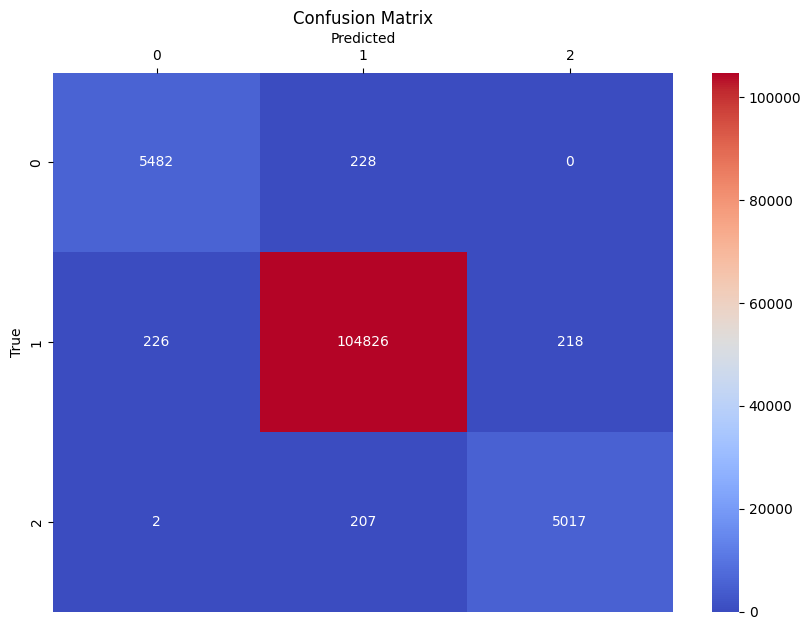

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='coolwarm')

# Rotate the x labels
plt.xticks(rotation=45)
# Move the y labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# Set labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

#### Trading Part

In [143]:
def trade_on_prediction(model, LOB3Data, feature_columns, num_bins, window_len, \
                        delay_steps, lambda_, batch_size, device, initial_cash, \
                            stop_loss=0.05, take_profit=0.10):
    # Convert the model to evaluation mode
    model.eval()

    # Initialize trading variables
    cash = initial_cash
    assets = 0
    total_return = 0  # Track total return

    # Initialize lists for tracking cash and assets over time
    cash_over_time = [(0, cash)]
    assets_over_time = [(0, assets)]

    # Move the model to the same device as data
    model.to(device)

    # Prepare the data
    data = calculate_lob_features(LOB3Data, num_bins, window_len, delay_steps, lambda_)
    
    categorical_features = ['current_imbalance_idx', 'current_price_movement']

    _, test_loader, raw_test_data = get_dataloaders(data, feature_columns, categorical_features, \
                                                    batch_size=1, val_data=False, return_raw_test_data=True)
    idx = 0
    # Loop over all the data in the test_loader
    with torch.no_grad():
        for X, _ in test_loader:
            X = X.to(device)
            predictions = model(X)
            predicted_class = torch.argmax(predictions, axis=1)

            current_ask_price = (raw_test_data['MOAsk'].iloc[idx]) / 10 ** 4
            current_bid_price = (raw_test_data['MOBid'].iloc[idx]) / 10 ** 4
 
            previous_cash = cash  # Remember the previous cash amount

            if predicted_class == 0:  # Predicted downward price movement
                if assets < 0:  # If we have a short position
                    cash = cash - current_ask_price  # Buy back
                    assets = assets + 1
                else:
                    cash = cash + current_bid_price  # Sell
                    assets = assets - 1
            elif predicted_class == 2:  # Predicted upward price movement
                if assets > 0:  # If we have a long position
                    cash = cash + current_bid_price  # Sell off
                    assets = assets - 1
                else:
                    cash = cash - current_ask_price  # Buy
                    assets = assets + 1

            # Update the total return
            total_return += cash - previous_cash

            # Risk management
            # Check if stop loss or take profit points have been hit
            if total_return <= -stop_loss * initial_cash:  # Stop loss point hit
                print(f"Stop loss point hit after {idx} iteration, ending trading.")
                return total_return, cash_over_time, assets_over_time
            elif total_return >= take_profit * initial_cash:  # Take profit point hit
                print(f"Take profit point hit after {idx} iteration, ending trading.")
                return total_return, cash_over_time, assets_over_time

            cash_over_time.append((idx, cash))
            assets_over_time.append((idx, assets))
            idx += 1

    # At the end of trading, liquidate position
    if assets > 0:
        cash = cash + assets * (raw_test_data['MOBid'].iloc[-1]) / 10 ** 4  # Sell off
    elif assets < 0:
        cash = cash + assets * (raw_test_data['MOAsk'].iloc[-1]) / 10 ** 4  # Buy back

    total_return += cash - initial_cash  # Update total return based on final cash amount
    return total_return, cash_over_time, assets_over_time


In [144]:
import re

def extract_params_from_filename(filename):
    pattern = r'model_lr=(.*)_batch=(.*)_epochs=(.*)_bins=(.*)_window=(.*)_delay=(.*)_lambda=(.*).pth'
    match = re.match(pattern, filename)
    params = match.groups() if match else None

    if params:
        return {
            "lr": float(params[0]),
            "batch_size": int(params[1]),
            "epochs": int(params[2]),
            "num_bins": int(params[3]),
            "window_len": int(params[4]),
            "delay_steps": int(params[5]),
            "lambda_": float(params[6]),
        }

    return None

# /home/sayem/Desktop/Lobster/model/model_lr=9.162494205094953e-05_batch=16_epochs=9_bins=8_window=18_delay=28_lambda=0.3773061177442172.pth

# filename = 'model_lr=9.162494205094953e-05_batch=16_epochs=9_bins=8_window=18_delay=28_lambda=0.3773061177442172.pth'
# best_params = extract_params_from_filename(filename)

# Use the extracted parameters
print(f'This model is loading: {model_path}/{model_filename}')
print('\n')

checkpoint = torch.load(f'{model_path}/{model_filename}')
model = checkpoint['model_architecture'](checkpoint['input_feature_size'], \
                                         checkpoint['output_class_size'])

model.load_state_dict(checkpoint['model_state_dict'])

This model is loading: /home/sayem/Desktop/Lobster/model/model_lr=1.6252789159483027e-05_batch=16_epochs=10_bins=5_window=19_delay=28_lambda=0.3836529373798785.pth




<All keys matched successfully>

In [145]:
# checkpoint = torch.load(f'{model_path}/{model_filename}')
# model = checkpoint['model_architecture'](checkpoint['input_feature_size'], \
#                                          checkpoint['output_class_size'])
# model.load_state_dict(checkpoint['model_state_dict'])

# # Provide the feature_columns
# feature_columns = ['current_imbalance_idx', 'current_price_movement', 'BidSlope', \
#                'AskSlope', 'RelSpread', 'AccumBidVol', 'AccumAskVol', 'OrderFlow', 'Liquidity', \
#                'BookDepth', 'Volatility', 'PriceMomentum', 'Spread', 'DepthImbalance']

stop_loss = 0.1
take_profit = 0.2
initial_cash = 100

# Assuming LOB3Data is defined and available
total_return, _, _ = trade_on_prediction(model, LOB3Data, feature_columns, best_params["num_bins"], best_params["window_len"], \
                    best_params["delay_steps"], best_params["lambda_"], 1, \
                    device, initial_cash, stop_loss=stop_loss, take_profit=take_profit)

Take profit point hit after 91 iteration, ending trading.


In [146]:
total_return

26.840000000000003

In [147]:
# ! pip install scikit-optimize

Stop loss point hit after 3542 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Stop loss point hit after 3542 iteration, ending trading.
Stop loss point hit after 3542 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Stop loss point hit after 2716 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit point hit after 91 iteration, ending trading.
Take profit po

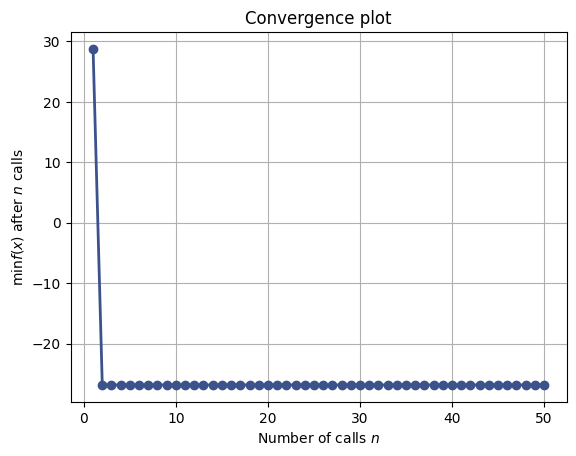

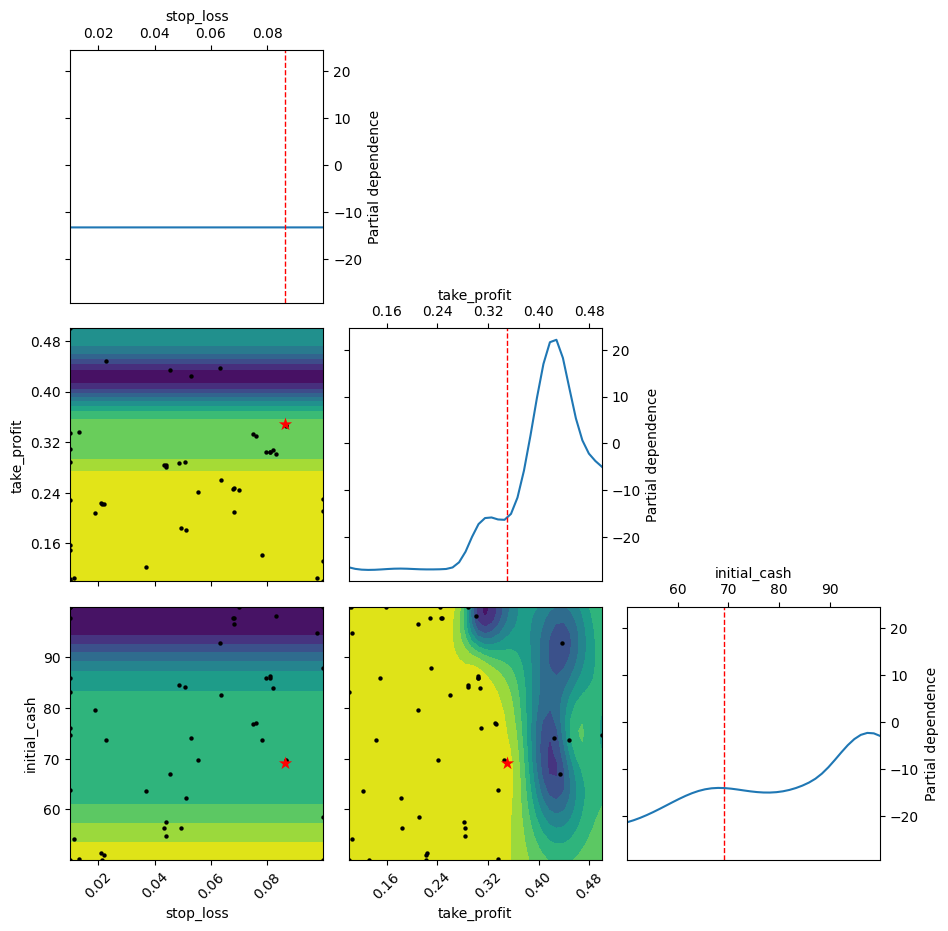

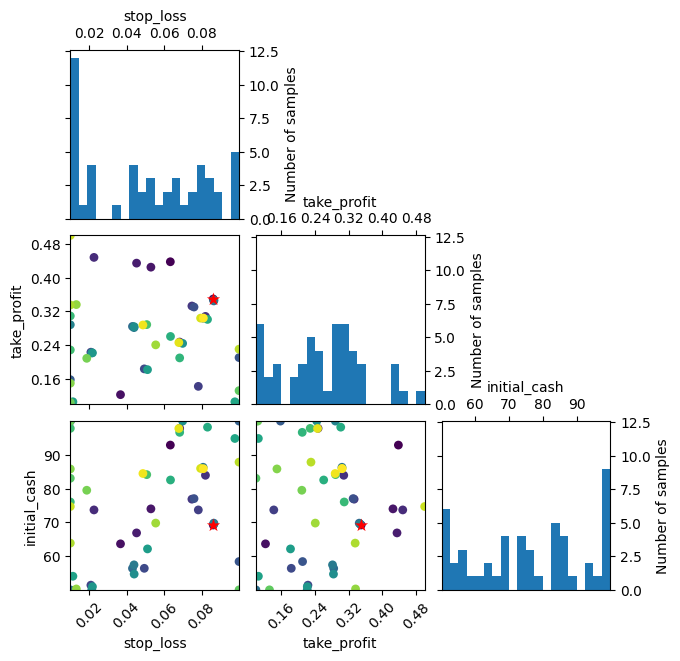

In [148]:
from matplotlib import pyplot as plt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.space import Real, Space


def trade_on_prediction_bayes(params):
    stop_loss, take_profit, initial_cash = params
    total_return, _, _ = trade_on_prediction(model, LOB3Data, feature_columns, \
                    best_params["num_bins"], best_params["window_len"], \
                    best_params["delay_steps"], best_params["lambda_"], \
                    1, device, initial_cash, stop_loss, take_profit)  # set batch_size=1
    return -total_return  # maximize total_return


# Define the space of hyperparameters to search
search_space = Space([Real(0.01, 0.1, name="stop_loss"), 
                      Real(0.1, 0.5, name="take_profit"),
                      Real(50, 100, name="initial_cash")])

# Perform Bayesian optimization
res_gp = gp_minimize(trade_on_prediction_bayes, search_space, \
                     n_calls=50, random_state=0)

# Convergence plot
plot_convergence(res_gp)
plt.show()

# Objective plot
_ = plot_objective(res_gp, size=3, dimensions=['stop_loss', 'take_profit', 'initial_cash'])
plt.show()

# Evaluations plot
_ = plot_evaluations(res_gp, dimensions=['stop_loss', 'take_profit', 'initial_cash'])
plt.show()



In [149]:
# Extract best parameters from the optimization result
best_params_optimized = res_gp.x
best_stop_loss, best_take_profit, best_initial_cash = best_params_optimized

# Print the best parameters
print("Best parameters from optimization: ")
print("Best stop loss: ", best_stop_loss)
print("Best take profit: ", best_take_profit)
print("Best initial cash: ", best_initial_cash)

Best parameters from optimization: 
Best stop loss:  0.08625265649057132
Best take profit:  0.349425478714389
Best initial cash:  69.21908536463499


In [150]:
total_return, cash_over_time, assets_over_time = trade_on_prediction(
                                    model, LOB3Data, feature_columns, best_params["num_bins"], 
                                    best_params["window_len"], best_params["delay_steps"], 
                                    best_params["lambda_"], 1, device, best_initial_cash, 
                                    stop_loss=best_stop_loss, take_profit=best_take_profit)

Take profit point hit after 91 iteration, ending trading.


In [151]:
total_return

26.840000000000003